In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

RDKit WARNING: [18:02:08] Enabling RDKit 2019.09.3 jupyter extensions
[18:02:08] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

number of all smiles:  133885


number of successfully processed smiles:  133885


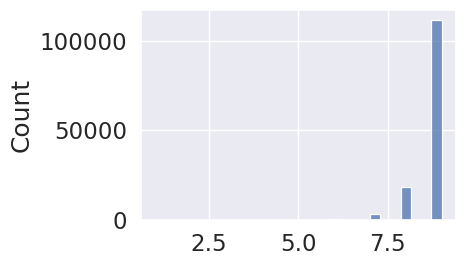

In [3]:
task_name = 'qm9'
tasks = [
   "mu","alpha","homo","lumo","gap","r2","zpve","u0","u298","h298","g298","cv"
]

raw_filename = "../data/qm9.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)

smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()


In [4]:
random_seed = 888 
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 500
epochs = 300

p_dropout= 0.5
fingerprint_dim = 280

weight_decay = 4.9 # also known as l2_regularization_lambda
learning_rate = 3.4
radius = 2
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num


In [5]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

C


N


O


feature dicts file saved as ../data/qm9.pickle


,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom,cano_smiles
0,gdb_1,C,157.71180,157.70997,157.70699,0.0000,13.21,-0.3877,0.1171,0.5048,...,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772,C
1,gdb_2,N,293.60975,293.54111,191.39397,1.6256,9.46,-0.2570,0.0829,0.3399,...,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802,N
2,gdb_3,O,799.58812,437.90386,282.94545,1.8511,6.31,-0.2928,0.0687,0.3615,...,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171,O


In [6]:
test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# get the stats of the seen dataset (the training data)
# which will be used to noramlize the dataset. 
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
for task in tasks:
    mean = training_data[task].mean()
    mean_list.append(mean)
    std = training_data[task].std()
    std_list.append(std)
    mad = training_data[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
    training_data[task+'_normalized'] = (training_data[task]- mean)/std
    test_df[task+'_normalized'] = (test_df[task]- mean)/std

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats


,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,mu,2.705515,1.531188,1.189853,1.286872
1,alpha,75.185527,8.180522,6.300819,1.298327
2,homo,-0.239966,0.022120,0.016288,1.358023
3,lumo,0.011126,0.046951,0.038650,1.214753
4,gap,0.251092,0.047534,0.039677,1.198034
5,r2,1188.891197,278.813211,201.628922,1.382804
6,zpve,0.148492,0.033272,0.026457,1.257577
7,u0,-411.514595,40.046114,31.089048,1.288110
8,u298,-411.506127,40.045897,31.088914,1.288109
9,h298,-411.505182,40.045897,31.088914,1.288109


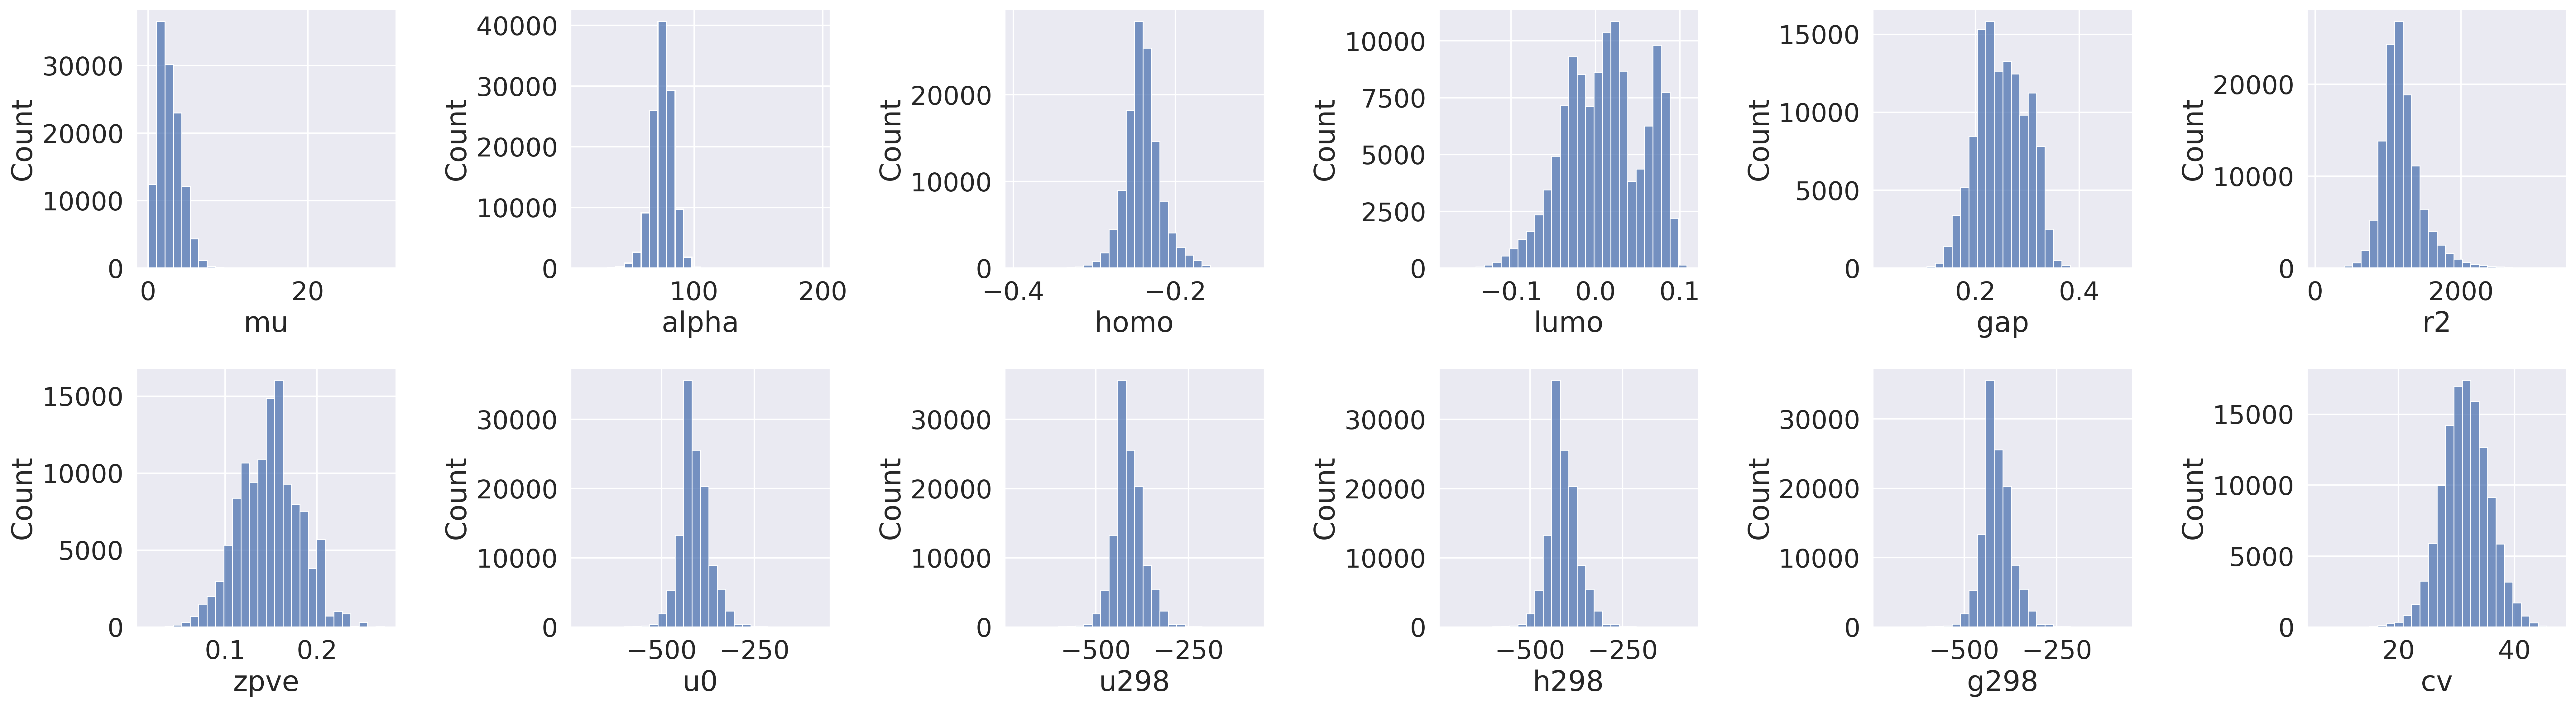

In [7]:
# check the value distribution of different tasks
plt.figure(figsize=(28, 8),dpi=300)
gs = gridspec.GridSpec(2, 6)
sns.set(font_scale=1.8)
for i, task in enumerate(tasks):
    plt.subplot(gs[(i)])
    x = pd.Series(training_data[task].values, name=task)
    ax = sns.histplot(x, bins=28, kde=False)
    plt.tight_layout()
plt.show()
plt.close()

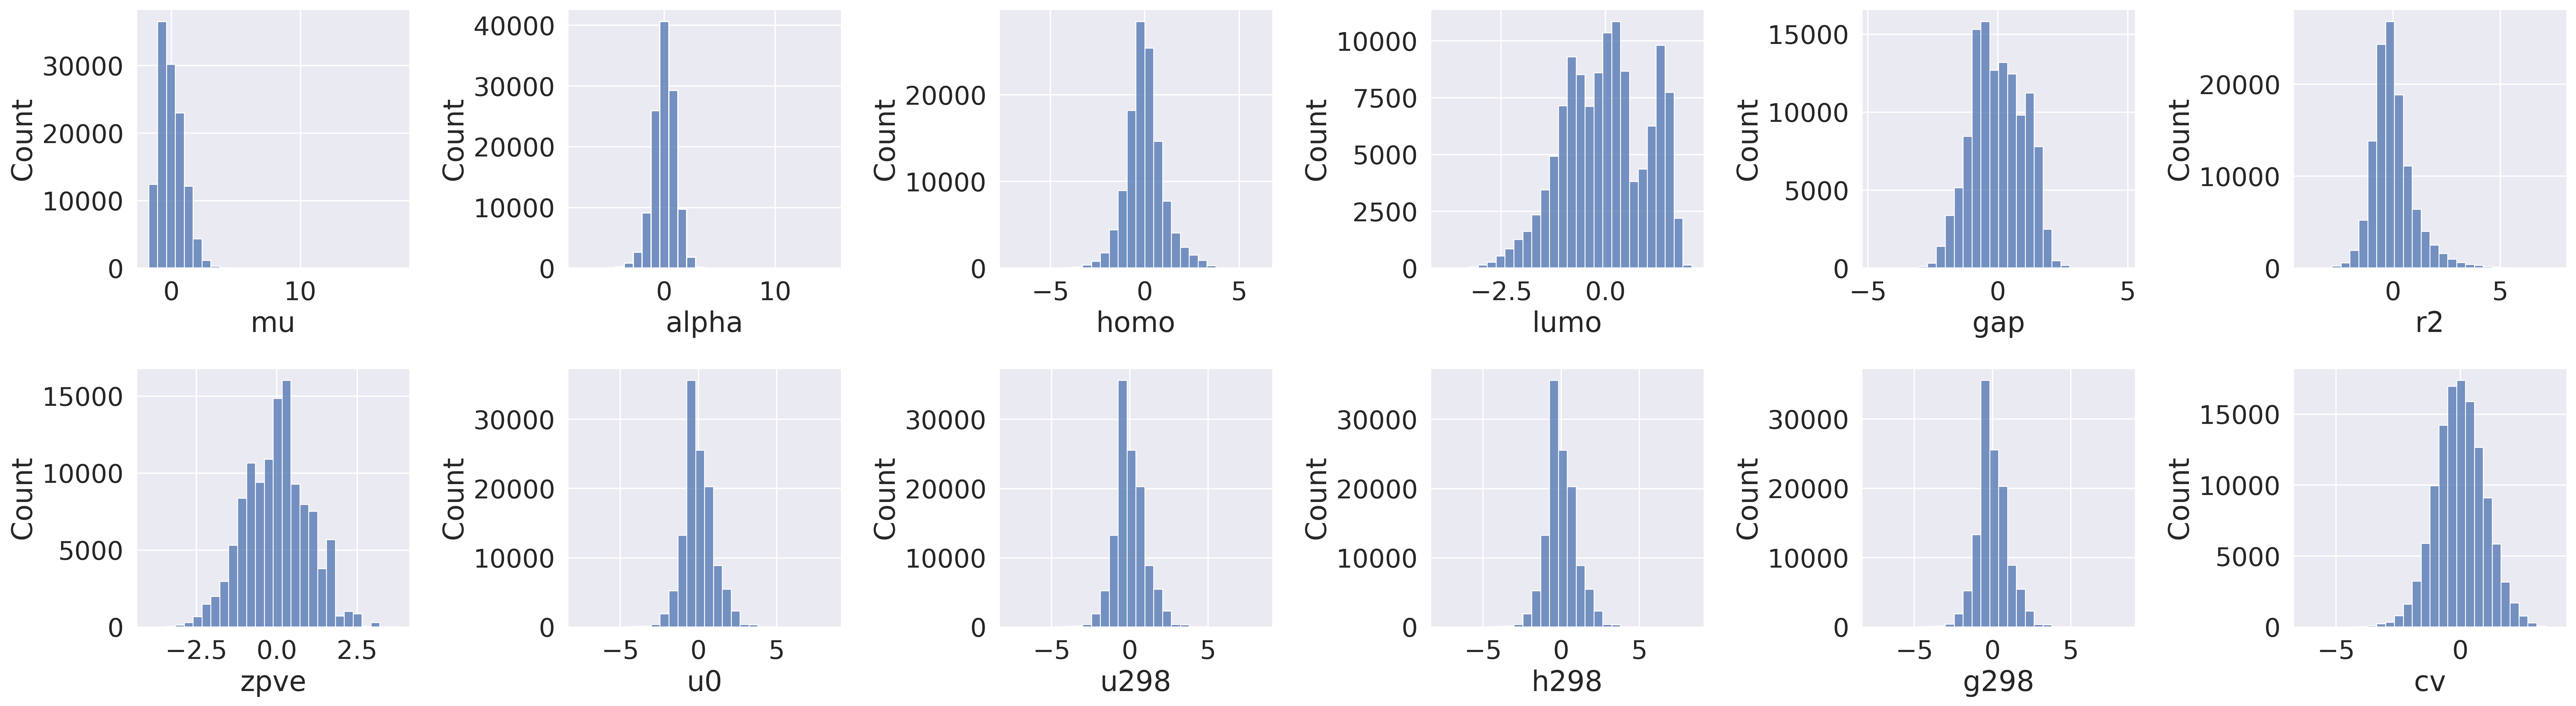

In [8]:
# check the distribution after normalization (should be the same)

plt.figure(figsize=(28, 8),dpi=300)
gs = gridspec.GridSpec(2, 6)
sns.set(font_scale=1.8)
for i, task in enumerate(tasks):
    plt.subplot(gs[(i)])
    x = pd.Series(training_data[task+"_normalized"].values, name=task)
    ax = sns.histplot(x, bins=28, kde=False)
    plt.tight_layout()
plt.show()
plt.close()

In [9]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[8]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
# loss_function = nn.L1Loss()
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1682535
atom_fc.weight torch.Size([280, 39])
atom_fc.bias torch.Size([280])
neighbor_fc.weight torch.Size([280, 49])
neighbor_fc.bias torch.Size([280])
GRUCell.0.weight_ih torch.Size([840, 280])
GRUCell.0.weight_hh torch.Size([840, 280])
GRUCell.0.bias_ih torch.Size([840])
GRUCell.0.bias_hh torch.Size([840])
GRUCell.1.weight_ih torch.Size([840, 280])
GRUCell.1.weight_hh torch.Size([840, 280])
GRUCell.1.bias_ih torch.Size([840])
GRUCell.1.bias_hh torch.Size([840])
align.0.weight torch.Size([1, 560])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 560])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([280, 280])
attend.0.bias torch.Size([280])
attend.1.weight torch.Size([280, 280])
attend.1.bias torch.Size([280])
mol_GRUCell.weight_ih torch.Size([840, 280])
mol_GRUCell.weight_hh torch.Size([840, 280])
mol_GRUCell.bias_ih torch.Size([840])
mol_GRUCell.bias_hh torch.Size([840])
mol_align.weight torch.Size([1, 560])
mol_align.bias torch.Size([1])
mol_attend.weight torch.S

In [10]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)
        
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))

        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i]
            y_val = batch_df[task+"_normalized"].values
            loss += loss_function(y_pred, torch.Tensor(y_val).squeeze())*ratio_list[i]**2
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    eval_MAE_list = {}
    eval_MSE_list = {}
    y_val_list = {}
    y_pred_list = {}
    for i,task in enumerate(tasks):
        y_pred_list[task] = np.array([])
        y_val_list[task] = np.array([])
        eval_MAE_list[task] = np.array([])
        eval_MSE_list[task] = np.array([])
        
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
            
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i]
            y_val = batch_df[task+"_normalized"].values
            
            MAE = F.l1_loss(y_pred, torch.Tensor(y_val).squeeze(), reduction='none')        
            MSE = F.mse_loss(y_pred, torch.Tensor(y_val).squeeze(), reduction='none')
            y_pred_list[task] = np.concatenate([y_pred_list[task], y_pred.cpu().detach().numpy()])
            y_val_list[task] = np.concatenate([y_val_list[task], y_val])
            eval_MAE_list[task] = np.concatenate([eval_MAE_list[task],MAE.data.squeeze().cpu().numpy()])
            eval_MSE_list[task] = np.concatenate([eval_MSE_list[task],MSE.data.squeeze().cpu().numpy()])
#     r2_score_list = [r2_score(y_val_list[task], y_pred_list[task]) for task in tasks]
    eval_MAE_normalized = np.array([eval_MAE_list[task].mean() for i, task in enumerate(tasks)])
    eval_MAE = np.multiply(eval_MAE_normalized,np.array(std_list))
    eval_MSE_normalized = np.array([eval_MSE_list[task].mean() for i, task in enumerate(tasks)])
    eval_MSE = np.multiply(eval_MSE_normalized,np.array(std_list))

    return eval_MAE_normalized, eval_MAE, eval_MSE_normalized, eval_MSE #, r2_score_list


In [11]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE_normalized"] = 9e8
best_param["valid_MSE_normalized"] = 9e8
for epoch in range(300):
    train(model, train_df, optimizer, loss_function)
    train_MAE_normalized, train_MAE, train_MSE_normalized, train_MSE = eval(model, train_df)
    valid_MAE_normalized, valid_MAE, valid_MSE_normalized, valid_MSE, = eval(model, valid_df)
    print("EPOCH:\t"+str(epoch)+'\n'\
#         +"train_MAE_normalized: "+str(train_MAE_normalized)+'\n'\
#         +"valid_MAE_normalized: "+str(valid_MAE_normalized)+'\n'\
        +"train_MAE"+":"+"\n"+str(train_MAE)+'\n'\
        +"valid_MAE"+":"+"\n"+str(valid_MAE)+'\n'\
          
        +"train_MSE_normalized_mean: "+str(train_MSE_normalized.mean())+'\n'\
        +"valid_MSE_normalized_mean: "+str(valid_MSE_normalized.mean())+'\n'\
#         +"train_MSE_normalized: "+str(train_MSE_normalized)+'\n'\
#         +"valid_MSE_normalized: "+str(valid_MSE_normalized)+'\n'\
        )
    if train_MSE_normalized.mean() < best_param["train_MSE_normalized"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE_normalized"] = train_MSE_normalized.mean()
    if valid_MSE_normalized.mean() < best_param["valid_MSE_normalized"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE_normalized"] = valid_MSE_normalized.mean()
        if valid_MSE_normalized.mean() < 0.06:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
    


EPOCH:	0
train_MAE:
[8.44988153e-01 1.25333288e+00 9.69752295e-03 1.49890798e-02
 1.72664154e-02 7.51245943e+01 2.83419498e-03 3.70972277e+00
 3.70024511e+00 4.13562229e+00 4.11120355e+00 5.65835178e-01]
valid_MAE:
[8.42684512e-01 1.26131084e+00 9.70105516e-03 1.49691246e-02
 1.74418028e-02 7.52298184e+01 2.81570903e-03 3.70671076e+00
 3.68316982e+00 4.13343178e+00 4.10145146e+00 5.66102958e-01]
train_MSE_normalized_mean: 0.1349965744978369
valid_MSE_normalized_mean: 0.13624282841801522



EPOCH:	1
train_MAE:
[7.63011298e-01 1.38808086e+00 8.59877321e-03 1.11162098e-02
 1.40842291e-02 7.07370196e+01 3.67467328e-03 5.05554623e+00
 5.82316500e+00 5.56936849e+00 5.36381501e+00 7.08582368e-01]
valid_MAE:
[7.62827466e-01 1.38486474e+00 8.63318156e-03 1.11408388e-02
 1.42289810e-02 7.04975746e+01 3.66617725e-03 5.05943613e+00
 5.84273005e+00 5.58207728e+00 5.37853966e+00 7.03709540e-01]
train_MSE_normalized_mean: 0.11081658981583727
valid_MSE_normalized_mean: 0.11153035934594807



EPOCH:	2
train_MAE:
[7.34922517e-01 9.90143138e-01 8.35837227e-03 9.76489852e-03
 1.29938857e-02 5.95847649e+01 1.81667691e-03 3.18992068e+00
 3.59398657e+00 3.78026802e+00 3.78124339e+00 4.54224773e-01]
valid_MAE:
[7.34811466e-01 9.95212401e-01 8.38430368e-03 9.73180787e-03
 1.30412591e-02 6.00513405e+01 1.81115806e-03 3.20100692e+00
 3.61513458e+00 3.79927468e+00 3.80529109e+00 4.51116780e-01]
train_MSE_normalized_mean: 0.09031962643305036
valid_MSE_normalized_mean: 0.09087944993098225



EPOCH:	3
train_MAE:
[7.22158227e-01 9.76862595e-01 7.81755801e-03 8.48445246e-03
 1.13215011e-02 5.56646397e+01 1.74078537e-03 3.38388664e+00
 3.59859022e+00 3.74236608e+00 4.03767253e+00 4.36533340e-01]
valid_MAE:
[7.26959084e-01 9.82758483e-01 7.83755398e-03 8.48371158e-03
 1.13815051e-02 5.62467525e+01 1.74093177e-03 3.38311786e+00
 3.60015345e+00 3.74221064e+00 4.04103644e+00 4.35065727e-01]
train_MSE_normalized_mean: 0.08144223920926108
valid_MSE_normalized_mean: 0.08222335485996808



EPOCH:	4
train_MAE:
[6.88658134e-01 1.35834649e+00 7.52878673e-03 8.16318035e-03
 1.13132903e-02 6.13394544e+01 1.65712616e-03 7.34705950e+00
 7.56720377e+00 7.92759945e+00 7.47815746e+00 5.82873297e-01]
valid_MAE:
[6.90257374e-01 1.36085041e+00 7.51387126e-03 8.17166053e-03
 1.13734407e-02 6.12057512e+01 1.65152210e-03 7.37031435e+00
 7.58976341e+00 7.95125674e+00 7.50237329e+00 5.79855122e-01]
train_MSE_normalized_mean: 0.09151077168932704
valid_MSE_normalized_mean: 0.09208781318589332



EPOCH:	5
train_MAE:
[6.80279954e-01 1.06229350e+00 8.50484346e-03 7.49619564e-03
 1.14927551e-02 5.64471618e+01 2.23429775e-03 1.58741028e+00
 1.63828776e+00 1.65648368e+00 1.70607672e+00 5.21579910e-01]
valid_MAE:
[6.86585520e-01 1.06164808e+00 8.59451980e-03 7.45183783e-03
 1.15066611e-02 5.64470320e+01 2.23579772e-03 1.59051684e+00
 1.64327151e+00 1.66216516e+00 1.71348396e+00 5.19153445e-01]
train_MSE_normalized_mean: 0.07946454252492043
valid_MSE_normalized_mean: 0.08008219597582365



EPOCH:	6
train_MAE:
[6.68942033e-01 9.63417879e-01 7.03156967e-03 7.42908708e-03
 1.01298788e-02 5.44102802e+01 1.30088152e-03 2.45719970e+00
 2.31507372e+00 2.25779461e+00 2.23581036e+00 4.07643422e-01]
valid_MAE:
[6.71719449e-01 9.62988165e-01 7.06505225e-03 7.42984501e-03
 1.01753827e-02 5.44499736e+01 1.30084439e-03 2.44719976e+00
 2.30474661e+00 2.24790809e+00 2.22591279e+00 4.05094476e-01]
train_MSE_normalized_mean: 0.07000512643849564
valid_MSE_normalized_mean: 0.0706057989203515



EPOCH:	7
train_MAE:
[6.58771744e-01 1.03093821e+00 6.98393668e-03 7.27772891e-03
 9.69044600e-03 4.82638015e+01 2.60293618e-03 1.78888083e+00
 1.76636515e+00 1.77885595e+00 1.81173280e+00 4.57910039e-01]
valid_MAE:
[6.61870615e-01 1.02811988e+00 7.03830821e-03 7.29430173e-03
 9.74233486e-03 4.86323138e+01 2.61012732e-03 1.81835060e+00
 1.79597874e+00 1.80857697e+00 1.84228335e+00 4.54949659e-01]
train_MSE_normalized_mean: 0.06707840769648823
valid_MSE_normalized_mean: 0.06783944197416146



EPOCH:	8
train_MAE:
[6.43126119e-01 7.85098947e-01 6.67288879e-03 7.00383337e-03
 9.84463996e-03 4.66837215e+01 1.44134925e-03 1.13816309e+00
 1.12756067e+00 1.12812042e+00 1.12845221e+00 3.83546273e-01]
valid_MAE:
[6.46729921e-01 7.87219708e-01 6.73705165e-03 6.99820227e-03
 9.89334564e-03 4.72954586e+01 1.43236324e-03 1.13329636e+00
 1.12326766e+00 1.12383004e+00 1.12442308e+00 3.80917401e-01]
train_MSE_normalized_mean: 0.062240543465599256
valid_MSE_normalized_mean: 0.06295826079860442



EPOCH:	9
train_MAE:
[6.39792084e-01 7.97634291e-01 6.53287473e-03 6.96047751e-03
 9.48501299e-03 4.62592468e+01 1.51576084e-03 1.67100055e+00
 1.67745295e+00 1.67935072e+00 1.66817280e+00 4.02737513e-01]
valid_MAE:
[6.41719607e-01 8.00617481e-01 6.60538683e-03 6.94401800e-03
 9.48351170e-03 4.67124837e+01 1.51881933e-03 1.66605989e+00
 1.67255780e+00 1.67454198e+00 1.66357567e+00 4.00254421e-01]
train_MSE_normalized_mean: 0.06159978190630882
valid_MSE_normalized_mean: 0.06230247686626702



EPOCH:	10
train_MAE:
[6.43382309e-01 1.05097590e+00 6.97527109e-03 6.77770161e-03
 9.47940735e-03 4.60863826e+01 2.56513111e-03 1.66413073e+00
 1.66328217e+00 1.66642180e+00 1.66568770e+00 4.71033040e-01]
valid_MAE:
[6.45987489e-01 1.05649874e+00 7.05104593e-03 6.79125682e-03
 9.51978210e-03 4.66636499e+01 2.55802221e-03 1.68544624e+00
 1.68462586e+00 1.68789558e+00 1.68733884e+00 4.70727152e-01]
train_MSE_normalized_mean: 0.0639500091977279
valid_MSE_normalized_mean: 0.06472341966012898



EPOCH:	11
train_MAE:
[6.30230173e-01 9.72900085e-01 6.37746946e-03 6.63695554e-03
 9.15454812e-03 4.94129588e+01 1.89188790e-03 2.01457042e+00
 2.01612189e+00 2.01455307e+00 2.01406911e+00 4.38679541e-01]
valid_MAE:
[6.32446884e-01 9.75915205e-01 6.42645631e-03 6.65011415e-03
 9.19519146e-03 5.00056836e+01 1.88069301e-03 1.99771275e+00
 1.99914827e+00 1.99758567e+00 1.99716706e+00 4.36980374e-01]
train_MSE_normalized_mean: 0.06112261278717195
valid_MSE_normalized_mean: 0.06199512640536134



EPOCH:	12
train_MAE:
[6.44741231e-01 7.70835428e-01 6.42665188e-03 6.85661075e-03
 9.05152557e-03 4.35114417e+01 1.36620117e-03 1.03667482e+00
 1.03732943e+00 1.03719772e+00 1.03680466e+00 3.64015944e-01]
valid_MAE:
[6.48803780e-01 7.74369613e-01 6.49540566e-03 6.89655311e-03
 9.06258247e-03 4.40718793e+01 1.35660647e-03 1.04131128e+00
 1.04200313e+00 1.04181186e+00 1.04142607e+00 3.61823731e-01]
train_MSE_normalized_mean: 0.05925473624101663
valid_MSE_normalized_mean: 0.05998829907675638



EPOCH:	13
train_MAE:
[6.32318087e-01 8.45170104e-01 6.13299925e-03 7.38697464e-03
 9.52149279e-03 4.46643498e+01 1.25227249e-03 1.38057250e+00
 1.37670615e+00 1.37739535e+00 1.38025713e+00 3.78327402e-01]
valid_MAE:
[6.34225766e-01 8.48959803e-01 6.20091216e-03 7.40923111e-03
 9.54445479e-03 4.51136130e+01 1.25125552e-03 1.37957922e+00
 1.37567835e+00 1.37639489e+00 1.37924777e+00 3.75225069e-01]
train_MSE_normalized_mean: 0.059226892369125116
valid_MSE_normalized_mean: 0.060057702669868186



EPOCH:	14
train_MAE:
[6.18053728e-01 7.10960621e-01 6.11991803e-03 6.51726139e-03
 8.74591573e-03 4.34101819e+01 1.37665692e-03 1.01527833e+00
 1.01538023e+00 1.01509119e+00 1.01426938e+00 3.66694468e-01]
valid_MAE:
[6.19606460e-01 7.12939536e-01 6.18369415e-03 6.54024301e-03
 8.76560802e-03 4.38810183e+01 1.37188943e-03 1.02546883e+00
 1.02556489e+00 1.02527861e+00 1.02448176e+00 3.63753913e-01]
train_MSE_normalized_mean: 0.056004960537520576
valid_MSE_normalized_mean: 0.05690110760540132



EPOCH:	15
train_MAE:
[6.09125534e-01 6.88024369e-01 5.90809867e-03 6.63494085e-03
 8.92718980e-03 4.13687566e+01 1.02371347e-03 2.56920434e+00
 2.57046986e+00 2.57051997e+00 2.57352315e+00 3.47841453e-01]
valid_MAE:
[6.12252163e-01 6.90671252e-01 5.97030083e-03 6.62922878e-03
 8.95069948e-03 4.18567512e+01 1.02217362e-03 2.56175768e+00
 2.56299004e+00 2.56305246e+00 2.56606224e+00 3.44676784e-01]
train_MSE_normalized_mean: 0.05549396291818754
valid_MSE_normalized_mean: 0.05635012249149371



EPOCH:	16
train_MAE:
[6.03749685e-01 7.91734529e-01 5.94328982e-03 6.85684012e-03
 8.90839047e-03 4.16559302e+01 1.58092025e-03 3.99952851e+00
 3.99975073e+00 3.99854914e+00 3.99748080e+00 3.97081650e-01]
valid_MAE:
[6.06610998e-01 7.97824445e-01 6.00472457e-03 6.89301529e-03
 8.90549140e-03 4.22233188e+01 1.57160809e-03 4.01271359e+00
 4.01291416e+00 4.01171060e+00 4.01067752e+00 3.96356741e-01]
train_MSE_normalized_mean: 0.05808275992401074
valid_MSE_normalized_mean: 0.05905836010089322



EPOCH:	17
train_MAE:
[6.08728099e-01 8.03970797e-01 5.85045992e-03 6.30058117e-03
 8.57476501e-03 4.49859486e+01 1.83088717e-03 2.16450815e+00
 2.16486248e+00 2.16453865e+00 2.16372870e+00 4.60506426e-01]
valid_MAE:
[6.09944752e-01 8.12408860e-01 5.91186832e-03 6.30909904e-03
 8.57036751e-03 4.55340057e+01 1.82388271e-03 2.16536175e+00
 2.16570297e+00 2.16537380e+00 2.16459520e+00 4.58719342e-01]
train_MSE_normalized_mean: 0.05606244877608082
valid_MSE_normalized_mean: 0.057042578893387264



EPOCH:	18
train_MAE:
[5.97293108e-01 9.19208623e-01 5.79701271e-03 7.97660927e-03
 9.33381795e-03 4.14450958e+01 1.31825020e-03 1.42087990e+00
 1.42085706e+00 1.42091736e+00 1.42108260e+00 3.57617384e-01]
valid_MAE:
[6.00705449e-01 9.21329768e-01 5.85447838e-03 7.94061532e-03
 9.32783956e-03 4.20659454e+01 1.30769632e-03 1.41417647e+00
 1.41415849e+00 1.41422404e+00 1.41437684e+00 3.54590106e-01]
train_MSE_normalized_mean: 0.054708152555321264
valid_MSE_normalized_mean: 0.05557736751610442



EPOCH:	19
train_MAE:
[5.94449744e-01 6.69224635e-01 5.86598099e-03 6.19728996e-03
 8.26001311e-03 3.97957096e+01 1.45589925e-03 1.21451370e+00
 1.21455649e+00 1.21458653e+00 1.21447457e+00 3.37148231e-01]
valid_MAE:
[5.98201443e-01 6.65924970e-01 5.93218720e-03 6.18939461e-03
 8.25275875e-03 4.02586978e+01 1.45884556e-03 1.20716413e+00
 1.20719802e+00 1.20723084e+00 1.20713967e+00 3.34682494e-01]
train_MSE_normalized_mean: 0.052156149588787816
valid_MSE_normalized_mean: 0.05328821866761288



EPOCH:	20
train_MAE:
[6.09149581e-01 6.81397102e-01 5.69100624e-03 6.09739319e-03
 8.22727425e-03 4.14080957e+01 1.17009035e-03 1.96859484e+00
 1.96869170e+00 1.96857400e+00 1.96831280e+00 3.65132193e-01]
valid_MAE:
[6.11999222e-01 6.91143075e-01 5.77712720e-03 6.08963224e-03
 8.20535135e-03 4.21808455e+01 1.16805303e-03 1.96972418e+00
 1.96982286e+00 1.96970914e+00 1.96943836e+00 3.60205810e-01]
train_MSE_normalized_mean: 0.05272544194252624
valid_MSE_normalized_mean: 0.05384593153794087



EPOCH:	21
train_MAE:
[5.96365037e-01 6.35051334e-01 6.02239837e-03 6.43851619e-03
 8.17105178e-03 3.90907939e+01 1.22653465e-03 1.36908317e+00
 1.36908165e+00 1.36929829e+00 1.36908863e+00 3.40541786e-01]
valid_MAE:
[5.99558734e-01 6.39450440e-01 6.08800124e-03 6.41138967e-03
 8.15505655e-03 3.97003834e+01 1.22686764e-03 1.37705661e+00
 1.37705427e+00 1.37727752e+00 1.37706441e+00 3.36905716e-01]
train_MSE_normalized_mean: 0.05200830342874816
valid_MSE_normalized_mean: 0.053147831820403967



EPOCH:	22
train_MAE:
[5.94193890e-01 7.05598593e-01 6.04119278e-03 6.11835294e-03
 8.45110112e-03 3.96321320e+01 1.57796306e-03 1.75724048e+00
 1.75705206e+00 1.75716458e+00 1.75707937e+00 3.24016103e-01]
valid_MAE:
[5.98328706e-01 7.13229917e-01 6.12170695e-03 6.12167188e-03
 8.44786974e-03 4.04060306e+01 1.57198139e-03 1.76375869e+00
 1.76357186e+00 1.76368163e+00 1.76359986e+00 3.20655512e-01]
train_MSE_normalized_mean: 0.052284655877166054
valid_MSE_normalized_mean: 0.053586585302719265



EPOCH:	23
train_MAE:
[5.84851872e-01 6.84900860e-01 5.60750033e-03 6.03003326e-03
 8.11235844e-03 4.08926322e+01 1.77222815e-03 1.00258841e+00
 1.00259898e+00 1.00262859e+00 1.00266873e+00 3.65205195e-01]
valid_MAE:
[5.87766004e-01 6.90797771e-01 5.67140529e-03 5.98949665e-03
 8.08257189e-03 4.14760116e+01 1.78271566e-03 1.00891828e+00
 1.00892298e+00 1.00895357e+00 1.00901274e+00 3.63296536e-01]
train_MSE_normalized_mean: 0.05016233329938601
valid_MSE_normalized_mean: 0.05132478210306409



EPOCH:	24
train_MAE:
[5.98199954e-01 6.37422324e-01 5.47720708e-03 6.09422413e-03
 8.28934011e-03 3.87955762e+01 1.32568324e-03 1.07876654e+00
 1.07883520e+00 1.07882944e+00 1.07885051e+00 3.45853959e-01]
valid_MAE:
[6.01059750e-01 6.42837570e-01 5.55169825e-03 6.07839649e-03
 8.26073595e-03 3.94394454e+01 1.33458984e-03 1.07834212e+00
 1.07841613e+00 1.07840774e+00 1.07843087e+00 3.43215695e-01]
train_MSE_normalized_mean: 0.0501094236989958
valid_MSE_normalized_mean: 0.05133406384683727



EPOCH:	25
train_MAE:
[5.88151613e-01 6.34892092e-01 5.45851438e-03 6.02813892e-03
 7.95700025e-03 3.87425079e+01 1.36792809e-03 1.12864296e+00
 1.12861393e+00 1.12864179e+00 1.12862489e+00 3.32590925e-01]
valid_MAE:
[5.89105336e-01 6.38816478e-01 5.52864883e-03 6.03498787e-03
 7.94143072e-03 3.95142363e+01 1.35992949e-03 1.13288882e+00
 1.13286219e+00 1.13288897e+00 1.13286080e+00 3.29120174e-01]
train_MSE_normalized_mean: 0.04898777176044797
valid_MSE_normalized_mean: 0.050165676497155205



EPOCH:	26
train_MAE:
[5.80193893e-01 1.05498708e+00 5.35059544e-03 5.93448835e-03
 7.79413466e-03 4.63830974e+01 2.14716921e-03 3.28968142e+00
 3.28957571e+00 3.28953486e+00 3.28970638e+00 5.32004649e-01]
valid_MAE:
[5.82603819e-01 1.06226064e+00 5.41928387e-03 5.91397165e-03
 7.75388397e-03 4.68905288e+01 2.14607076e-03 3.30405854e+00
 3.30395347e+00 3.30391151e+00 3.30409175e+00 5.33476624e-01]
train_MSE_normalized_mean: 0.05373952730876692
valid_MSE_normalized_mean: 0.05505863347919487



EPOCH:	27
train_MAE:
[5.92210886e-01 8.61792907e-01 5.71291627e-03 6.85884276e-03
 8.04027011e-03 4.00356029e+01 2.28635976e-03 1.75297495e+00
 1.75299937e+00 1.75296044e+00 1.75309383e+00 3.53480138e-01]
valid_MAE:
[5.97687804e-01 8.68104335e-01 5.78827725e-03 6.88897816e-03
 8.04452897e-03 4.07540372e+01 2.28904027e-03 1.74659165e+00
 1.74661762e+00 1.74657805e+00 1.74670846e+00 3.50941685e-01]
train_MSE_normalized_mean: 0.051806820856805914
valid_MSE_normalized_mean: 0.05314993609776006



EPOCH:	28
train_MAE:
[5.78961970e-01 6.76600842e-01 5.61126426e-03 5.78004306e-03
 7.89790741e-03 4.13064023e+01 1.60207062e-03 1.95668589e+00
 1.95672457e+00 1.95670472e+00 1.95665350e+00 3.32226208e-01]
valid_MAE:
[5.82558087e-01 6.83008217e-01 5.69561199e-03 5.78372904e-03
 7.89445254e-03 4.19380329e+01 1.59685317e-03 1.97276495e+00
 1.97280428e+00 1.97278429e+00 1.97273343e+00 3.30269299e-01]
train_MSE_normalized_mean: 0.04942810567567591
valid_MSE_normalized_mean: 0.050656116543013247



EPOCH:	29
train_MAE:
[5.77018536e-01 6.11641585e-01 5.57694238e-03 5.72440824e-03
 7.89830315e-03 3.76996312e+01 1.18599393e-03 8.98660511e-01
 8.98640549e-01 8.98643157e-01 8.98724919e-01 3.36259358e-01]
valid_MAE:
[5.78350477e-01 6.15368572e-01 5.65382927e-03 5.76056487e-03
 7.90743407e-03 3.82034358e+01 1.18797789e-03 8.91819047e-01
 8.91799682e-01 8.91802990e-01 8.91884327e-01 3.33771490e-01]
train_MSE_normalized_mean: 0.04729652963943833
valid_MSE_normalized_mean: 0.048760934632576525



EPOCH:	30
train_MAE:
[5.74576729e-01 6.91898461e-01 5.36153295e-03 6.11488689e-03
 7.87746817e-03 4.20655989e+01 1.29327080e-03 3.04307942e+00
 3.04304828e+00 3.04309815e+00 3.04321798e+00 3.55936803e-01]
valid_MAE:
[5.78589549e-01 6.95293812e-01 5.44054314e-03 6.13951996e-03
 7.89650912e-03 4.26989149e+01 1.29730292e-03 3.05988349e+00
 3.05984877e+00 3.05989941e+00 3.06003103e+00 3.54902554e-01]
train_MSE_normalized_mean: 0.04988794571978597
valid_MSE_normalized_mean: 0.05136862959742738



EPOCH:	31
train_MAE:
[5.76964468e-01 6.15995406e-01 5.21345150e-03 5.75982160e-03
 7.69720011e-03 3.76503545e+01 1.17463495e-03 1.87529006e+00
 1.87529312e+00 1.87530757e+00 1.87535116e+00 3.30222365e-01]
valid_MAE:
[5.78866032e-01 6.21553515e-01 5.28513562e-03 5.78321722e-03
 7.70206268e-03 3.83327668e+01 1.16859226e-03 1.88106190e+00
 1.88106440e+00 1.88107889e+00 1.88112744e+00 3.27213579e-01]
train_MSE_normalized_mean: 0.04716659953297558
valid_MSE_normalized_mean: 0.04846360986442511



EPOCH:	32
train_MAE:
[5.64133455e-01 5.98922214e-01 5.16195870e-03 5.70268391e-03
 7.82159971e-03 3.70233744e+01 1.01000124e-03 1.18232588e+00
 1.18234770e+00 1.18233108e+00 1.18229990e+00 3.26155257e-01]
valid_MAE:
[5.68384349e-01 6.04085214e-01 5.24324545e-03 5.74035048e-03
 7.87143466e-03 3.75795849e+01 1.00771313e-03 1.18637843e+00
 1.18640000e+00 1.18638239e+00 1.18634885e+00 3.23334283e-01]
train_MSE_normalized_mean: 0.0456477519522365
valid_MSE_normalized_mean: 0.047202353921248975



EPOCH:	33
train_MAE:
[5.70741054e-01 6.90960755e-01 5.18351706e-03 6.11445304e-03
 7.64539170e-03 3.70304224e+01 2.37529108e-03 1.10324094e+00
 1.10322506e+00 1.10322736e+00 1.10327297e+00 3.68544789e-01]
valid_MAE:
[5.74363985e-01 7.01489251e-01 5.26347321e-03 6.14796417e-03
 7.67803456e-03 3.77549610e+01 2.35791688e-03 1.08188968e+00
 1.08187114e+00 1.08187405e+00 1.08192286e+00 3.67475412e-01]
train_MSE_normalized_mean: 0.04655583369576835
valid_MSE_normalized_mean: 0.04801146533394349



EPOCH:	34
train_MAE:
[5.60605350e-01 6.50670712e-01 5.36137807e-03 5.96559210e-03
 7.50078658e-03 3.71925126e+01 1.17457373e-03 2.24553453e+00
 2.24555302e+00 2.24555338e+00 2.24556896e+00 3.09013780e-01]
valid_MAE:
[5.64508426e-01 6.59203883e-01 5.44928899e-03 5.98532259e-03
 7.52961388e-03 3.79006151e+01 1.17167902e-03 2.26667811e+00
 2.26669850e+00 2.26669892e+00 2.26671225e+00 3.06047007e-01]
train_MSE_normalized_mean: 0.046583807647831654
valid_MSE_normalized_mean: 0.048297504876841424



EPOCH:	35
train_MAE:
[5.59979672e-01 6.38185657e-01 5.09776832e-03 5.49840881e-03
 7.50018621e-03 3.68529130e+01 1.20880051e-03 8.69515317e-01
 8.69496519e-01 8.69494471e-01 8.69531855e-01 3.45249120e-01]
valid_MAE:
[5.64728610e-01 6.47831023e-01 5.18993351e-03 5.51668076e-03
 7.50952676e-03 3.75118978e+01 1.21098948e-03 8.60803678e-01
 8.60786307e-01 8.60784286e-01 8.60819108e-01 3.43751996e-01]
train_MSE_normalized_mean: 0.0441731281659326
valid_MSE_normalized_mean: 0.04591465753043996



EPOCH:	36
train_MAE:
[5.68028290e-01 6.31148744e-01 5.08984170e-03 5.79041973e-03
 7.54913039e-03 3.73488301e+01 1.97168603e-03 1.16844558e+00
 1.16841582e+00 1.16841040e+00 1.16849846e+00 3.13304360e-01]
valid_MAE:
[5.69844579e-01 6.39598087e-01 5.16159334e-03 5.81434823e-03
 7.56185857e-03 3.78763336e+01 1.97764321e-03 1.16768924e+00
 1.16766300e+00 1.16765767e+00 1.16774342e+00 3.11801204e-01]
train_MSE_normalized_mean: 0.0448764907361085
valid_MSE_normalized_mean: 0.046367571399259205



EPOCH:	37
train_MAE:
[5.70722493e-01 6.90875447e-01 4.96407508e-03 5.36534743e-03
 7.32230049e-03 4.29443841e+01 1.05810762e-03 2.26631955e+00
 2.26625978e+00 2.26625968e+00 2.26648771e+00 3.30382734e-01]
valid_MAE:
[5.72967275e-01 6.96823045e-01 5.03966618e-03 5.39344133e-03
 7.34283293e-03 4.35870073e+01 1.05945323e-03 2.29544450e+00
 2.29538196e+00 2.29538175e+00 2.29561982e+00 3.30150808e-01]
train_MSE_normalized_mean: 0.04561984812567325
valid_MSE_normalized_mean: 0.047302271875165



EPOCH:	38
train_MAE:
[5.58644853e-01 6.61415499e-01 5.01011159e-03 5.36605266e-03
 7.33385756e-03 3.59733671e+01 1.33928122e-03 1.09446379e+00
 1.09440530e+00 1.09440454e+00 1.09457073e+00 3.66683935e-01]
valid_MAE:
[5.62704510e-01 6.73893762e-01 5.09261265e-03 5.39882347e-03
 7.35052532e-03 3.67094209e+01 1.34652593e-03 1.08953791e+00
 1.08947832e+00 1.08947758e+00 1.08965176e+00 3.66670792e-01]
train_MSE_normalized_mean: 0.04378850360218577
valid_MSE_normalized_mean: 0.04556426023280582



EPOCH:	39
train_MAE:
[5.61264423e-01 6.00200367e-01 5.07120775e-03 5.31457159e-03
 7.48242034e-03 3.59059356e+01 1.43904080e-03 1.06480689e+00
 1.06483471e+00 1.06483719e+00 1.06473890e+00 3.33396189e-01]
valid_MAE:
[5.67375615e-01 6.08253818e-01 5.12957215e-03 5.34569659e-03
 7.46848602e-03 3.65815353e+01 1.43267832e-03 1.06459927e+00
 1.06462867e+00 1.06463114e+00 1.06453107e+00 3.32493455e-01]
train_MSE_normalized_mean: 0.04376560659992204
valid_MSE_normalized_mean: 0.04540676562069395



EPOCH:	40
train_MAE:
[5.43660367e-01 8.45690366e-01 5.07050541e-03 5.18960920e-03
 7.20160753e-03 3.52500467e+01 1.72877896e-03 1.16746198e+00
 1.16744890e+00 1.16744754e+00 1.16745255e+00 3.50377012e-01]
valid_MAE:
[5.47272498e-01 8.51806107e-01 5.14045466e-03 5.21732966e-03
 7.23577319e-03 3.58742346e+01 1.73295710e-03 1.15436980e+00
 1.15435559e+00 1.15435413e+00 1.15436580e+00 3.48605834e-01]
train_MSE_normalized_mean: 0.042938213259700896
valid_MSE_normalized_mean: 0.04445824785410435



EPOCH:	41
train_MAE:
[5.46063355e-01 7.81913381e-01 5.34017509e-03 5.31243834e-03
 7.41839006e-03 3.88185419e+01 1.87617324e-03 2.24435066e+00
 2.24430585e+00 2.24430477e+00 2.24444824e+00 3.40095589e-01]
valid_MAE:
[5.51431509e-01 7.83992811e-01 5.42551682e-03 5.32541721e-03
 7.45740351e-03 3.94677387e+01 1.87257954e-03 2.24890653e+00
 2.24885961e+00 2.24885858e+00 2.24901140e+00 3.40553765e-01]
train_MSE_normalized_mean: 0.045523798510756004
valid_MSE_normalized_mean: 0.04738633048169768



EPOCH:	42
train_MAE:
[5.45678743e-01 8.39435939e-01 5.07234496e-03 5.33260767e-03
 7.19457871e-03 3.70616961e+01 1.90428590e-03 1.60013980e+00
 1.60014601e+00 1.60014468e+00 1.60012378e+00 3.54692854e-01]
valid_MAE:
[5.50622159e-01 8.42926312e-01 5.16467568e-03 5.37990406e-03
 7.23546569e-03 3.77436260e+01 1.89318872e-03 1.59574992e+00
 1.59575871e+00 1.59575723e+00 1.59572522e+00 3.55409064e-01]
train_MSE_normalized_mean: 0.04382220591891887
valid_MSE_normalized_mean: 0.04548294560922276



EPOCH:	43
train_MAE:
[5.52184940e-01 6.41918469e-01 5.42824779e-03 5.34152480e-03
 7.09532931e-03 3.63588562e+01 1.14599630e-03 2.00821919e+00
 2.00817216e+00 2.00817408e+00 2.00829155e+00 3.46779487e-01]
valid_MAE:
[5.57774844e-01 6.50462607e-01 5.51018711e-03 5.33049992e-03
 7.12550032e-03 3.71428213e+01 1.14242272e-03 2.02096741e+00
 2.02091912e+00 2.02092103e+00 2.02104701e+00 3.45624800e-01]
train_MSE_normalized_mean: 0.044365360223112514
valid_MSE_normalized_mean: 0.04637445866547607



EPOCH:	44
train_MAE:
[5.62947847e-01 9.76603846e-01 4.97753105e-03 5.71405308e-03
 7.64230771e-03 3.68567664e+01 2.55239598e-03 1.29117452e+00
 1.29115316e+00 1.29115341e+00 1.29117748e+00 4.00692275e-01]
valid_MAE:
[5.67260325e-01 9.85127176e-01 5.08455056e-03 5.72791508e-03
 7.67146087e-03 3.75699517e+01 2.55853871e-03 1.29958862e+00
 1.29956852e+00 1.29956877e+00 1.29958082e+00 4.01723570e-01]
train_MSE_normalized_mean: 0.04537426499782415
valid_MSE_normalized_mean: 0.04729759406392429



EPOCH:	45
train_MAE:
[5.42152980e-01 6.26743528e-01 5.10230986e-03 5.21847394e-03
 6.97303327e-03 3.49341035e+01 1.09766831e-03 1.66873962e+00
 1.66874881e+00 1.66874843e+00 1.66871748e+00 3.03525756e-01]
valid_MAE:
[5.48246643e-01 6.37536509e-01 5.18808114e-03 5.23560121e-03
 7.01278970e-03 3.55601777e+01 1.10131509e-03 1.67287923e+00
 1.67288555e+00 1.67288526e+00 1.67286668e+00 3.03578000e-01]
train_MSE_normalized_mean: 0.04206114216377641
valid_MSE_normalized_mean: 0.04421597592440799



EPOCH:	46
train_MAE:
[5.36570351e-01 6.20257778e-01 4.83814886e-03 5.20756189e-03
 6.86989951e-03 3.47547754e+01 1.76732230e-03 1.96579163e+00
 1.96585637e+00 1.96585659e+00 1.96571591e+00 3.50223135e-01]
valid_MAE:
[5.41721913e-01 6.26378722e-01 4.94328299e-03 5.24303697e-03
 6.92407243e-03 3.53971213e+01 1.77112672e-03 1.97573059e+00
 1.97579336e+00 1.97579351e+00 1.97565605e+00 3.49232480e-01]
train_MSE_normalized_mean: 0.041557300413087604
valid_MSE_normalized_mean: 0.04346482569142599



EPOCH:	47
train_MAE:
[5.31694187e-01 6.09388582e-01 4.76514604e-03 5.18277174e-03
 6.92482870e-03 3.44288682e+01 1.13660910e-03 1.06542659e+00
 1.06544200e+00 1.06544244e+00 1.06540941e+00 2.83380453e-01]
valid_MAE:
[5.37124701e-01 6.15226233e-01 4.85146338e-03 5.19504832e-03
 6.94267370e-03 3.50924074e+01 1.13204253e-03 1.06302547e+00
 1.06304220e+00 1.06304261e+00 1.06300182e+00 2.82216439e-01]
train_MSE_normalized_mean: 0.03989889053964546
valid_MSE_normalized_mean: 0.04206324188175247



EPOCH:	48
train_MAE:
[5.39113102e-01 6.49426764e-01 4.93252474e-03 5.21058911e-03
 7.34813248e-03 3.35424210e+01 1.26749955e-03 1.17015623e+00
 1.17018363e+00 1.17018357e+00 1.17009743e+00 2.97350609e-01]
valid_MAE:
[5.44439069e-01 6.52271317e-01 4.99990300e-03 5.24109290e-03
 7.41069563e-03 3.43615957e+01 1.27061347e-03 1.16588356e+00
 1.16591083e+00 1.16591080e+00 1.16582330e+00 2.96890759e-01]
train_MSE_normalized_mean: 0.041033078048393616
valid_MSE_normalized_mean: 0.043097719483720855



EPOCH:	49
train_MAE:
[5.37936736e-01 7.42838244e-01 5.22344898e-03 5.00224126e-03
 7.02866079e-03 3.37897269e+01 1.37762480e-03 2.43647963e+00
 2.43646074e+00 2.43646080e+00 2.43649679e+00 3.13139482e-01]
valid_MAE:
[5.44861065e-01 7.48562532e-01 5.30272239e-03 5.01547808e-03
 7.07764012e-03 3.44831172e+01 1.38272485e-03 2.44520997e+00
 2.44519140e+00 2.44519148e+00 2.44522960e+00 3.12672064e-01]
train_MSE_normalized_mean: 0.042787559887570985
valid_MSE_normalized_mean: 0.044978898562526785



EPOCH:	50
train_MAE:
[5.55870945e-01 6.72714883e-01 4.64577397e-03 5.27965603e-03
 6.94883693e-03 3.63893524e+01 1.20187158e-03 1.72405710e+00
 1.72408424e+00 1.72408412e+00 1.72398630e+00 2.90932562e-01]
valid_MAE:
[5.61197869e-01 6.78880783e-01 4.74685192e-03 5.30713106e-03
 6.99915927e-03 3.71176623e+01 1.20091966e-03 1.72235789e+00
 1.72238473e+00 1.72238463e+00 1.72228945e+00 2.90190689e-01]
train_MSE_normalized_mean: 0.040962245503802945
valid_MSE_normalized_mean: 0.04292690529315404



EPOCH:	51
train_MAE:
[5.30746096e-01 6.18609306e-01 4.65124928e-03 5.13176661e-03
 6.83972166e-03 3.38507897e+01 1.04058546e-03 1.18501393e+00
 1.18502515e+00 1.18502486e+00 1.18497280e+00 2.87161537e-01]
valid_MAE:
[5.37338510e-01 6.28955467e-01 4.74460079e-03 5.18815919e-03
 6.91695507e-03 3.46376006e+01 1.04094272e-03 1.18157738e+00
 1.18158749e+00 1.18158719e+00 1.18154034e+00 2.85862314e-01]
train_MSE_normalized_mean: 0.03911225740052628
valid_MSE_normalized_mean: 0.041463687579360274



EPOCH:	52
train_MAE:
[5.57886662e-01 6.46188947e-01 4.62639427e-03 5.03149634e-03
 6.78990077e-03 3.49906645e+01 1.49421797e-03 1.76019535e+00
 1.76020153e+00 1.76020155e+00 1.76018966e+00 3.04820417e-01]
valid_MAE:
[5.63915513e-01 6.53570878e-01 4.73054068e-03 5.07759060e-03
 6.89445727e-03 3.56735584e+01 1.48839191e-03 1.77081370e+00
 1.77082061e+00 1.77082059e+00 1.77080354e+00 3.06064733e-01]
train_MSE_normalized_mean: 0.041057899045150545
valid_MSE_normalized_mean: 0.04345793118217415



EPOCH:	53
train_MAE:
[5.35754300e-01 7.10072471e-01 4.65658618e-03 5.17913400e-03
 6.92093464e-03 3.53872678e+01 1.44952743e-03 3.10498089e+00
 3.10492194e+00 3.10492186e+00 3.10506487e+00 3.48736267e-01]
valid_MAE:
[5.43468704e-01 7.18801935e-01 4.75078868e-03 5.21562835e-03
 6.99350475e-03 3.61205083e+01 1.45301198e-03 3.10016438e+00
 3.10010517e+00 3.10010510e+00 3.10024678e+00 3.48719091e-01]
train_MSE_normalized_mean: 0.04198026930031038
valid_MSE_normalized_mean: 0.044412329302036056



EPOCH:	54
train_MAE:
[5.37141003e-01 5.80992730e-01 5.10801317e-03 5.34761797e-03
 6.67249635e-03 3.36133482e+01 1.48063647e-03 1.25199086e+00
 1.25198078e+00 1.25198082e+00 1.25202039e+00 2.70373767e-01]
valid_MAE:
[5.44173646e-01 5.88376530e-01 5.20283065e-03 5.35723638e-03
 6.75229251e-03 3.45041160e+01 1.48763754e-03 1.26225964e+00
 1.26225078e+00 1.26225081e+00 1.26228777e+00 2.70043740e-01]
train_MSE_normalized_mean: 0.04041961969692454
valid_MSE_normalized_mean: 0.04248625783641937



EPOCH:	55
train_MAE:
[5.30406340e-01 6.17182229e-01 4.93178220e-03 5.08245863e-03
 7.14508230e-03 3.25964585e+01 1.20236932e-03 1.30613194e+00
 1.30613956e+00 1.30613955e+00 1.30610008e+00 3.31501247e-01]
valid_MAE:
[5.38855906e-01 6.26815399e-01 5.01269742e-03 5.11749881e-03
 7.19146745e-03 3.35122088e+01 1.20586372e-03 1.30355432e+00
 1.30356292e+00 1.30356289e+00 1.30351929e+00 3.31306723e-01]
train_MSE_normalized_mean: 0.03968529178239422
valid_MSE_normalized_mean: 0.04219974658179671



EPOCH:	56
train_MAE:
[5.48516043e-01 6.45204283e-01 4.73296937e-03 4.94159608e-03
 6.65502947e-03 3.36262854e+01 1.56648585e-03 2.05177243e+00
 2.05176376e+00 2.05176384e+00 2.05178401e+00 3.09373722e-01]
valid_MAE:
[5.56399087e-01 6.52388822e-01 4.81961690e-03 4.97277783e-03
 6.74862109e-03 3.46068508e+01 1.55796821e-03 2.06151052e+00
 2.06150442e+00 2.06150453e+00 2.06152090e+00 3.09733859e-01]
train_MSE_normalized_mean: 0.04048631724296391
valid_MSE_normalized_mean: 0.04285247966456467



EPOCH:	57
train_MAE:
[5.21046643e-01 5.76833620e-01 4.72198066e-03 4.94753934e-03
 6.82190606e-03 3.48107189e+01 1.18488475e-03 1.50096701e+00
 1.50096075e+00 1.50096069e+00 1.50095980e+00 2.90445504e-01]
valid_MAE:
[5.30329445e-01 5.83654324e-01 4.83578628e-03 4.99853197e-03
 6.87549072e-03 3.54492630e+01 1.18560165e-03 1.49786039e+00
 1.49785380e+00 1.49785372e+00 1.49785197e+00 2.91995395e-01]
train_MSE_normalized_mean: 0.03874325400792629
valid_MSE_normalized_mean: 0.041589719324697294



EPOCH:	58
train_MAE:
[5.19390924e-01 6.01096958e-01 4.60332215e-03 4.87186940e-03
 6.61335754e-03 3.26056301e+01 1.11388269e-03 2.52121942e+00
 2.52118658e+00 2.52118658e+00 2.52125265e+00 3.42600700e-01]
valid_MAE:
[5.29292624e-01 6.09981126e-01 4.70314730e-03 4.91973264e-03
 6.67957706e-03 3.34774443e+01 1.12210451e-03 2.52221665e+00
 2.52218342e+00 2.52218346e+00 2.52225122e+00 3.42249201e-01]
train_MSE_normalized_mean: 0.039166065825066834
valid_MSE_normalized_mean: 0.04192199719560716



EPOCH:	59
train_MAE:
[5.17171536e-01 6.12925839e-01 4.63794482e-03 5.35135114e-03
 6.84890545e-03 3.26448464e+01 1.04376645e-03 1.57791847e+00
 1.57793285e+00 1.57793290e+00 1.57789142e+00 3.07550067e-01]
valid_MAE:
[5.24233923e-01 6.25803789e-01 4.76277013e-03 5.43071968e-03
 6.97088463e-03 3.36301240e+01 1.04486462e-03 1.58157309e+00
 1.58159075e+00 1.58159077e+00 1.58153263e+00 3.06113364e-01]
train_MSE_normalized_mean: 0.03819189743846725
valid_MSE_normalized_mean: 0.04092679153911028



EPOCH:	60
train_MAE:
[5.15305809e-01 6.71032691e-01 4.51494368e-03 5.24470493e-03
 6.74442625e-03 3.47626099e+01 1.94288205e-03 2.15654815e+00
 2.15646882e+00 2.15646887e+00 2.15665342e+00 4.04549986e-01]
valid_MAE:
[5.24786907e-01 6.84080544e-01 4.63379463e-03 5.28510164e-03
 6.82977577e-03 3.54806203e+01 1.95754987e-03 2.16533111e+00
 2.16525041e+00 2.16525052e+00 2.16544270e+00 4.05419488e-01]
train_MSE_normalized_mean: 0.039269655142890096
valid_MSE_normalized_mean: 0.041995379124882375



EPOCH:	61
train_MAE:
[5.33867451e-01 5.44776917e-01 4.47864723e-03 4.85150396e-03
 6.42805699e-03 3.23387030e+01 1.07558308e-03 1.80590432e+00
 1.80591339e+00 1.80591348e+00 1.80588289e+00 2.82525958e-01]
valid_MAE:
[5.40122434e-01 5.55177531e-01 4.57943328e-03 4.93077034e-03
 6.52763515e-03 3.31668227e+01 1.07287742e-03 1.80757419e+00
 1.80758654e+00 1.80758655e+00 1.80754380e+00 2.82914947e-01]
train_MSE_normalized_mean: 0.03782196377999685
valid_MSE_normalized_mean: 0.04047732417118853



EPOCH:	62
train_MAE:
[5.13292983e-01 7.76829914e-01 4.55874010e-03 4.88856960e-03
 6.51483637e-03 3.56978351e+01 1.75911363e-03 1.79170707e+00
 1.79165250e+00 1.79165249e+00 1.79177394e+00 3.56646566e-01]
valid_MAE:
[5.22379373e-01 7.84622298e-01 4.68968964e-03 4.94475924e-03
 6.61434002e-03 3.64273125e+01 1.75163701e-03 1.79577460e+00
 1.79572112e+00 1.79572112e+00 1.79583950e+00 3.56543359e-01]
train_MSE_normalized_mean: 0.03817864277427883
valid_MSE_normalized_mean: 0.040936867841483364



EPOCH:	63
train_MAE:
[5.17906453e-01 5.71856902e-01 4.46595205e-03 4.92751205e-03
 6.45472745e-03 3.37021508e+01 1.14067444e-03 1.25564444e+00
 1.25562732e+00 1.25562754e+00 1.25568298e+00 2.69589132e-01]
valid_MAE:
[5.28448205e-01 5.77963788e-01 4.57757585e-03 5.00674165e-03
 6.57226713e-03 3.44604073e+01 1.14541987e-03 1.24798877e+00
 1.24797267e+00 1.24797287e+00 1.24802391e+00 2.69625050e-01]
train_MSE_normalized_mean: 0.03666178659145325
valid_MSE_normalized_mean: 0.03944833009546545



EPOCH:	64
train_MAE:
[5.15994543e-01 7.16656099e-01 4.61332546e-03 5.04834249e-03
 6.42985827e-03 3.20146562e+01 1.55887996e-03 1.11720978e+00
 1.11717985e+00 1.11717986e+00 1.11727287e+00 2.79141021e-01]
valid_MAE:
[5.25157879e-01 7.22231160e-01 4.74758195e-03 5.09682050e-03
 6.54175785e-03 3.28397332e+01 1.55876335e-03 1.12142986e+00
 1.12140091e+00 1.12140091e+00 1.12149097e+00 2.78615948e-01]
train_MSE_normalized_mean: 0.0371729451598549
valid_MSE_normalized_mean: 0.040215880843569245



EPOCH:	65
train_MAE:
[5.14160696e-01 5.72561785e-01 4.39825678e-03 4.79520484e-03
 6.31870848e-03 3.36188766e+01 1.12538003e-03 1.04987325e+00
 1.04989443e+00 1.04989451e+00 1.04985048e+00 2.88523407e-01]
valid_MAE:
[5.24400831e-01 5.80134939e-01 4.52449970e-03 4.84261877e-03
 6.41174755e-03 3.44512634e+01 1.12790381e-03 1.05227059e+00
 1.05229082e+00 1.05229089e+00 1.05225060e+00 2.89919371e-01]
train_MSE_normalized_mean: 0.036048329918593254
valid_MSE_normalized_mean: 0.03877905056997731



EPOCH:	66
train_MAE:
[5.05864603e-01 7.55053409e-01 4.43119034e-03 4.83433475e-03
 6.40996316e-03 3.68171754e+01 1.99232313e-03 1.23023900e+00
 1.23019287e+00 1.23019291e+00 1.23029315e+00 4.11133540e-01]
valid_MAE:
[5.16683577e-01 7.68163133e-01 4.56498752e-03 4.90130464e-03
 6.50618160e-03 3.76185788e+01 1.98800709e-03 1.21890197e+00
 1.21885848e+00 1.21885858e+00 1.21895657e+00 4.13001394e-01]
train_MSE_normalized_mean: 0.03737162964238302
valid_MSE_normalized_mean: 0.04048225442257291



EPOCH:	67
train_MAE:
[5.18604638e-01 5.59589101e-01 4.64200653e-03 4.96838051e-03
 6.67684352e-03 3.31812534e+01 1.52097812e-03 1.26357433e+00
 1.26353626e+00 1.26353645e+00 1.26366834e+00 3.22026586e-01]
valid_MAE:
[5.28553188e-01 5.68694601e-01 4.78784577e-03 5.04789681e-03
 6.78011563e-03 3.40567224e+01 1.52758085e-03 1.25815993e+00
 1.25812058e+00 1.25812081e+00 1.25825717e+00 3.23379299e-01]
train_MSE_normalized_mean: 0.03742226079962769
valid_MSE_normalized_mean: 0.040810429431608196



EPOCH:	68
train_MAE:
[5.08247936e-01 8.06153932e-01 4.52476900e-03 4.81275941e-03
 6.66222957e-03 3.29922805e+01 1.55994307e-03 1.09536053e+00
 1.09536161e+00 1.09536147e+00 1.09535356e+00 3.26117589e-01]
valid_MAE:
[5.18749072e-01 8.09680665e-01 4.65590654e-03 4.87659139e-03
 6.79120090e-03 3.38048428e+01 1.56982468e-03 1.09090335e+00
 1.09090461e+00 1.09090441e+00 1.09089245e+00 3.26607527e-01]
train_MSE_normalized_mean: 0.03734729924359206
valid_MSE_normalized_mean: 0.04070193496627588



EPOCH:	69
train_MAE:
[5.04611306e-01 7.23319612e-01 4.46644000e-03 4.84299139e-03
 6.35040965e-03 3.24052606e+01 1.44928008e-03 1.17445924e+00
 1.17447287e+00 1.17447286e+00 1.17443425e+00 3.00290488e-01]
valid_MAE:
[5.15644402e-01 7.25099299e-01 4.58607239e-03 4.88672324e-03
 6.44618666e-03 3.29625247e+01 1.44573326e-03 1.17257563e+00
 1.17259232e+00 1.17259233e+00 1.17254711e+00 3.00676907e-01]
train_MSE_normalized_mean: 0.03608370992907796
valid_MSE_normalized_mean: 0.03922846486226048



EPOCH:	70
train_MAE:
[5.03985943e-01 5.67155473e-01 4.38139508e-03 4.79728408e-03
 6.36149887e-03 3.26875558e+01 1.03365779e-03 1.49510992e+00
 1.49506628e+00 1.49506627e+00 1.49517801e+00 3.03849294e-01]
valid_MAE:
[5.15299566e-01 5.72543129e-01 4.51556520e-03 4.86495341e-03
 6.48921428e-03 3.35527495e+01 1.02685137e-03 1.48373063e+00
 1.48368638e+00 1.48368636e+00 1.48379325e+00 3.03982177e-01]
train_MSE_normalized_mean: 0.03519393872177392
valid_MSE_normalized_mean: 0.038420269592279996



EPOCH:	71
train_MAE:
[5.10678741e-01 5.64396175e-01 4.28387487e-03 4.84013297e-03
 6.43345118e-03 3.12496056e+01 1.17456943e-03 1.08326930e+00
 1.08328839e+00 1.08328837e+00 1.08323466e+00 2.64034630e-01]
valid_MAE:
[5.24850037e-01 5.76607696e-01 4.43007177e-03 4.92981064e-03
 6.54533785e-03 3.21768987e+01 1.17566678e-03 1.08529773e+00
 1.08531932e+00 1.08531932e+00 1.08525493e+00 2.65157958e-01]
train_MSE_normalized_mean: 0.0346068161065694
valid_MSE_normalized_mean: 0.03826879449052351



EPOCH:	72
train_MAE:
[5.14302481e-01 5.78581857e-01 4.48881555e-03 4.76808245e-03
 6.58045539e-03 3.40383035e+01 1.15902900e-03 1.63126200e+00
 1.63121749e+00 1.63121748e+00 1.63134277e+00 2.89832954e-01]
valid_MAE:
[5.25761399e-01 5.91547274e-01 4.62795372e-03 4.84409391e-03
 6.70605249e-03 3.48642437e+01 1.15047394e-03 1.62391033e+00
 1.62386660e+00 1.62386658e+00 1.62398166e+00 2.87045452e-01]
train_MSE_normalized_mean: 0.03655227042278249
valid_MSE_normalized_mean: 0.04019096107844928



EPOCH:	73
train_MAE:
[5.10414134e-01 5.65326773e-01 4.24324152e-03 4.69858831e-03
 6.16717644e-03 3.23822460e+01 1.02345206e-03 1.59018935e+00
 1.59020885e+00 1.59020887e+00 1.59011409e+00 2.73423582e-01]
valid_MAE:
[5.23785712e-01 5.80278096e-01 4.40113961e-03 4.76742963e-03
 6.30265995e-03 3.33240714e+01 1.02205884e-03 1.58036134e+00
 1.58038067e+00 1.58038070e+00 1.58028212e+00 2.73687301e-01]
train_MSE_normalized_mean: 0.0352335576574487
valid_MSE_normalized_mean: 0.03896143879386758



EPOCH:	74
train_MAE:
[4.96937686e-01 6.17235051e-01 4.31113768e-03 4.75066293e-03
 6.32844918e-03 3.26723307e+01 1.32725969e-03 1.09621114e+00
 1.09616993e+00 1.09616998e+00 1.09624960e+00 3.23585753e-01]
valid_MAE:
[5.08918403e-01 6.25541896e-01 4.45642593e-03 4.82198532e-03
 6.44645163e-03 3.33821694e+01 1.32519527e-03 1.09733263e+00
 1.09729240e+00 1.09729244e+00 1.09736688e+00 3.25775969e-01]
train_MSE_normalized_mean: 0.034720495091676566
valid_MSE_normalized_mean: 0.03822826583757833



EPOCH:	75
train_MAE:
[4.99086855e-01 6.82377964e-01 4.40082041e-03 4.77582643e-03
 6.52870307e-03 3.34082160e+01 1.30047724e-03 2.02190941e+00
 2.02191087e+00 2.02191087e+00 2.02193628e+00 2.73678972e-01]
valid_MAE:
[5.11643370e-01 6.92933103e-01 4.55169371e-03 4.86392301e-03
 6.68270987e-03 3.43010534e+01 1.30169699e-03 2.02783456e+00
 2.02783600e+00 2.02783599e+00 2.02786332e+00 2.75178754e-01]
train_MSE_normalized_mean: 0.035577633881759836
valid_MSE_normalized_mean: 0.03932877318879684



EPOCH:	76
train_MAE:
[5.00114983e-01 6.53127208e-01 4.26288124e-03 4.83581878e-03
 6.26648540e-03 3.35122800e+01 1.24010221e-03 1.01611264e+00
 1.01609288e+00 1.01609284e+00 1.01613441e+00 2.80603016e-01]
valid_MAE:
[5.11981085e-01 6.66504750e-01 4.40109177e-03 4.93576513e-03
 6.39151310e-03 3.42244435e+01 1.24142135e-03 1.02440178e+00
 1.02438344e+00 1.02438337e+00 1.02441582e+00 2.81338388e-01]
train_MSE_normalized_mean: 0.034721939758646105
valid_MSE_normalized_mean: 0.03838622793399173



EPOCH:	77
train_MAE:
[4.94548463e-01 5.96109025e-01 4.35383220e-03 4.70892578e-03
 6.49958863e-03 3.34050845e+01 1.44799027e-03 1.04859575e+00
 1.04857801e+00 1.04857805e+00 1.04862094e+00 3.22517104e-01]
valid_MAE:
[5.08312802e-01 6.05544696e-01 4.53023474e-03 4.82208624e-03
 6.67799493e-03 3.41784753e+01 1.43856901e-03 1.04489324e+00
 1.04487299e+00 1.04487299e+00 1.04492098e+00 3.24787527e-01]
train_MSE_normalized_mean: 0.03459477525681869
valid_MSE_normalized_mean: 0.038797506092720764



EPOCH:	78
train_MAE:
[4.91732996e-01 5.31708826e-01 4.26077094e-03 4.56901148e-03
 6.15936298e-03 3.15132021e+01 1.19375847e-03 1.17206534e+00
 1.17200490e+00 1.17200494e+00 1.17218300e+00 2.73389659e-01]
valid_MAE:
[5.04838922e-01 5.44560235e-01 4.41571743e-03 4.65919697e-03
 6.30653880e-03 3.24505656e+01 1.18458507e-03 1.16416679e+00
 1.16410455e+00 1.16410461e+00 1.16429270e+00 2.74512184e-01]
train_MSE_normalized_mean: 0.0333150022766936
valid_MSE_normalized_mean: 0.036878254642306256



EPOCH:	79
train_MAE:
[4.94356313e-01 5.87936947e-01 4.35426268e-03 4.62275284e-03
 6.23048627e-03 3.10455247e+01 1.43824167e-03 1.41289908e+00
 1.41290409e+00 1.41290410e+00 1.41289180e+00 2.83005273e-01]
valid_MAE:
[5.07759719e-01 6.00007944e-01 4.50449422e-03 4.71098276e-03
 6.38689857e-03 3.18865721e+01 1.44044538e-03 1.42423216e+00
 1.42423769e+00 1.42423764e+00 1.42422107e+00 2.83469680e-01]
train_MSE_normalized_mean: 0.03435491204827853
valid_MSE_normalized_mean: 0.03860073683524287



EPOCH:	80
train_MAE:
[4.96342137e-01 6.27310223e-01 4.24700816e-03 4.99325577e-03
 6.25733470e-03 3.11323105e+01 1.04659710e-03 1.17664741e+00
 1.17663352e+00 1.17663346e+00 1.17666548e+00 2.77408998e-01]
valid_MAE:
[5.11669749e-01 6.42124582e-01 4.40921232e-03 5.10534515e-03
 6.43963873e-03 3.21539977e+01 1.04263799e-03 1.16606969e+00
 1.16605479e+00 1.16605477e+00 1.16608717e+00 2.78225756e-01]
train_MSE_normalized_mean: 0.03381600479472939
valid_MSE_normalized_mean: 0.038040574744559644



EPOCH:	81
train_MAE:
[5.06475329e-01 5.81045938e-01 4.75743781e-03 5.09775029e-03
 6.16590490e-03 3.43032370e+01 1.07820945e-03 2.00987939e+00
 2.00979881e+00 2.00979882e+00 2.01000025e+00 3.43586180e-01]
valid_MAE:
[5.21627690e-01 5.93312953e-01 4.91403312e-03 5.17375244e-03
 6.33334653e-03 3.51682230e+01 1.07912279e-03 2.00701266e+00
 2.00693186e+00 2.00693186e+00 2.00713272e+00 3.47883107e-01]
train_MSE_normalized_mean: 0.03634458620658493
valid_MSE_normalized_mean: 0.04076452475090806



EPOCH:	82
train_MAE:
[4.86799162e-01 5.74636126e-01 4.20490738e-03 4.63962564e-03
 6.06576266e-03 3.10343023e+01 1.12320168e-03 1.22200901e+00
 1.22201756e+00 1.22201767e+00 1.22199364e+00 2.65224599e-01]
valid_MAE:
[5.02796020e-01 5.86102614e-01 4.37360523e-03 4.75388196e-03
 6.22920832e-03 3.21112922e+01 1.11694593e-03 1.22496977e+00
 1.22498161e+00 1.22498171e+00 1.22494928e+00 2.67758252e-01]
train_MSE_normalized_mean: 0.032625358273049104
valid_MSE_normalized_mean: 0.03696665925313489



EPOCH:	83
train_MAE:
[4.86468591e-01 6.52166773e-01 4.23685673e-03 4.75021887e-03
 6.36144112e-03 3.29560035e+01 1.60495367e-03 1.26528267e+00
 1.26524930e+00 1.26524925e+00 1.26537324e+00 3.21526523e-01]
valid_MAE:
[5.03420884e-01 6.61702712e-01 4.40568808e-03 4.83580217e-03
 6.49688713e-03 3.37872390e+01 1.59879008e-03 1.27292371e+00
 1.27288736e+00 1.27288729e+00 1.27302211e+00 3.23165635e-01]
train_MSE_normalized_mean: 0.033763738735652395
valid_MSE_normalized_mean: 0.037837073269201445



EPOCH:	84
train_MAE:
[4.86402885e-01 5.28599484e-01 4.11204056e-03 4.80037014e-03
 6.12698940e-03 3.08946303e+01 1.05968998e-03 1.11510735e+00
 1.11512804e+00 1.11512801e+00 1.11506572e+00 2.52627210e-01]
valid_MAE:
[5.02149576e-01 5.42477842e-01 4.29616014e-03 4.89420258e-03
 6.30399206e-03 3.19127463e+01 1.05068986e-03 1.10540954e+00
 1.10542716e+00 1.10542710e+00 1.10536902e+00 2.54888017e-01]
train_MSE_normalized_mean: 0.03256072272696261
valid_MSE_normalized_mean: 0.03718812677034412



EPOCH:	85
train_MAE:
[4.84018403e-01 5.67224565e-01 4.21676869e-03 4.67915697e-03
 6.02716847e-03 3.12774721e+01 1.23456526e-03 1.09296753e+00
 1.09296966e+00 1.09296963e+00 1.09297405e+00 2.76879638e-01]
valid_MAE:
[5.01108845e-01 5.83855803e-01 4.38297265e-03 4.76066974e-03
 6.19744332e-03 3.21878929e+01 1.22264857e-03 1.08682917e+00
 1.08682929e+00 1.08682928e+00 1.08684317e+00 2.78523726e-01]
train_MSE_normalized_mean: 0.03238296388769147
valid_MSE_normalized_mean: 0.03687446911567368



EPOCH:	86
train_MAE:
[4.93639498e-01 6.59742318e-01 4.33788891e-03 4.46486296e-03
 6.03091192e-03 3.31262068e+01 1.14128984e-03 2.38644469e+00
 2.38642385e+00 2.38642385e+00 2.38649299e+00 2.93433120e-01]
valid_MAE:
[5.10778172e-01 6.69762011e-01 4.50746969e-03 4.56118846e-03
 6.23969863e-03 3.40517592e+01 1.14296329e-03 2.37909980e+00
 2.37907789e+00 2.37907794e+00 2.37915294e+00 2.94273176e-01]
train_MSE_normalized_mean: 0.034306884872186104
valid_MSE_normalized_mean: 0.03902976377520708



EPOCH:	87
train_MAE:
[5.28757212e-01 4.97497899e-01 4.26032469e-03 4.45597487e-03
 6.05441968e-03 3.14878710e+01 9.40203714e-04 1.06873396e+00
 1.06869164e+00 1.06869176e+00 1.06882173e+00 2.62657715e-01]
valid_MAE:
[5.43070068e-01 5.11591399e-01 4.44307240e-03 4.55397167e-03
 6.25166709e-03 3.24567989e+01 9.39104506e-04 1.06733222e+00
 1.06728855e+00 1.06728868e+00 1.06742986e+00 2.62945962e-01]
train_MSE_normalized_mean: 0.034406609486142076
valid_MSE_normalized_mean: 0.03894314882358574



EPOCH:	88
train_MAE:
[4.85154009e-01 5.54566341e-01 4.44109493e-03 4.61746591e-03
 6.58241275e-03 3.06104320e+01 1.40945094e-03 1.43923397e+00
 1.43924572e+00 1.43924567e+00 1.43920175e+00 3.00003133e-01]
valid_MAE:
[5.01324252e-01 5.65962937e-01 4.63322750e-03 4.68908964e-03
 6.74580081e-03 3.15255511e+01 1.40232379e-03 1.43136925e+00
 1.43138395e+00 1.43138392e+00 1.43132181e+00 3.01653996e-01]
train_MSE_normalized_mean: 0.033251889310461566
valid_MSE_normalized_mean: 0.03783208121345043



EPOCH:	89
train_MAE:
[4.87642019e-01 6.33622738e-01 4.20737404e-03 5.02155842e-03
 6.11083479e-03 3.03753022e+01 1.75879058e-03 1.98081542e+00
 1.98080729e+00 1.98080730e+00 1.98081533e+00 2.76005686e-01]
valid_MAE:
[5.05230459e-01 6.45007114e-01 4.39111992e-03 5.11222438e-03
 6.27110833e-03 3.13044437e+01 1.75779840e-03 1.97524708e+00
 1.97523874e+00 1.97523880e+00 1.97524990e+00 2.78153384e-01]
train_MSE_normalized_mean: 0.033358234291179775
valid_MSE_normalized_mean: 0.038307477633414584



EPOCH:	90
train_MAE:
[4.73797813e-01 5.97187087e-01 4.31434898e-03 4.43503378e-03
 6.07139558e-03 3.00611899e+01 1.17736918e-03 1.20270397e+00
 1.20271953e+00 1.20271957e+00 1.20265195e+00 2.68662011e-01]
valid_MAE:
[4.92888911e-01 6.10441542e-01 4.48619407e-03 4.53699685e-03
 6.26073649e-03 3.10460925e+01 1.17480355e-03 1.18955485e+00
 1.18957260e+00 1.18957262e+00 1.18950036e+00 2.70896450e-01]
train_MSE_normalized_mean: 0.03181320509380623
valid_MSE_normalized_mean: 0.036614907233582045



EPOCH:	91
train_MAE:
[4.87475954e-01 6.25950607e-01 4.20898448e-03 4.53890750e-03
 5.88419782e-03 3.20645047e+01 1.04946357e-03 2.03064627e+00
 2.03064904e+00 2.03064902e+00 2.03064973e+00 2.90704861e-01]
valid_MAE:
[5.07619578e-01 6.36307245e-01 4.38666591e-03 4.65040779e-03
 6.08541370e-03 3.27894882e+01 1.05096780e-03 2.03150627e+00
 2.03150898e+00 2.03150900e+00 2.03151200e+00 2.91983732e-01]
train_MSE_normalized_mean: 0.032775034530847943
valid_MSE_normalized_mean: 0.037731952236197665



EPOCH:	92
train_MAE:
[4.86434519e-01 5.32235546e-01 4.06348490e-03 4.68886925e-03
 6.04716372e-03 3.08002649e+01 1.53022137e-03 1.21575532e+00
 1.21575628e+00 1.21575632e+00 1.21574593e+00 2.59131563e-01]
valid_MAE:
[5.05323807e-01 5.45775856e-01 4.27478461e-03 4.78499537e-03
 6.23972509e-03 3.17574183e+01 1.53653152e-03 1.19879135e+00
 1.19879157e+00 1.19879157e+00 1.19878442e+00 2.61491476e-01]
train_MSE_normalized_mean: 0.031575107939266524
valid_MSE_normalized_mean: 0.03664670484598455



EPOCH:	93
train_MAE:
[4.78650492e-01 6.68572934e-01 4.02862512e-03 4.58728912e-03
 6.01253198e-03 3.32068526e+01 1.40193740e-03 1.47900065e+00
 1.47896584e+00 1.47896586e+00 1.47906384e+00 3.09589108e-01]
valid_MAE:
[5.00413162e-01 6.81367459e-01 4.20073677e-03 4.70496875e-03
 6.22206263e-03 3.39267444e+01 1.40225286e-03 1.48919512e+00
 1.48915733e+00 1.48915736e+00 1.48926603e+00 3.12351853e-01]
train_MSE_normalized_mean: 0.03226446239700119
valid_MSE_normalized_mean: 0.03729703589740544



EPOCH:	94
train_MAE:
[4.82632976e-01 5.21505537e-01 4.06026360e-03 4.72106154e-03
 6.13694052e-03 3.01716712e+01 1.31393007e-03 1.21498744e+00
 1.21498227e+00 1.21498223e+00 1.21501693e+00 3.00692948e-01]
valid_MAE:
[5.01614586e-01 5.35083429e-01 4.27303580e-03 4.87666782e-03
 6.35474215e-03 3.10912050e+01 1.30730475e-03 1.21319374e+00
 1.21318685e+00 1.21318684e+00 1.21323200e+00 3.04939318e-01]
train_MSE_normalized_mean: 0.03131507596177014
valid_MSE_normalized_mean: 0.03664118064171138



EPOCH:	95
train_MAE:
[4.71132316e-01 5.40259056e-01 4.02851647e-03 4.39484531e-03
 5.82955348e-03 3.06348613e+01 9.96469087e-04 1.13626590e+00
 1.13627871e+00 1.13627863e+00 1.13623458e+00 2.74405212e-01]
valid_MAE:
[4.91700526e-01 5.50275193e-01 4.22202945e-03 4.51317344e-03
 6.02359502e-03 3.14940389e+01 9.91656307e-04 1.12743999e+00
 1.12745324e+00 1.12745317e+00 1.12740376e+00 2.77260126e-01]
train_MSE_normalized_mean: 0.030295569876107497
valid_MSE_normalized_mean: 0.035532244550076815



EPOCH:	96
train_MAE:
[4.72672550e-01 5.21020916e-01 4.05530634e-03 4.41640753e-03
 5.84256527e-03 3.10465526e+01 1.03990765e-03 1.90222635e+00
 1.90217608e+00 1.90217607e+00 1.90229025e+00 2.81520674e-01]
valid_MAE:
[4.93240628e-01 5.33285653e-01 4.24789364e-03 4.53340346e-03
 6.06472997e-03 3.19901230e+01 1.03309915e-03 1.89511539e+00
 1.89506552e+00 1.89506554e+00 1.89518639e+00 2.82697186e-01]
train_MSE_normalized_mean: 0.03141778026153977
valid_MSE_normalized_mean: 0.036678603439678555



EPOCH:	97
train_MAE:
[4.75965585e-01 5.41754554e-01 4.10760047e-03 4.51888451e-03
 5.92464375e-03 3.05354689e+01 1.20457798e-03 1.85620630e+00
 1.85618459e+00 1.85618450e+00 1.85622223e+00 2.74036286e-01]
valid_MAE:
[4.96305329e-01 5.54911512e-01 4.29470403e-03 4.63023477e-03
 6.11597775e-03 3.15839833e+01 1.19317419e-03 1.86577509e+00
 1.86575357e+00 1.86575350e+00 1.86578837e+00 2.74367359e-01]
train_MSE_normalized_mean: 0.03175904603255476
valid_MSE_normalized_mean: 0.036889392502791656



EPOCH:	98
train_MAE:
[4.66758064e-01 5.52281432e-01 4.00698556e-03 4.46928007e-03
 5.80341289e-03 3.06596637e+01 1.40371952e-03 1.04293595e+00
 1.04290437e+00 1.04290438e+00 1.04301334e+00 2.75890097e-01]
valid_MAE:
[4.88786527e-01 5.63722182e-01 4.20838717e-03 4.58122308e-03
 6.01807902e-03 3.15731553e+01 1.40103043e-03 1.03144818e+00
 1.03141756e+00 1.03141758e+00 1.03152313e+00 2.77500675e-01]
train_MSE_normalized_mean: 0.030033992381211225
valid_MSE_normalized_mean: 0.03536231463993349



EPOCH:	99
train_MAE:
[4.73012651e-01 4.99229924e-01 3.99714809e-03 5.01658693e-03
 6.27459534e-03 3.06236388e+01 1.67074333e-03 1.43574962e+00
 1.43572967e+00 1.43572964e+00 1.43578589e+00 2.94222197e-01]
valid_MAE:
[4.93301684e-01 5.10630715e-01 4.18577280e-03 5.13227417e-03
 6.47388615e-03 3.16180922e+01 1.67314420e-03 1.41376085e+00
 1.41374193e+00 1.41374187e+00 1.41379545e+00 2.95748179e-01]
train_MSE_normalized_mean: 0.031074562791692708
valid_MSE_normalized_mean: 0.03623558655158552



EPOCH:	100
train_MAE:
[4.80192923e-01 5.45912967e-01 4.05340205e-03 4.37693775e-03
 5.82571458e-03 3.18093144e+01 1.08249878e-03 1.11595199e+00
 1.11597092e+00 1.11597089e+00 1.11591495e+00 2.51951926e-01]
valid_MAE:
[5.01799354e-01 5.59163766e-01 4.24444410e-03 4.48044844e-03
 6.00426273e-03 3.27406827e+01 1.07725217e-03 1.10982703e+00
 1.10984579e+00 1.10984579e+00 1.10979160e+00 2.53669797e-01]
train_MSE_normalized_mean: 0.030431479786751495
valid_MSE_normalized_mean: 0.03568152024324383



EPOCH:	101
train_MAE:
[4.90150773e-01 6.10809389e-01 4.22635552e-03 4.61906028e-03
 6.02725588e-03 3.15180327e+01 1.48988194e-03 1.39812956e+00
 1.39811859e+00 1.39811850e+00 1.39815909e+00 2.62886587e-01]
valid_MAE:
[5.12186425e-01 6.22902766e-01 4.43832421e-03 4.74319239e-03
 6.23346679e-03 3.25975640e+01 1.50158074e-03 1.40506553e+00
 1.40505534e+00 1.40505530e+00 1.40509467e+00 2.64430488e-01]
train_MSE_normalized_mean: 0.03249149772915693
valid_MSE_normalized_mean: 0.03803782956468025



EPOCH:	102
train_MAE:
[4.64088244e-01 5.62893537e-01 4.04242181e-03 4.66461684e-03
 5.69741420e-03 3.21270055e+01 1.21747686e-03 1.06822892e+00
 1.06820362e+00 1.06820354e+00 1.06826623e+00 2.88766401e-01]
valid_MAE:
[4.87008927e-01 5.75912636e-01 4.23746223e-03 4.77321279e-03
 5.88867383e-03 3.31771053e+01 1.21828897e-03 1.06546589e+00
 1.06543622e+00 1.06543611e+00 1.06550937e+00 2.92179305e-01]
train_MSE_normalized_mean: 0.02992528373926741
valid_MSE_normalized_mean: 0.03549720995611801



EPOCH:	103
train_MAE:
[4.75891491e-01 5.61229617e-01 3.97994569e-03 4.39796319e-03
 5.76450454e-03 2.98269192e+01 1.32853290e-03 1.47069110e+00
 1.47071611e+00 1.47071612e+00 1.47064086e+00 2.69996791e-01]
valid_MAE:
[4.98475031e-01 5.74745603e-01 4.19537655e-03 4.52044488e-03
 6.00016639e-03 3.08598761e+01 1.33544419e-03 1.47198019e+00
 1.47200618e+00 1.47200615e+00 1.47192667e+00 2.72710084e-01]
train_MSE_normalized_mean: 0.030254187418619016
valid_MSE_normalized_mean: 0.03577506193311975



EPOCH:	104
train_MAE:
[4.66060277e-01 5.62683342e-01 3.94539972e-03 4.57606740e-03
 5.84328227e-03 3.11203881e+01 1.33612297e-03 1.31104409e+00
 1.31103387e+00 1.31103382e+00 1.31107019e+00 2.65603653e-01]
valid_MAE:
[4.87670124e-01 5.73827312e-01 4.13194371e-03 4.71414527e-03
 6.08878510e-03 3.21819853e+01 1.32823050e-03 1.30198342e+00
 1.30197210e+00 1.30197212e+00 1.30201387e+00 2.68533787e-01]
train_MSE_normalized_mean: 0.0301203586130256
valid_MSE_normalized_mean: 0.035628934553179135



EPOCH:	105
train_MAE:
[4.62192820e-01 5.07542936e-01 3.88351986e-03 4.36802309e-03
 5.68665407e-03 3.20049129e+01 1.13983322e-03 1.12575410e+00
 1.12574016e+00 1.12574004e+00 1.12578958e+00 2.42290186e-01]
valid_MAE:
[4.86671428e-01 5.20451795e-01 4.08189889e-03 4.48196296e-03
 5.91177278e-03 3.30556724e+01 1.13954672e-03 1.12855461e+00
 1.12853932e+00 1.12853920e+00 1.12858959e+00 2.46405401e-01]
train_MSE_normalized_mean: 0.02895970866808227
valid_MSE_normalized_mean: 0.034536400010423005



EPOCH:	106
train_MAE:
[4.63388445e-01 5.85641877e-01 3.86279987e-03 4.45656896e-03
 5.79721318e-03 3.16210472e+01 1.12796647e-03 1.80394736e+00
 1.80390742e+00 1.80390749e+00 1.80398578e+00 3.01517791e-01]
valid_MAE:
[4.86476760e-01 5.98260913e-01 4.07100611e-03 4.57958084e-03
 6.00571409e-03 3.27433801e+01 1.12394114e-03 1.80652043e+00
 1.80647950e+00 1.80647959e+00 1.80656457e+00 3.04663242e-01]
train_MSE_normalized_mean: 0.02991538339775859
valid_MSE_normalized_mean: 0.035503557108429125



EPOCH:	107
train_MAE:
[4.59923609e-01 5.65318683e-01 3.90507091e-03 4.40454682e-03
 5.75257688e-03 3.15845741e+01 1.26154874e-03 1.38712257e+00
 1.38710759e+00 1.38710758e+00 1.38714781e+00 2.72281912e-01]
valid_MAE:
[4.83942752e-01 5.78232493e-01 4.11806466e-03 4.52057133e-03
 5.98296072e-03 3.25301703e+01 1.26425884e-03 1.38566601e+00
 1.38564921e+00 1.38564920e+00 1.38569791e+00 2.76273705e-01]
train_MSE_normalized_mean: 0.029360694537795284
valid_MSE_normalized_mean: 0.03484883495825678



EPOCH:	108
train_MAE:
[4.58358711e-01 5.45946838e-01 4.01511032e-03 4.63941382e-03
 5.92011029e-03 3.32184295e+01 1.34612451e-03 8.29286429e-01
 8.29297372e-01 8.29297403e-01 8.29256995e-01 2.89103975e-01]
valid_MAE:
[4.83238844e-01 5.62403948e-01 4.23027584e-03 4.76927119e-03
 6.18037994e-03 3.41659068e+01 1.35858667e-03 8.32376715e-01
 8.32386939e-01 8.32386998e-01 8.32343633e-01 2.91591427e-01]
train_MSE_normalized_mean: 0.029349013367355126
valid_MSE_normalized_mean: 0.03529907032201746



EPOCH:	109
train_MAE:
[4.83819389e-01 5.39571209e-01 4.17906622e-03 4.49208665e-03
 5.63539297e-03 3.01609481e+01 1.42746481e-03 1.21897827e+00
 1.21900117e+00 1.21900115e+00 1.21897071e+00 2.72736189e-01]
valid_MAE:
[5.07089092e-01 5.56371521e-01 4.40040286e-03 4.60536148e-03
 5.89287590e-03 3.14079424e+01 1.44416570e-03 1.21254035e+00
 1.21255904e+00 1.21255904e+00 1.21253671e+00 2.74831722e-01]
train_MSE_normalized_mean: 0.029945921318049767
valid_MSE_normalized_mean: 0.036014941905915934



EPOCH:	110
train_MAE:
[4.66391844e-01 5.19794427e-01 4.10341153e-03 4.54204407e-03
 6.15024073e-03 3.09578945e+01 1.03680806e-03 1.29584831e+00
 1.29580545e+00 1.29580544e+00 1.29591231e+00 2.55346537e-01]
valid_MAE:
[4.89196529e-01 5.33460383e-01 4.31676168e-03 4.67774635e-03
 6.40101248e-03 3.18591488e+01 1.04502740e-03 1.28008188e+00
 1.28004380e+00 1.28004382e+00 1.28013510e+00 2.57749726e-01]
train_MSE_normalized_mean: 0.029601448873359776
valid_MSE_normalized_mean: 0.03570015077100366



EPOCH:	111
train_MAE:
[4.68990949e-01 5.61979054e-01 3.95443507e-03 4.31366545e-03
 5.67819011e-03 3.04656840e+01 9.79393833e-04 1.47128812e+00
 1.47130076e+00 1.47130072e+00 1.47129060e+00 2.49210030e-01]
valid_MAE:
[4.93676533e-01 5.73318841e-01 4.17740960e-03 4.45968406e-03
 5.91263097e-03 3.15064858e+01 9.79413651e-04 1.47711503e+00
 1.47712948e+00 1.47712945e+00 1.47711233e+00 2.52897626e-01]
train_MSE_normalized_mean: 0.02925782492082869
valid_MSE_normalized_mean: 0.0353771063347938



EPOCH:	112
train_MAE:
[4.64321899e-01 5.01289238e-01 3.86627685e-03 4.59262337e-03
 5.70594584e-03 3.04520330e+01 1.11850082e-03 8.48125510e-01
 8.48117821e-01 8.48117835e-01 8.48111599e-01 2.50478993e-01]
valid_MAE:
[4.88657135e-01 5.13267563e-01 4.07891334e-03 4.70783692e-03
 5.91892339e-03 3.15303370e+01 1.12823368e-03 8.49015172e-01
 8.49010390e-01 8.49010427e-01 8.48993954e-01 2.52147335e-01]
train_MSE_normalized_mean: 0.028389401293404056
valid_MSE_normalized_mean: 0.034269926180768955



EPOCH:	113
train_MAE:
[4.75522526e-01 5.07445981e-01 3.94615848e-03 4.33851548e-03
 5.72872318e-03 2.91885304e+01 1.17586878e-03 2.19419036e+00
 2.19416065e+00 2.19416093e+00 2.19422595e+00 2.73398442e-01]
valid_MAE:
[5.00378425e-01 5.21957637e-01 4.17140475e-03 4.48632858e-03
 5.98108271e-03 3.02149496e+01 1.17932044e-03 2.19850879e+00
 2.19847917e+00 2.19847950e+00 2.19854316e+00 2.77878115e-01]
train_MSE_normalized_mean: 0.02979673296330324
valid_MSE_normalized_mean: 0.03575772950975371



EPOCH:	114
train_MAE:
[4.64870479e-01 5.36117570e-01 3.85362831e-03 4.22144311e-03
 5.55805122e-03 2.93305766e+01 1.10330644e-03 1.17555756e+00
 1.17555065e+00 1.17555066e+00 1.17557743e+00 2.50314743e-01]
valid_MAE:
[4.92554848e-01 5.49768745e-01 4.07349555e-03 4.35738912e-03
 5.78761791e-03 3.04758616e+01 1.10811019e-03 1.17496648e+00
 1.17495880e+00 1.17495880e+00 1.17498980e+00 2.54175444e-01]
train_MSE_normalized_mean: 0.0279358662400437
valid_MSE_normalized_mean: 0.03422795263331524



EPOCH:	115
train_MAE:
[4.66014238e-01 4.92733523e-01 3.88915865e-03 4.49981736e-03
 5.67272923e-03 3.01461061e+01 1.25850635e-03 1.14360418e+00
 1.14357703e+00 1.14357704e+00 1.14362550e+00 2.64435710e-01]
valid_MAE:
[4.90502349e-01 5.10082371e-01 4.12706297e-03 4.62342905e-03
 5.92918120e-03 3.11916415e+01 1.26435983e-03 1.13458698e+00
 1.13456034e+00 1.13456031e+00 1.13461302e+00 2.68679427e-01]
train_MSE_normalized_mean: 0.02874791948969162
valid_MSE_normalized_mean: 0.03481256539300857



EPOCH:	116
train_MAE:
[4.55451560e-01 5.13811124e-01 3.90381762e-03 4.26691806e-03
 5.72139740e-03 2.94908206e+01 1.22593294e-03 2.03687891e+00
 2.03689164e+00 2.03689162e+00 2.03687151e+00 2.60552263e-01]
valid_MAE:
[4.83442687e-01 5.28951957e-01 4.16829510e-03 4.39681693e-03
 5.97005896e-03 3.04848721e+01 1.22455240e-03 2.03884148e+00
 2.03885435e+00 2.03885439e+00 2.03883699e+00 2.63697787e-01]
train_MSE_normalized_mean: 0.028531567359457947
valid_MSE_normalized_mean: 0.03541202138710086



EPOCH:	117
train_MAE:
[4.55482850e-01 5.04219073e-01 3.84867494e-03 4.30426456e-03
 5.66121982e-03 3.04184323e+01 1.10641267e-03 1.68608258e+00
 1.68606863e+00 1.68606865e+00 1.68610008e+00 2.50150960e-01]
valid_MAE:
[4.81141701e-01 5.19371183e-01 4.10063063e-03 4.43925532e-03
 5.92046763e-03 3.13967819e+01 1.10628095e-03 1.68795010e+00
 1.68793879e+00 1.68793872e+00 1.68795648e+00 2.53830910e-01]
train_MSE_normalized_mean: 0.028134770205066707
valid_MSE_normalized_mean: 0.034558942074688466



EPOCH:	118
train_MAE:
[4.61245370e-01 6.19448623e-01 3.97117327e-03 4.23838343e-03
 5.62671056e-03 3.13973251e+01 1.40219229e-03 1.35587933e+00
 1.35586674e+00 1.35586676e+00 1.35591402e+00 2.64424731e-01]
valid_MAE:
[4.87262038e-01 6.37789145e-01 4.22093174e-03 4.37895735e-03
 5.90895834e-03 3.26565117e+01 1.40859146e-03 1.35826530e+00
 1.35825050e+00 1.35825054e+00 1.35830805e+00 2.67704581e-01]
train_MSE_normalized_mean: 0.0288079622391824
valid_MSE_normalized_mean: 0.03562264913043869



EPOCH:	119
train_MAE:
[4.52784559e-01 5.70292948e-01 3.78905181e-03 4.92806166e-03
 6.00309607e-03 3.12680570e+01 1.29357145e-03 1.62677355e+00
 1.62675051e+00 1.62675047e+00 1.62681277e+00 2.80276777e-01]
valid_MAE:
[4.81605478e-01 5.81801408e-01 4.03252506e-03 5.09858298e-03
 6.28581791e-03 3.21946591e+01 1.29197445e-03 1.61221889e+00
 1.61219602e+00 1.61219597e+00 1.61225857e+00 2.84842997e-01]
train_MSE_normalized_mean: 0.028996351567942266
valid_MSE_normalized_mean: 0.035805842611041035



EPOCH:	120
train_MAE:
[4.55279082e-01 7.29435491e-01 3.84269404e-03 4.35611334e-03
 5.65089479e-03 3.71654538e+01 1.78464024e-03 2.38387707e+00
 2.38380662e+00 2.38380660e+00 2.38399667e+00 3.43302463e-01]
valid_MAE:
[4.82622622e-01 7.40331265e-01 4.09335704e-03 4.50475615e-03
 5.92748439e-03 3.80669918e+01 1.79488566e-03 2.38325371e+00
 2.38318287e+00 2.38318288e+00 2.38337730e+00 3.45998295e-01]
train_MSE_normalized_mean: 0.030438962989780684
valid_MSE_normalized_mean: 0.036931039974688835



EPOCH:	121
train_MAE:
[4.59258861e-01 5.35284848e-01 4.06147404e-03 4.39590180e-03
 6.04551657e-03 3.00751559e+01 1.08041587e-03 1.78861804e+00
 1.78861657e+00 1.78861722e+00 1.78862603e+00 2.46126119e-01]
valid_MAE:
[4.87311026e-01 5.48268771e-01 4.32519512e-03 4.53766102e-03
 6.34526035e-03 3.10994781e+01 1.07740484e-03 1.79695029e+00
 1.79694797e+00 1.79694860e+00 1.79695711e+00 2.49988195e-01]
train_MSE_normalized_mean: 0.028880301337770937
valid_MSE_normalized_mean: 0.03581316551243208



EPOCH:	122
train_MAE:
[4.49335625e-01 5.56374458e-01 3.89094436e-03 4.28316757e-03
 5.64214428e-03 3.04353198e+01 1.15830905e-03 1.79008576e+00
 1.79009827e+00 1.79009818e+00 1.79006233e+00 2.51017068e-01]
valid_MAE:
[4.78430994e-01 5.68676851e-01 4.14576581e-03 4.43991286e-03
 5.91337649e-03 3.15144429e+01 1.14918815e-03 1.79201654e+00
 1.79202994e+00 1.79202983e+00 1.79199083e+00 2.53796397e-01]
train_MSE_normalized_mean: 0.028257071930121058
valid_MSE_normalized_mean: 0.034867671113195164



EPOCH:	123
train_MAE:
[4.46511979e-01 7.49144674e-01 3.89738105e-03 4.29486608e-03
 5.66176668e-03 2.99264967e+01 1.63669112e-03 1.80756825e+00
 1.80753997e+00 1.80753998e+00 1.80759343e+00 3.35620802e-01]
valid_MAE:
[4.77694208e-01 7.60193964e-01 4.15231649e-03 4.46645836e-03
 5.97911641e-03 3.10525236e+01 1.65541857e-03 1.79792778e+00
 1.79789847e+00 1.79789852e+00 1.79795325e+00 3.37116171e-01]
train_MSE_normalized_mean: 0.028707043052046573
valid_MSE_normalized_mean: 0.03590921253206646



EPOCH:	124
train_MAE:
[4.45673882e-01 7.08410737e-01 3.97504648e-03 4.34747491e-03
 5.73287140e-03 3.31970188e+01 1.35744163e-03 1.85305711e+00
 1.85301418e+00 1.85301418e+00 1.85314160e+00 3.26650931e-01]
valid_MAE:
[4.77355943e-01 7.25176631e-01 4.23177393e-03 4.50126350e-03
 6.03501669e-03 3.42010789e+01 1.36079552e-03 1.87223773e+00
 1.87219074e+00 1.87219073e+00 1.87233218e+00 3.30949206e-01]
train_MSE_normalized_mean: 0.02923143922310908
valid_MSE_normalized_mean: 0.03634925025091202



EPOCH:	125
train_MAE:
[4.46235254e-01 4.71386587e-01 3.94041628e-03 4.32626979e-03
 5.49088523e-03 2.90040821e+01 1.25810596e-03 8.31722813e-01
 8.31715210e-01 8.31715170e-01 8.31765431e-01 2.44486611e-01]
valid_MAE:
[4.78288666e-01 4.90122543e-01 4.18362202e-03 4.48300858e-03
 5.77037420e-03 3.00776346e+01 1.25060263e-03 8.45179907e-01
 8.45167749e-01 8.45167753e-01 8.45237190e-01 2.48874703e-01]
train_MSE_normalized_mean: 0.02675658227057393
valid_MSE_normalized_mean: 0.033686843222394076



EPOCH:	126
train_MAE:
[4.42155015e-01 5.28241545e-01 3.77858763e-03 4.22701369e-03
 5.57754844e-03 3.02094152e+01 9.64343567e-04 1.03673340e+00
 1.03673736e+00 1.03673737e+00 1.03670768e+00 2.56922976e-01]
valid_MAE:
[4.73350298e-01 5.43297527e-01 4.04923174e-03 4.41775886e-03
 5.87259211e-03 3.12953023e+01 9.64057482e-04 1.04175433e+00
 1.04176006e+00 1.04176008e+00 1.04172499e+00 2.60488674e-01]
train_MSE_normalized_mean: 0.026459304499342074
valid_MSE_normalized_mean: 0.033659060877379555



EPOCH:	127
train_MAE:
[4.43621096e-01 7.35295512e-01 3.72092132e-03 4.13524444e-03
 5.36378219e-03 3.08508600e+01 1.31352873e-03 3.07961514e+00
 3.07958723e+00 3.07958722e+00 3.07965347e+00 2.85840715e-01]
valid_MAE:
[4.76569782e-01 7.44128408e-01 3.98568131e-03 4.31481367e-03
 5.66036588e-03 3.19303135e+01 1.30523820e-03 3.08938075e+00
 3.08935235e+00 3.08935235e+00 3.08942343e+00 2.88235415e-01]
train_MSE_normalized_mean: 0.02911257387887912
valid_MSE_normalized_mean: 0.036826886116545395



EPOCH:	128
train_MAE:
[4.43931321e-01 5.24538858e-01 3.74424539e-03 4.49459879e-03
 5.72553473e-03 2.94849516e+01 9.55806384e-04 2.54532473e+00
 2.54532403e+00 2.54532436e+00 2.54532641e+00 2.52756257e-01]
valid_MAE:
[4.77503173e-01 5.41008596e-01 4.02384304e-03 4.66689792e-03
 6.02668768e-03 3.06792409e+01 9.58563322e-04 2.56651739e+00
 2.56651521e+00 2.56651555e+00 2.56652314e+00 2.56422516e-01]
train_MSE_normalized_mean: 0.02799654433282704
valid_MSE_normalized_mean: 0.036224036511464996



EPOCH:	129
train_MAE:
[4.55479398e-01 6.28898670e-01 3.81725593e-03 4.24762600e-03
 5.46425516e-03 2.92080836e+01 1.45678568e-03 1.23525767e+00
 1.23521998e+00 1.23521999e+00 1.23533695e+00 2.63100888e-01]
valid_MAE:
[4.87013878e-01 6.43297200e-01 4.09319541e-03 4.43443055e-03
 5.77944108e-03 3.03956034e+01 1.46711179e-03 1.23595327e+00
 1.23591757e+00 1.23591763e+00 1.23602977e+00 2.64897841e-01]
train_MSE_normalized_mean: 0.02721046165609087
valid_MSE_normalized_mean: 0.03462068071997914



EPOCH:	130
train_MAE:
[4.71082385e-01 5.00509451e-01 3.75964743e-03 4.32841695e-03
 5.59639299e-03 3.09086101e+01 1.18161247e-03 1.00587411e+00
 1.00584752e+00 1.00584751e+00 1.00592110e+00 2.54016792e-01]
valid_MAE:
[5.02342564e-01 5.18681407e-01 4.03794102e-03 4.49084721e-03
 5.88954709e-03 3.19659881e+01 1.18299890e-03 1.01438166e+00
 1.01435340e+00 1.01435336e+00 1.01443084e+00 2.59449028e-01]
train_MSE_normalized_mean: 0.02763525691798785
valid_MSE_normalized_mean: 0.03551131986169954



EPOCH:	131
train_MAE:
[4.37683119e-01 5.37735683e-01 3.72433075e-03 4.15523370e-03
 5.38456699e-03 2.88047580e+01 1.19838657e-03 1.21610363e+00
 1.21610695e+00 1.21610685e+00 1.21609788e+00 2.72539150e-01]
valid_MAE:
[4.71829571e-01 5.53147236e-01 3.98010952e-03 4.31440586e-03
 5.69111872e-03 2.98891482e+01 1.19844106e-03 1.21689674e+00
 1.21689915e+00 1.21689908e+00 1.21689490e+00 2.78335173e-01]
train_MSE_normalized_mean: 0.025925496134079493
valid_MSE_normalized_mean: 0.03311261934128546



EPOCH:	132
train_MAE:
[4.44195175e-01 4.82166712e-01 3.71302202e-03 4.21127884e-03
 5.41976568e-03 2.98058247e+01 1.02573925e-03 1.00259817e+00
 1.00258125e+00 1.00258129e+00 1.00264656e+00 2.58543493e-01]
valid_MAE:
[4.77430428e-01 4.98941974e-01 3.96730107e-03 4.39703465e-03
 5.70513980e-03 3.09998082e+01 1.03353084e-03 1.01596627e+00
 1.01594614e+00 1.01594615e+00 1.01601814e+00 2.63576806e-01]
train_MSE_normalized_mean: 0.025897709283568795
valid_MSE_normalized_mean: 0.03358385519111315



EPOCH:	133
train_MAE:
[4.50529197e-01 5.16774153e-01 3.73165805e-03 4.17453920e-03
 5.39766223e-03 2.97391257e+01 1.12475271e-03 9.54639437e-01
 9.54624036e-01 9.54624089e-01 9.54679333e-01 2.60167099e-01]
valid_MAE:
[4.81029306e-01 5.35478971e-01 3.99185814e-03 4.34207733e-03
 5.68425213e-03 3.08979963e+01 1.12638645e-03 9.65887448e-01
 9.65872866e-01 9.65872902e-01 9.65925544e-01 2.64261211e-01]
train_MSE_normalized_mean: 0.026326606879721364
valid_MSE_normalized_mean: 0.03419006023646434



EPOCH:	134
train_MAE:
[4.44458924e-01 5.53114913e-01 3.72316007e-03 4.78981762e-03
 5.82070129e-03 3.09074915e+01 1.13968660e-03 1.31963533e+00
 1.31961107e+00 1.31961112e+00 1.31967303e+00 2.50754224e-01]
valid_MAE:
[4.77911553e-01 5.67105204e-01 4.00041230e-03 4.94781314e-03
 6.12367189e-03 3.23003410e+01 1.14109204e-03 1.32741730e+00
 1.32739526e+00 1.32739529e+00 1.32745074e+00 2.54709118e-01]
train_MSE_normalized_mean: 0.027067599086361707
valid_MSE_normalized_mean: 0.034643931083451304



EPOCH:	135
train_MAE:
[4.44569467e-01 4.71310640e-01 3.72955164e-03 4.19479350e-03
 5.57757754e-03 2.82988917e+01 1.17954671e-03 1.20665426e+00
 1.20664728e+00 1.20664725e+00 1.20667084e+00 2.65335525e-01]
valid_MAE:
[4.76544933e-01 4.90093216e-01 3.98421495e-03 4.37326233e-03
 5.88043091e-03 2.94499267e+01 1.19045597e-03 1.20759062e+00
 1.20758695e+00 1.20758694e+00 1.20759755e+00 2.67778117e-01]
train_MSE_normalized_mean: 0.026033322555633034
valid_MSE_normalized_mean: 0.033395779577561124



EPOCH:	136
train_MAE:
[4.41050962e-01 5.96236740e-01 3.71232082e-03 4.34984535e-03
 5.37377475e-03 2.87208079e+01 1.60791164e-03 1.63622498e+00
 1.63622573e+00 1.63622569e+00 1.63620780e+00 2.84036848e-01]
valid_MAE:
[4.72194167e-01 6.06934463e-01 3.96458698e-03 4.49750039e-03
 5.65846474e-03 2.98977524e+01 1.60717917e-03 1.63783461e+00
 1.63783427e+00 1.63783426e+00 1.63782383e+00 2.88062806e-01]
train_MSE_normalized_mean: 0.02681290841590901
valid_MSE_normalized_mean: 0.033889382214413365



EPOCH:	137
train_MAE:
[4.38611400e-01 4.97138036e-01 3.71902882e-03 4.29439293e-03
 5.39682179e-03 2.94735896e+01 1.24754877e-03 9.06702182e-01
 9.06699148e-01 9.06699128e-01 9.06704716e-01 2.60420952e-01]
valid_MAE:
[4.70832732e-01 5.14191482e-01 3.97846726e-03 4.44353849e-03
 5.69517467e-03 3.06036632e+01 1.26131935e-03 9.12719958e-01
 9.12716194e-01 9.12716206e-01 9.12726540e-01 2.63757858e-01]
train_MSE_normalized_mean: 0.025699683921240984
valid_MSE_normalized_mean: 0.03278986819903549



EPOCH:	138
train_MAE:
[4.39884759e-01 5.04895461e-01 3.82157498e-03 4.23184493e-03
 5.49142506e-03 2.94830187e+01 1.25737170e-03 9.83002979e-01
 9.82993696e-01 9.82993688e-01 9.83028587e-01 2.50760727e-01]
valid_MAE:
[4.76577544e-01 5.19727296e-01 4.09762867e-03 4.43113674e-03
 5.84515693e-03 3.05677681e+01 1.26691728e-03 9.81706327e-01
 9.81695480e-01 9.81695410e-01 9.81728534e-01 2.55556953e-01]
train_MSE_normalized_mean: 0.02656386556878622
valid_MSE_normalized_mean: 0.03462042882074779



EPOCH:	139
train_MAE:
[4.49633985e-01 6.37583120e-01 3.90492010e-03 4.28610833e-03
 5.64156437e-03 3.17771705e+01 1.50818697e-03 2.05193489e+00
 2.05187415e+00 2.05187410e+00 2.05203085e+00 3.21755218e-01]
valid_MAE:
[4.84093122e-01 6.48026769e-01 4.16493528e-03 4.44212806e-03
 5.91644811e-03 3.27375911e+01 1.51696991e-03 2.06696619e+00
 2.06690257e+00 2.06690250e+00 2.06707317e+00 3.26492357e-01]
train_MSE_normalized_mean: 0.02821102389872089
valid_MSE_normalized_mean: 0.03606385417693971



EPOCH:	140
train_MAE:
[4.34666168e-01 5.25768344e-01 3.72170929e-03 4.30141471e-03
 5.45566524e-03 2.87982168e+01 1.23415239e-03 1.78893714e+00
 1.78890916e+00 1.78890950e+00 1.78898080e+00 2.83579227e-01]
valid_MAE:
[4.71719908e-01 5.40444233e-01 4.00516929e-03 4.47964430e-03
 5.78211778e-03 2.99007951e+01 1.23384535e-03 1.79025747e+00
 1.79022886e+00 1.79022918e+00 1.79030062e+00 2.88975867e-01]
train_MSE_normalized_mean: 0.026051458285243047
valid_MSE_normalized_mean: 0.03428626470752983



EPOCH:	141
train_MAE:
[4.36741552e-01 5.16076080e-01 3.67542706e-03 4.31274426e-03
 5.39235893e-03 2.92291207e+01 1.05157989e-03 9.13955970e-01
 9.13940235e-01 9.13940366e-01 9.13984198e-01 2.33163045e-01]
valid_MAE:
[4.75029548e-01 5.35563454e-01 3.96062205e-03 4.49189095e-03
 5.71434866e-03 3.04209309e+01 1.06689388e-03 9.20763417e-01
 9.20748237e-01 9.20748334e-01 9.20791239e-01 2.38269950e-01]
train_MSE_normalized_mean: 0.02524453806086187
valid_MSE_normalized_mean: 0.033591972210180225



EPOCH:	142
train_MAE:
[4.31257867e-01 5.23146706e-01 3.75427850e-03 4.13301348e-03
 5.37529971e-03 2.86371098e+01 1.09476018e-03 9.41700329e-01
 9.41692781e-01 9.41692761e-01 9.41717243e-01 2.64876822e-01]
valid_MAE:
[4.70830486e-01 5.40917148e-01 4.03616332e-03 4.32363945e-03
 5.70919697e-03 2.97288884e+01 1.09837355e-03 9.41526475e-01
 9.41516087e-01 9.41516109e-01 9.41549961e-01 2.68803470e-01]
train_MSE_normalized_mean: 0.024969919029963688
valid_MSE_normalized_mean: 0.03327263935050497



EPOCH:	143
train_MAE:
[4.31069621e-01 5.03512857e-01 3.60639021e-03 4.20215970e-03
 5.35514693e-03 2.84338358e+01 1.33133182e-03 1.31703620e+00
 1.31703554e+00 1.31703548e+00 1.31703942e+00 2.76058913e-01]
valid_MAE:
[4.69787399e-01 5.20166625e-01 3.89437539e-03 4.39048941e-03
 5.68331251e-03 2.96005891e+01 1.33666705e-03 1.32707702e+00
 1.32707658e+00 1.32707653e+00 1.32708305e+00 2.79770327e-01]
train_MSE_normalized_mean: 0.025070953090824483
valid_MSE_normalized_mean: 0.033207308154382366



EPOCH:	144
train_MAE:
[4.35415385e-01 5.37748486e-01 3.62693296e-03 4.05623737e-03
 5.26416113e-03 2.78007170e+01 1.01792135e-03 1.09004370e+00
 1.09004208e+00 1.09004197e+00 1.09004455e+00 2.39566315e-01]
valid_MAE:
[4.73012325e-01 5.54247428e-01 3.91347449e-03 4.24215553e-03
 5.58750664e-03 2.89420198e+01 1.01751664e-03 1.08112760e+00
 1.08112796e+00 1.08112784e+00 1.08112063e+00 2.44855367e-01]
train_MSE_normalized_mean: 0.024932456548541208
valid_MSE_normalized_mean: 0.032952750035188105



EPOCH:	145
train_MAE:
[4.33138157e-01 4.93924024e-01 3.70456643e-03 4.39280723e-03
 5.31506525e-03 3.00355624e+01 1.05243995e-03 1.02636944e+00
 1.02635347e+00 1.02635347e+00 1.02640117e+00 2.43070188e-01]
valid_MAE:
[4.70732140e-01 5.07006085e-01 3.98102108e-03 4.55048006e-03
 5.60005217e-03 3.09696997e+01 1.06137372e-03 1.03098836e+00
 1.03097072e+00 1.03097070e+00 1.03102770e+00 2.48178730e-01]
train_MSE_normalized_mean: 0.025094232090895504
valid_MSE_normalized_mean: 0.033254223347977264



EPOCH:	146
train_MAE:
[4.29438258e-01 5.69795798e-01 3.73710649e-03 4.16941896e-03
 5.31069782e-03 2.87761649e+01 1.11137391e-03 2.08858498e+00
 2.08856341e+00 2.08856345e+00 2.08862655e+00 2.55944078e-01]
valid_MAE:
[4.66534050e-01 5.84879886e-01 4.00831210e-03 4.32272912e-03
 5.60138215e-03 2.98946950e+01 1.10187216e-03 2.08639082e+00
 2.08636951e+00 2.08636954e+00 2.08642933e+00 2.61426082e-01]
train_MSE_normalized_mean: 0.025908077024782313
valid_MSE_normalized_mean: 0.033954412399919164



EPOCH:	147
train_MAE:
[4.26033628e-01 5.02877473e-01 3.63311442e-03 4.04938199e-03
 5.31278871e-03 2.78990773e+01 1.28854764e-03 1.50228161e+00
 1.50229316e+00 1.50229318e+00 1.50226549e+00 2.57237282e-01]
valid_MAE:
[4.64407628e-01 5.17679462e-01 3.90844127e-03 4.25260474e-03
 5.64467777e-03 2.90720007e+01 1.29659633e-03 1.52081668e+00
 1.52082845e+00 1.52082846e+00 1.52080355e+00 2.63234332e-01]
train_MSE_normalized_mean: 0.02475790296176682
valid_MSE_normalized_mean: 0.032853580650604196



EPOCH:	148
train_MAE:
[4.28105540e-01 4.99592124e-01 3.63979001e-03 4.12929939e-03
 5.29225119e-03 2.94646207e+01 1.00513921e-03 1.73910244e+00
 1.73908151e+00 1.73908141e+00 1.73915245e+00 2.39446598e-01]
valid_MAE:
[4.67634903e-01 5.16334455e-01 3.92471808e-03 4.33436359e-03
 5.63370762e-03 3.05820875e+01 1.01205340e-03 1.75274344e+00
 1.75272204e+00 1.75272195e+00 1.75279637e+00 2.43804280e-01]
train_MSE_normalized_mean: 0.025134657005381932
valid_MSE_normalized_mean: 0.03340668804025631



EPOCH:	149
train_MAE:
[4.29750673e-01 5.65387129e-01 3.68198677e-03 4.11791184e-03
 5.23875726e-03 2.86897730e+01 1.14694119e-03 1.48587462e+00
 1.48584960e+00 1.48584955e+00 1.48589632e+00 2.87620059e-01]
valid_MAE:
[4.70751318e-01 5.79501604e-01 4.00314185e-03 4.32798827e-03
 5.61133772e-03 2.97361043e+01 1.15562704e-03 1.48830206e+00
 1.48827506e+00 1.48827502e+00 1.48832264e+00 2.93955850e-01]
train_MSE_normalized_mean: 0.02526268375845388
valid_MSE_normalized_mean: 0.033974399155646935



EPOCH:	150
train_MAE:
[4.34783553e-01 5.50683057e-01 3.69189577e-03 4.29940964e-03
 5.44735762e-03 2.89422153e+01 1.32125524e-03 1.46993032e+00
 1.46994014e+00 1.46994013e+00 1.46992060e+00 2.85723020e-01]
valid_MAE:
[4.73389925e-01 5.65116631e-01 3.97317356e-03 4.46457844e-03
 5.74855593e-03 3.00336734e+01 1.33186740e-03 1.48294782e+00
 1.48296065e+00 1.48296065e+00 1.48292424e+00 2.89928750e-01]
train_MSE_normalized_mean: 0.025768496953496117
valid_MSE_normalized_mean: 0.03401829395289476



EPOCH:	151
train_MAE:
[4.33746750e-01 6.99809472e-01 3.60391010e-03 4.14854246e-03
 5.34392519e-03 3.46071237e+01 1.80558156e-03 1.57504077e+00
 1.57498897e+00 1.57498893e+00 1.57513042e+00 3.24092441e-01]
valid_MAE:
[4.73454068e-01 7.12207091e-01 3.89652326e-03 4.33191118e-03
 5.70268855e-03 3.55935871e+01 1.80152290e-03 1.58981254e+00
 1.58976009e+00 1.58976005e+00 1.58990602e+00 3.29841548e-01]
train_MSE_normalized_mean: 0.02650480940242129
valid_MSE_normalized_mean: 0.03514651259366267



EPOCH:	152
train_MAE:
[4.19493136e-01 4.79789279e-01 3.56846246e-03 4.15287511e-03
 5.23536630e-03 2.73909938e+01 1.08807040e-03 9.83905083e-01
 9.83883037e-01 9.83883048e-01 9.83953219e-01 2.49465977e-01]
valid_MAE:
[4.63124965e-01 4.99809771e-01 3.87460563e-03 4.31679397e-03
 5.58094297e-03 2.87201391e+01 1.08643291e-03 9.84272468e-01
 9.84249035e-01 9.84249040e-01 9.84329420e-01 2.54265069e-01]
train_MSE_normalized_mean: 0.02370982844120047
valid_MSE_normalized_mean: 0.03273618877593781



EPOCH:	153
train_MAE:
[4.34385365e-01 5.45380564e-01 3.60496790e-03 4.26443446e-03
 5.31977244e-03 2.81327705e+01 9.77969589e-04 1.05970028e+00
 1.05968251e+00 1.05968246e+00 1.05973617e+00 2.66445262e-01]
valid_MAE:
[4.76015884e-01 5.61603539e-01 3.92296915e-03 4.45175272e-03
 5.69841816e-03 2.95202877e+01 9.90645950e-04 1.06844656e+00
 1.06842765e+00 1.06842761e+00 1.06848976e+00 2.69560034e-01]
train_MSE_normalized_mean: 0.024428674884382353
valid_MSE_normalized_mean: 0.03355900693471966



EPOCH:	154
train_MAE:
[4.25299766e-01 5.83464933e-01 3.70334356e-03 4.33457784e-03
 5.61615233e-03 3.09358490e+01 1.19772542e-03 2.35669464e+00
 2.35663639e+00 2.35663599e+00 2.35678211e+00 2.98851801e-01]
valid_MAE:
[4.67269753e-01 6.01457564e-01 4.00436473e-03 4.52321313e-03
 5.97460986e-03 3.21231812e+01 1.19794047e-03 2.34991005e+00
 2.34985276e+00 2.34985235e+00 2.34999099e+00 3.05038114e-01]
train_MSE_normalized_mean: 0.026038016642769904
valid_MSE_normalized_mean: 0.03464330114350464



EPOCH:	155
train_MAE:
[4.24676831e-01 5.04818642e-01 3.91263362e-03 4.14533455e-03
 5.25289786e-03 2.98808251e+01 9.93726767e-04 9.61993633e-01
 9.62011098e-01 9.62011225e-01 9.61970949e-01 2.56053988e-01]
valid_MAE:
[4.66110652e-01 5.17863503e-01 4.18825462e-03 4.31126834e-03
 5.55960473e-03 3.10216454e+01 1.00235651e-03 9.61012119e-01
 9.61028515e-01 9.61028657e-01 9.60989758e-01 2.61523549e-01]
train_MSE_normalized_mean: 0.02468679378802294
valid_MSE_normalized_mean: 0.03332183436584917



EPOCH:	156
train_MAE:
[4.26222071e-01 4.62548290e-01 3.59126494e-03 4.12241838e-03
 5.37599258e-03 3.15866324e+01 1.08352710e-03 1.20014312e+00
 1.20013125e+00 1.20013118e+00 1.20015887e+00 2.51195139e-01]
valid_MAE:
[4.67350059e-01 4.81434057e-01 3.91027143e-03 4.29840863e-03
 5.72054225e-03 3.25174253e+01 1.08869790e-03 1.19564338e+00
 1.19563006e+00 1.19562998e+00 1.19566357e+00 2.57164358e-01]
train_MSE_normalized_mean: 0.024462658924148506
valid_MSE_normalized_mean: 0.03304218546214898



EPOCH:	157
train_MAE:
[4.17872190e-01 5.28165105e-01 3.55940006e-03 4.10289116e-03
 5.28067592e-03 2.87436891e+01 1.33926194e-03 1.73350268e+00
 1.73351587e+00 1.73351591e+00 1.73346732e+00 2.66840616e-01]
valid_MAE:
[4.60789549e-01 5.44174018e-01 3.86759826e-03 4.27420677e-03
 5.62014059e-03 2.99560436e+01 1.34032337e-03 1.74765557e+00
 1.74766713e+00 1.74766716e+00 1.74762870e+00 2.72861295e-01]
train_MSE_normalized_mean: 0.024277008643115976
valid_MSE_normalized_mean: 0.032986520488451306



EPOCH:	158
train_MAE:
[4.27010529e-01 5.56349681e-01 3.93637215e-03 4.18309112e-03
 5.36504235e-03 2.75515493e+01 1.40382704e-03 1.03328333e+00
 1.03329712e+00 1.03329714e+00 1.03323417e+00 2.50793442e-01]
valid_MAE:
[4.70429245e-01 5.72739086e-01 4.22896738e-03 4.37943096e-03
 5.71743899e-03 2.87954594e+01 1.41699650e-03 1.04458705e+00
 1.04460241e+00 1.04460248e+00 1.04453505e+00 2.54087515e-01]
train_MSE_normalized_mean: 0.025025289844671464
valid_MSE_normalized_mean: 0.03402374514920122



EPOCH:	159
train_MAE:
[4.48552834e-01 5.09842427e-01 3.65799701e-03 4.13764526e-03
 5.33845009e-03 2.81194967e+01 1.09112891e-03 1.12412271e+00
 1.12410386e+00 1.12410390e+00 1.12416283e+00 2.48264746e-01]
valid_MAE:
[4.90958864e-01 5.26554909e-01 3.98802324e-03 4.34381367e-03
 5.72206050e-03 2.92984080e+01 1.09640407e-03 1.12995574e+00
 1.12993498e+00 1.12993504e+00 1.13000270e+00 2.53399021e-01]
train_MSE_normalized_mean: 0.02509171253690159
valid_MSE_normalized_mean: 0.03441007331115107



EPOCH:	160
train_MAE:
[4.16138276e-01 4.62001963e-01 3.60120150e-03 4.19845186e-03
 5.27419426e-03 2.85832635e+01 1.10689957e-03 1.04293077e+00
 1.04289024e+00 1.04289016e+00 1.04299690e+00 2.37949139e-01]
valid_MAE:
[4.59989892e-01 4.81485975e-01 3.91085048e-03 4.39424011e-03
 5.62259653e-03 2.97867605e+01 1.11106211e-03 1.04165610e+00
 1.04161722e+00 1.04161715e+00 1.04172585e+00 2.41819159e-01]
train_MSE_normalized_mean: 0.023521981577856583
valid_MSE_normalized_mean: 0.03237445198250102



EPOCH:	161
train_MAE:
[4.16756387e-01 4.84105149e-01 3.56105356e-03 4.07346462e-03
 5.16115241e-03 2.87743575e+01 1.11488605e-03 9.41425444e-01
 9.41405022e-01 9.41405034e-01 9.41486740e-01 2.41144731e-01]
valid_MAE:
[4.63162360e-01 5.05087485e-01 3.87686342e-03 4.25894516e-03
 5.51326579e-03 2.99805369e+01 1.12131294e-03 9.53083067e-01
 9.53061415e-01 9.53061426e-01 9.53148181e-01 2.47412902e-01]
train_MSE_normalized_mean: 0.023430327243198306
valid_MSE_normalized_mean: 0.03239409595989989



EPOCH:	162
train_MAE:
[4.22862601e-01 5.03745874e-01 3.67171862e-03 4.18178827e-03
 5.26277540e-03 3.07988819e+01 1.14469763e-03 1.08404151e+00
 1.08401293e+00 1.08401288e+00 1.08408418e+00 2.62893458e-01]
valid_MAE:
[4.66105508e-01 5.21540846e-01 3.97024790e-03 4.35529244e-03
 5.60526954e-03 3.19995889e+01 1.14773362e-03 1.08711659e+00
 1.08708619e+00 1.08708617e+00 1.08716912e+00 2.67043877e-01]
train_MSE_normalized_mean: 0.024452853679412283
valid_MSE_normalized_mean: 0.03272740283360412



EPOCH:	163
train_MAE:
[4.16958530e-01 4.76113607e-01 3.71880670e-03 4.11449492e-03
 5.23109960e-03 2.86119203e+01 1.11276103e-03 1.19391957e+00
 1.19390715e+00 1.19390711e+00 1.19394787e+00 2.34535026e-01]
valid_MAE:
[4.64597942e-01 4.93468237e-01 4.04222260e-03 4.30901099e-03
 5.64363992e-03 2.97930009e+01 1.13204409e-03 1.18579647e+00
 1.18578317e+00 1.18578315e+00 1.18581897e+00 2.39649468e-01]
train_MSE_normalized_mean: 0.023714836724398936
valid_MSE_normalized_mean: 0.033538720114972394



EPOCH:	164
train_MAE:
[4.14300411e-01 4.77543604e-01 3.53786574e-03 4.21185722e-03
 5.28328322e-03 2.85363023e+01 9.13612603e-04 1.20154651e+00
 1.20155024e+00 1.20155021e+00 1.20152170e+00 2.50497465e-01]
valid_MAE:
[4.59036721e-01 4.94831337e-01 3.84982293e-03 4.39151485e-03
 5.64155480e-03 2.97425648e+01 9.12200337e-04 1.20392860e+00
 1.20393066e+00 1.20393063e+00 1.20390391e+00 2.57149363e-01]
train_MSE_normalized_mean: 0.023355297023307367
valid_MSE_normalized_mean: 0.03256554914286879



EPOCH:	165
train_MAE:
[4.19878442e-01 5.92447039e-01 3.61153146e-03 4.06050632e-03
 5.21357544e-03 2.84903731e+01 1.17047258e-03 1.21951733e+00
 1.21951801e+00 1.21951805e+00 1.21953252e+00 2.41296405e-01]
valid_MAE:
[4.64465966e-01 6.07021422e-01 3.92887927e-03 4.27250488e-03
 5.58911269e-03 2.98971026e+01 1.16547175e-03 1.22142539e+00
 1.22142596e+00 1.22142600e+00 1.22144243e+00 2.47292523e-01]
train_MSE_normalized_mean: 0.023735834309962584
valid_MSE_normalized_mean: 0.032973825282663



EPOCH:	166
train_MAE:
[4.26246783e-01 4.91203499e-01 3.48891877e-03 4.27147609e-03
 5.22818897e-03 2.78899918e+01 1.17099095e-03 1.00140373e+00
 1.00141562e+00 1.00141559e+00 1.00141643e+00 2.46510864e-01]
valid_MAE:
[4.72342292e-01 5.07057007e-01 3.81409139e-03 4.45943451e-03
 5.59831357e-03 2.93542382e+01 1.17491942e-03 1.00330766e+00
 1.00331641e+00 1.00331645e+00 1.00333031e+00 2.53485912e-01]
train_MSE_normalized_mean: 0.02365479155855445
valid_MSE_normalized_mean: 0.03349692579000571



EPOCH:	167
train_MAE:
[4.11701334e-01 4.80816314e-01 3.48945019e-03 4.11492981e-03
 5.18454580e-03 2.77504171e+01 1.12346140e-03 1.21511594e+00
 1.21511274e+00 1.21511271e+00 1.21512147e+00 2.55411378e-01]
valid_MAE:
[4.56344846e-01 4.98444480e-01 3.80995763e-03 4.30815824e-03
 5.54537057e-03 2.89372574e+01 1.11710345e-03 1.21508290e+00
 1.21507873e+00 1.21507870e+00 1.21509500e+00 2.62139308e-01]
train_MSE_normalized_mean: 0.02307093530461057
valid_MSE_normalized_mean: 0.03217047818896317



EPOCH:	168
train_MAE:
[4.27868197e-01 5.45011097e-01 3.59148912e-03 4.09913651e-03
 5.21455940e-03 2.93255831e+01 1.09593652e-03 1.36397878e+00
 1.36397048e+00 1.36397038e+00 1.36399777e+00 2.51755558e-01]
valid_MAE:
[4.70436645e-01 5.60887007e-01 3.90471598e-03 4.28043147e-03
 5.59485536e-03 3.04120600e+01 1.09627676e-03 1.35795161e+00
 1.35794568e+00 1.35794555e+00 1.35796483e+00 2.58444271e-01]
train_MSE_normalized_mean: 0.024488755656503852
valid_MSE_normalized_mean: 0.03378883786974291



EPOCH:	169
train_MAE:
[4.12981397e-01 5.59376943e-01 3.43430996e-03 4.02283582e-03
 5.09958404e-03 2.78992081e+01 1.25787116e-03 1.37781545e+00
 1.37779194e+00 1.37779187e+00 1.37784278e+00 2.75016969e-01]
valid_MAE:
[4.59572059e-01 5.76199903e-01 3.78828194e-03 4.23970592e-03
 5.49758327e-03 2.90889782e+01 1.27315836e-03 1.38527794e+00
 1.38525360e+00 1.38525350e+00 1.38531050e+00 2.78489604e-01]
train_MSE_normalized_mean: 0.023212027623229516
valid_MSE_normalized_mean: 0.032809281369908155



EPOCH:	170
train_MAE:
[4.11025880e-01 5.56611772e-01 3.50939875e-03 3.96827040e-03
 5.10135731e-03 2.88407045e+01 1.46606949e-03 1.14101704e+00
 1.14105588e+00 1.14105585e+00 1.14095077e+00 2.58799978e-01]
valid_MAE:
[4.56438091e-01 5.67583985e-01 3.83382054e-03 4.17000113e-03
 5.47600392e-03 3.01842160e+01 1.45441385e-03 1.14940272e+00
 1.14944188e+00 1.14944188e+00 1.14933534e+00 2.66334213e-01]
train_MSE_normalized_mean: 0.02305968348518031
valid_MSE_normalized_mean: 0.03235547653409305



EPOCH:	171
train_MAE:
[4.11820884e-01 4.90278346e-01 3.50800187e-03 4.19874392e-03
 5.21212829e-03 2.81957764e+01 9.90279080e-04 1.04981060e+00
 1.04979810e+00 1.04979814e+00 1.04984568e+00 2.38393227e-01]
valid_MAE:
[4.58192074e-01 5.04566446e-01 3.85216700e-03 4.39033696e-03
 5.57378884e-03 2.95017947e+01 9.91325546e-04 1.04776409e+00
 1.04774871e+00 1.04774874e+00 1.04780493e+00 2.43877385e-01]
train_MSE_normalized_mean: 0.022663235802791445
valid_MSE_normalized_mean: 0.032338392531663755



EPOCH:	172
train_MAE:
[4.16826950e-01 5.02344760e-01 3.57302129e-03 3.98345888e-03
 5.13805087e-03 3.12318950e+01 1.00774674e-03 1.01574882e+00
 1.01574148e+00 1.01574152e+00 1.01574856e+00 2.81633206e-01]
valid_MAE:
[4.63549783e-01 5.17511078e-01 3.90357658e-03 4.17731458e-03
 5.49596822e-03 3.23353744e+01 1.00479101e-03 1.01983621e+00
 1.01982816e+00 1.01982819e+00 1.01983560e+00 2.89835648e-01]
train_MSE_normalized_mean: 0.023398379273883038
valid_MSE_normalized_mean: 0.033159299931260634



EPOCH:	173
train_MAE:
[4.20224720e-01 4.94837362e-01 3.58061680e-03 4.14164357e-03
 5.39073416e-03 2.74939531e+01 9.39466831e-04 9.62109119e-01
 9.62084333e-01 9.62084330e-01 9.62167082e-01 2.36929011e-01]
valid_MAE:
[4.69343444e-01 5.11214142e-01 3.91752496e-03 4.35061829e-03
 5.79374052e-03 2.88057474e+01 9.38522480e-04 9.63977081e-01
 9.63952003e-01 9.63952034e-01 9.64039624e-01 2.43228868e-01]
train_MSE_normalized_mean: 0.023522213476327755
valid_MSE_normalized_mean: 0.03322443734220127



EPOCH:	174
train_MAE:
[4.28184382e-01 5.26526450e-01 3.48239474e-03 4.08501431e-03
 5.30105094e-03 2.83795709e+01 1.12936470e-03 1.21992471e+00
 1.21990844e+00 1.21990851e+00 1.21997810e+00 2.35165668e-01]
valid_MAE:
[4.74893964e-01 5.43392879e-01 3.81841211e-03 4.30453176e-03
 5.65980521e-03 2.96245839e+01 1.12235736e-03 1.22190545e+00
 1.22188586e+00 1.22188592e+00 1.22196902e+00 2.40531961e-01]
train_MSE_normalized_mean: 0.023292712032550168
valid_MSE_normalized_mean: 0.032779386632547126



EPOCH:	175
train_MAE:
[4.15935332e-01 5.06986032e-01 3.47969109e-03 4.06785655e-03
 5.19373013e-03 3.10569223e+01 1.02122831e-03 2.07383458e+00
 2.07377666e+00 2.07377664e+00 2.07393714e+00 2.69781485e-01]
valid_MAE:
[4.66426796e-01 5.27076108e-01 3.81345062e-03 4.29143237e-03
 5.59648572e-03 3.22612903e+01 1.01727771e-03 2.06526995e+00
 2.06521080e+00 2.06521082e+00 2.06537184e+00 2.76834946e-01]
train_MSE_normalized_mean: 0.02389011724028077
valid_MSE_normalized_mean: 0.03417268369419338



EPOCH:	176
train_MAE:
[4.21683023e-01 4.64766003e-01 3.54278208e-03 3.94699854e-03
 5.09150276e-03 2.78631447e+01 9.96484170e-04 9.42167434e-01
 9.42143306e-01 9.42143304e-01 9.42202299e-01 2.47053607e-01]
valid_MAE:
[4.68083871e-01 4.81766100e-01 3.88536788e-03 4.16455447e-03
 5.48206411e-03 2.89540570e+01 1.00849877e-03 9.56150746e-01
 9.56125913e-01 9.56125882e-01 9.56193145e-01 2.51886159e-01]
train_MSE_normalized_mean: 0.022941847134262647
valid_MSE_normalized_mean: 0.03245283317209128



EPOCH:	177
train_MAE:
[4.07069287e-01 5.40745316e-01 3.54619864e-03 3.95512347e-03
 5.06547344e-03 2.82077076e+01 1.37586559e-03 9.15676847e-01
 9.15665361e-01 9.15665397e-01 9.15702481e-01 2.42460474e-01]
valid_MAE:
[4.56706645e-01 5.58083983e-01 3.89289358e-03 4.18274753e-03
 5.44445244e-03 2.94211737e+01 1.39198374e-03 9.15124153e-01
 9.15114267e-01 9.15114315e-01 9.15147890e-01 2.48219408e-01]
train_MSE_normalized_mean: 0.022398195184058004
valid_MSE_normalized_mean: 0.03277684555645421



EPOCH:	178
train_MAE:
[4.17900189e-01 4.84397013e-01 3.60076883e-03 4.11200592e-03
 5.11003279e-03 2.82149701e+01 1.40649435e-03 8.89979316e-01
 8.89978100e-01 8.89978098e-01 8.89959685e-01 2.49514974e-01]
valid_MAE:
[4.68372008e-01 5.01075503e-01 3.93979624e-03 4.32469497e-03
 5.52806429e-03 2.94575054e+01 1.42027328e-03 8.98413259e-01
 8.98410412e-01 8.98410411e-01 8.98399831e-01 2.54791415e-01]
train_MSE_normalized_mean: 0.022984046768760757
valid_MSE_normalized_mean: 0.033202645413819724



EPOCH:	179
train_MAE:
[4.11678410e-01 4.68555014e-01 3.48194441e-03 4.02408569e-03
 5.01703110e-03 2.76331725e+01 1.11860584e-03 9.16980621e-01
 9.16939187e-01 9.16939119e-01 9.17048334e-01 2.33071599e-01]
valid_MAE:
[4.60359596e-01 4.85386641e-01 3.79472865e-03 4.23226917e-03
 5.42060253e-03 2.89965542e+01 1.12860746e-03 9.21527373e-01
 9.21489816e-01 9.21489723e-01 9.21584384e-01 2.36999433e-01]
train_MSE_normalized_mean: 0.022195475941625322
valid_MSE_normalized_mean: 0.03190858940439668



EPOCH:	180
train_MAE:
[4.25321165e-01 5.68711445e-01 3.51696135e-03 4.05153159e-03
 5.27517704e-03 2.75545023e+01 1.16416371e-03 1.61322592e+00
 1.61322177e+00 1.61322183e+00 1.61323288e+00 2.36259753e-01]
valid_MAE:
[4.75524237e-01 5.81360783e-01 3.85903136e-03 4.26338711e-03
 5.65966051e-03 2.89121610e+01 1.16339409e-03 1.61436621e+00
 1.61436142e+00 1.61436151e+00 1.61437764e+00 2.40462307e-01]
train_MSE_normalized_mean: 0.023392036871453168
valid_MSE_normalized_mean: 0.03363365827702893



EPOCH:	181
train_MAE:
[4.09335535e-01 5.42311953e-01 3.63349613e-03 4.09882195e-03
 5.03404834e-03 2.93202557e+01 1.16411969e-03 1.13663751e+00
 1.13664575e+00 1.13664576e+00 1.13661592e+00 2.58745142e-01]
valid_MAE:
[4.60058807e-01 5.58343169e-01 3.95445497e-03 4.31184562e-03
 5.45466400e-03 3.06016905e+01 1.16450854e-03 1.14309426e+00
 1.14310231e+00 1.14310240e+00 1.14307704e+00 2.65658937e-01]
train_MSE_normalized_mean: 0.023089836995837387
valid_MSE_normalized_mean: 0.03245656612267402



EPOCH:	182
train_MAE:
[4.07104617e-01 5.10232908e-01 3.37947393e-03 4.34749683e-03
 5.24714208e-03 2.85416607e+01 1.52149782e-03 8.97368571e-01
 8.97398362e-01 8.97398377e-01 8.97323294e-01 2.40577677e-01]
valid_MAE:
[4.56929958e-01 5.25967832e-01 3.72264180e-03 4.56746067e-03
 5.64344446e-03 2.97836297e+01 1.51703266e-03 8.98967488e-01
 8.98992746e-01 8.98992747e-01 8.98928397e-01 2.46840956e-01]
train_MSE_normalized_mean: 0.022071626677572388
valid_MSE_normalized_mean: 0.03242516099615666



EPOCH:	183
train_MAE:
[4.04319146e-01 5.95888891e-01 3.52200340e-03 3.91683559e-03
 5.06159420e-03 2.98745638e+01 1.33461941e-03 1.13634352e+00
 1.13636960e+00 1.13636954e+00 1.13630484e+00 2.54575342e-01]
valid_MAE:
[4.58543402e-01 6.12565373e-01 3.87461414e-03 4.15149587e-03
 5.47948727e-03 3.09771137e+01 1.32425603e-03 1.14252065e+00
 1.14254349e+00 1.14254343e+00 1.14249754e+00 2.60346391e-01]
train_MSE_normalized_mean: 0.022327366442605672
valid_MSE_normalized_mean: 0.03241288339233512



EPOCH:	184
train_MAE:
[4.03482377e-01 5.49980133e-01 3.54170475e-03 3.97808797e-03
 5.24442261e-03 2.72990555e+01 1.00819895e-03 1.00059617e+00
 1.00061270e+00 1.00061258e+00 1.00055324e+00 2.49067652e-01]
valid_MAE:
[4.55992307e-01 5.66414813e-01 3.87805349e-03 4.16915283e-03
 5.61603039e-03 2.85637998e+01 1.00444979e-03 9.97663778e-01
 9.97677865e-01 9.97677704e-01 9.97633411e-01 2.55545967e-01]
train_MSE_normalized_mean: 0.022231813574300336
valid_MSE_normalized_mean: 0.03236441125398646



EPOCH:	185
train_MAE:
[4.27587307e-01 4.73022243e-01 3.54251330e-03 3.93835827e-03
 5.21415055e-03 2.84958736e+01 9.75724141e-04 1.06238991e+00
 1.06238073e+00 1.06238078e+00 1.06237921e+00 2.28976086e-01]
valid_MAE:
[4.80850911e-01 4.94972406e-01 3.89304479e-03 4.15331395e-03
 5.61882998e-03 2.98767170e+01 9.81045308e-04 1.05995685e+00
 1.05995116e+00 1.05995123e+00 1.05993616e+00 2.34127997e-01]
train_MSE_normalized_mean: 0.022561499009908587
valid_MSE_normalized_mean: 0.033259877745344585



EPOCH:	186
train_MAE:
[4.09774643e-01 6.03422739e-01 3.46232522e-03 3.97602507e-03
 5.14853817e-03 2.85194622e+01 1.43105039e-03 1.27180600e+00
 1.27180806e+00 1.27180811e+00 1.27180661e+00 2.55508934e-01]
valid_MAE:
[4.63775960e-01 6.17825027e-01 3.80897967e-03 4.19328473e-03
 5.54849427e-03 2.98480845e+01 1.42522288e-03 1.27352636e+00
 1.27352715e+00 1.27352715e+00 1.27353080e+00 2.62253191e-01]
train_MSE_normalized_mean: 0.022609921410255755
valid_MSE_normalized_mean: 0.03312463474259976



EPOCH:	187
train_MAE:
[4.05136712e-01 7.03698723e-01 3.52709194e-03 4.09169902e-03
 5.16515114e-03 2.77176769e+01 1.82910258e-03 1.68378547e+00
 1.68373797e+00 1.68373829e+00 1.68383789e+00 3.21974404e-01]
valid_MAE:
[4.56831841e-01 7.20242576e-01 3.85213596e-03 4.29890600e-03
 5.54918380e-03 2.90929386e+01 1.83887832e-03 1.69688321e+00
 1.69683542e+00 1.69683577e+00 1.69694211e+00 3.26448583e-01]
train_MSE_normalized_mean: 0.023696380835136796
valid_MSE_normalized_mean: 0.033658073740966486



EPOCH:	188
train_MAE:
[4.11550409e-01 5.04733410e-01 3.41521277e-03 3.96503595e-03
 4.96101704e-03 2.69734980e+01 1.06300098e-03 1.60270383e+00
 1.60271399e+00 1.60271402e+00 1.60270048e+00 2.39473643e-01]
valid_MAE:
[4.64595398e-01 5.21967798e-01 3.77684176e-03 4.18542529e-03
 5.39207103e-03 2.84208831e+01 1.06850095e-03 1.60510619e+00
 1.60511663e+00 1.60511669e+00 1.60510141e+00 2.47001251e-01]
train_MSE_normalized_mean: 0.022259926025568044
valid_MSE_normalized_mean: 0.03337552826764267



EPOCH:	189
train_MAE:
[4.04885174e-01 6.08564696e-01 3.46080053e-03 4.00099109e-03
 5.07868831e-03 2.83847390e+01 1.65939920e-03 1.28617720e+00
 1.28617479e+00 1.28617471e+00 1.28618153e+00 2.44204954e-01]
valid_MAE:
[4.57833865e-01 6.24088108e-01 3.82026695e-03 4.20829153e-03
 5.46570040e-03 2.97503863e+01 1.67362847e-03 1.27911771e+00
 1.27911574e+00 1.27911568e+00 1.27911781e+00 2.48545912e-01]
train_MSE_normalized_mean: 0.022296563695225816
valid_MSE_normalized_mean: 0.03282953026722269



EPOCH:	190
train_MAE:
[4.04590818e-01 4.86268122e-01 3.60865153e-03 3.92608226e-03
 4.92212277e-03 2.75369601e+01 1.09330782e-03 1.14517661e+00
 1.14514914e+00 1.14514917e+00 1.14520294e+00 2.44344847e-01]
valid_MAE:
[4.58057510e-01 5.08470261e-01 3.94867462e-03 4.15483520e-03
 5.34251492e-03 2.87845053e+01 1.09382851e-03 1.13825098e+00
 1.13822477e+00 1.13822481e+00 1.13828174e+00 2.49060784e-01]
train_MSE_normalized_mean: 0.022330219643454663
valid_MSE_normalized_mean: 0.032753635800497914



EPOCH:	191
train_MAE:
[3.98340539e-01 4.78424036e-01 3.35725522e-03 3.96584386e-03
 5.00592266e-03 2.85634226e+01 1.04819477e-03 1.65880576e+00
 1.65878765e+00 1.65878767e+00 1.65884536e+00 2.43513769e-01]
valid_MAE:
[4.52926516e-01 4.98770147e-01 3.74425227e-03 4.20771877e-03
 5.46582439e-03 3.00007988e+01 1.05753146e-03 1.66192879e+00
 1.66190868e+00 1.66190870e+00 1.66197750e+00 2.48987534e-01]
train_MSE_normalized_mean: 0.02162878841328367
valid_MSE_normalized_mean: 0.03286523549938884



EPOCH:	192
train_MAE:
[4.06793127e-01 5.41935390e-01 3.58514813e-03 4.24922236e-03
 5.03304905e-03 2.88525406e+01 9.84569253e-04 1.45236878e+00
 1.45237915e+00 1.45237912e+00 1.45233616e+00 2.50140007e-01]
valid_MAE:
[4.57908630e-01 5.58366896e-01 3.91714611e-03 4.45997180e-03
 5.41801332e-03 3.01925281e+01 9.91950958e-04 1.45490457e+00
 1.45491378e+00 1.45491377e+00 1.45486917e+00 2.53820064e-01]
train_MSE_normalized_mean: 0.02280294264782082
valid_MSE_normalized_mean: 0.03194061051156058



EPOCH:	193
train_MAE:
[4.04229300e-01 4.68656486e-01 3.35050731e-03 4.11457171e-03
 5.10863446e-03 2.66304364e+01 1.10578896e-03 1.01059444e+00
 1.01059459e+00 1.01059463e+00 1.01060730e+00 2.30577745e-01]
valid_MAE:
[4.57054567e-01 4.87241520e-01 3.72807888e-03 4.33987436e-03
 5.54281076e-03 2.80909399e+01 1.10409153e-03 1.02771913e+00
 1.02771860e+00 1.02771866e+00 1.02772691e+00 2.37164049e-01]
train_MSE_normalized_mean: 0.021454531358302314
valid_MSE_normalized_mean: 0.031747905334185034



EPOCH:	194
train_MAE:
[4.13307002e-01 4.80494019e-01 3.39394528e-03 3.96932872e-03
 5.02942552e-03 2.73692911e+01 1.11691970e-03 1.22731554e+00
 1.22727880e+00 1.22727875e+00 1.22739439e+00 2.61850165e-01]
valid_MAE:
[4.65573274e-01 5.01074940e-01 3.74468138e-03 4.19974324e-03
 5.44048074e-03 2.88294057e+01 1.11730068e-03 1.24839431e+00
 1.24835558e+00 1.24835558e+00 1.24848063e+00 2.69422626e-01]
train_MSE_normalized_mean: 0.02205841214835955
valid_MSE_normalized_mean: 0.032947845768965145



EPOCH:	195
train_MAE:
[4.02247031e-01 4.54978893e-01 3.45707592e-03 4.68362240e-03
 5.61412156e-03 2.74669287e+01 1.28558796e-03 1.03843554e+00
 1.03844326e+00 1.03844329e+00 1.03841453e+00 2.45504516e-01]
valid_MAE:
[4.56961330e-01 4.75095392e-01 3.81089221e-03 4.88551072e-03
 6.01750026e-03 2.88383875e+01 1.28828549e-03 1.03922528e+00
 1.03923363e+00 1.03923371e+00 1.03920440e+00 2.52295314e-01]
train_MSE_normalized_mean: 0.02221362536665721
valid_MSE_normalized_mean: 0.032571947080913814



EPOCH:	196
train_MAE:
[4.05000281e-01 4.81930249e-01 3.39074498e-03 3.86608621e-03
 4.87022121e-03 2.69038138e+01 1.02493492e-03 1.58815251e+00
 1.58817670e+00 1.58817677e+00 1.58812306e+00 2.41902387e-01]
valid_MAE:
[4.59450439e-01 5.00658962e-01 3.75394880e-03 4.07359056e-03
 5.25297294e-03 2.82622925e+01 1.03865380e-03 1.60412437e+00
 1.60414790e+00 1.60414798e+00 1.60409965e+00 2.47523779e-01]
train_MSE_normalized_mean: 0.021575913966080506
valid_MSE_normalized_mean: 0.032377270309518626



EPOCH:	197
train_MAE:
[3.94504366e-01 5.24977676e-01 3.41052364e-03 3.94016052e-03
 5.01539544e-03 2.67280124e+01 1.09283877e-03 1.18954367e+00
 1.18953368e+00 1.18953355e+00 1.18957356e+00 2.40314606e-01]
valid_MAE:
[4.53567711e-01 5.44431141e-01 3.79557576e-03 4.16355178e-03
 5.46674609e-03 2.82580420e+01 1.09482457e-03 1.18676393e+00
 1.18675470e+00 1.18675457e+00 1.18679614e+00 2.47521980e-01]
train_MSE_normalized_mean: 0.021264765038360885
valid_MSE_normalized_mean: 0.03280612375005998



EPOCH:	198
train_MAE:
[4.04769918e-01 6.09695775e-01 3.54674668e-03 3.86509396e-03
 5.00097348e-03 3.07841159e+01 1.06023318e-03 1.85270033e+00
 1.85267699e+00 1.85267686e+00 1.85274281e+00 2.67508005e-01]
valid_MAE:
[4.58735006e-01 6.29320688e-01 3.89265028e-03 4.10336932e-03
 5.43641425e-03 3.21842978e+01 1.06252841e-03 1.85878026e+00
 1.85875490e+00 1.85875480e+00 1.85881985e+00 2.73306011e-01]
train_MSE_normalized_mean: 0.022791102463424678
valid_MSE_normalized_mean: 0.033353411860774



EPOCH:	199
train_MAE:
[4.14011476e-01 6.47646681e-01 3.52080837e-03 4.05318280e-03
 5.04875732e-03 2.99090032e+01 1.43745707e-03 1.97126576e+00
 1.97122576e+00 1.97122577e+00 1.97131663e+00 3.02256785e-01]
valid_MAE:
[4.64340852e-01 6.63315645e-01 3.86398794e-03 4.28658697e-03
 5.45491505e-03 3.11966166e+01 1.44600246e-03 1.97335833e+00
 1.97331695e+00 1.97331699e+00 1.97341613e+00 3.06911715e-01]
train_MSE_normalized_mean: 0.023927460839085566
valid_MSE_normalized_mean: 0.033592041409420965



EPOCH:	200
train_MAE:
[4.00035992e-01 4.97193673e-01 3.39299989e-03 3.97571067e-03
 5.07342708e-03 2.66032957e+01 1.32176823e-03 1.23835294e+00
 1.23833675e+00 1.23833686e+00 1.23835521e+00 2.59920600e-01]
valid_MAE:
[4.56192373e-01 5.17676353e-01 3.76593355e-03 4.20787609e-03
 5.53770309e-03 2.81444546e+01 1.33947786e-03 1.25681138e+00
 1.25679517e+00 1.25679531e+00 1.25681558e+00 2.64672677e-01]
train_MSE_normalized_mean: 0.02156651757598059
valid_MSE_normalized_mean: 0.0326802063299833



EPOCH:	201
train_MAE:
[3.95886560e-01 4.97849401e-01 3.40895502e-03 3.98971037e-03
 4.93254196e-03 2.78750847e+01 9.84251236e-04 1.74367644e+00
 1.74365259e+00 1.74365246e+00 1.74371725e+00 2.29499170e-01]
valid_MAE:
[4.52310490e-01 5.16061868e-01 3.79536399e-03 4.22657983e-03
 5.35994605e-03 2.92958213e+01 9.88621501e-04 1.74499538e+00
 1.74497277e+00 1.74497264e+00 1.74503007e+00 2.36310461e-01]
train_MSE_normalized_mean: 0.02141945282001714
valid_MSE_normalized_mean: 0.032409125687529246



EPOCH:	202
train_MAE:
[3.89861987e-01 7.72299230e-01 3.32300502e-03 3.91741923e-03
 4.87521699e-03 3.40272885e+01 1.37951199e-03 1.84423305e+00
 1.84415136e+00 1.84415138e+00 1.84434941e+00 3.57394416e-01]
valid_MAE:
[4.49481497e-01 7.87439511e-01 3.70743056e-03 4.14770043e-03
 5.29961310e-03 3.52397199e+01 1.37108762e-03 1.83093002e+00
 1.83085002e+00 1.83084997e+00 1.83104218e+00 3.64012703e-01]
train_MSE_normalized_mean: 0.022865670878484932
valid_MSE_normalized_mean: 0.03409382952764398



EPOCH:	203
train_MAE:
[3.90747016e-01 6.73801461e-01 3.37304137e-03 3.95617921e-03
 4.98564134e-03 3.13453916e+01 1.36249482e-03 2.34323303e+00
 2.34317164e+00 2.34317165e+00 2.34332318e+00 3.17679741e-01]
valid_MAE:
[4.52378258e-01 6.96348133e-01 3.76713940e-03 4.20732479e-03
 5.44369654e-03 3.28061191e+01 1.37802589e-03 2.34185406e+00
 2.34179318e+00 2.34179322e+00 2.34194937e+00 3.20559364e-01]
train_MSE_normalized_mean: 0.02316646486389957
valid_MSE_normalized_mean: 0.03515653231102203



EPOCH:	204
train_MAE:
[4.05083295e-01 4.41916747e-01 3.35296717e-03 4.06796496e-03
 4.92088306e-03 2.68351595e+01 1.15693948e-03 8.88459605e-01
 8.88478785e-01 8.88478727e-01 8.88423429e-01 2.46148902e-01]
valid_MAE:
[4.56570242e-01 4.62685312e-01 3.72867889e-03 4.28503747e-03
 5.34445268e-03 2.83381835e+01 1.16505720e-03 8.97566815e-01
 8.97583039e-01 8.97583004e-01 8.97538188e-01 2.52219900e-01]
train_MSE_normalized_mean: 0.021119381777058216
valid_MSE_normalized_mean: 0.03148788986363719



EPOCH:	205
train_MAE:
[3.92638178e-01 4.80074176e-01 3.40521858e-03 4.14726780e-03
 5.08531621e-03 2.74267568e+01 1.05303871e-03 1.11853584e+00
 1.11851976e+00 1.11851991e+00 1.11857802e+00 2.39018943e-01]
valid_MAE:
[4.49941185e-01 4.96583555e-01 3.76716304e-03 4.33435683e-03
 5.51242051e-03 2.89800209e+01 1.06231989e-03 1.13664665e+00
 1.13663192e+00 1.13663212e+00 1.13669192e+00 2.46117183e-01]
train_MSE_normalized_mean: 0.020998103898945557
valid_MSE_normalized_mean: 0.03193485284798669



EPOCH:	206
train_MAE:
[3.88119055e-01 5.37136414e-01 3.36696171e-03 3.95509499e-03
 4.97382784e-03 2.71819556e+01 1.13743475e-03 1.74469810e+00
 1.74466858e+00 1.74466865e+00 1.74474815e+00 2.73259990e-01]
valid_MAE:
[4.48254991e-01 5.55323937e-01 3.76833089e-03 4.18648238e-03
 5.42160123e-03 2.87217440e+01 1.15043539e-03 1.74882763e+00
 1.74879642e+00 1.74879649e+00 1.74888423e+00 2.77500766e-01]
train_MSE_normalized_mean: 0.021257840397664565
valid_MSE_normalized_mean: 0.03241566171244099



EPOCH:	207
train_MAE:
[3.98821150e-01 4.81334333e-01 3.39451695e-03 3.96145060e-03
 4.83491905e-03 2.77289723e+01 1.19807885e-03 1.08704085e+00
 1.08703827e+00 1.08703823e+00 1.08704408e+00 2.39514694e-01]
valid_MAE:
[4.56282631e-01 4.98279771e-01 3.78606171e-03 4.19275266e-03
 5.25512204e-03 2.91932076e+01 1.20713441e-03 1.09909406e+00
 1.09909258e+00 1.09909255e+00 1.09909295e+00 2.46183774e-01]
train_MSE_normalized_mean: 0.020879701028812942
valid_MSE_normalized_mean: 0.031629824682990165



EPOCH:	208
train_MAE:
[3.95379403e-01 5.42090125e-01 3.37868965e-03 4.04365558e-03
 5.17100446e-03 3.31798359e+01 1.44554511e-03 1.74852531e+00
 1.74850935e+00 1.74850934e+00 1.74856575e+00 2.67852346e-01]
valid_MAE:
[4.51932773e-01 5.56969469e-01 3.74596049e-03 4.25990744e-03
 5.56379513e-03 3.45584044e+01 1.46299042e-03 1.75872524e+00
 1.75871143e+00 1.75871141e+00 1.75876572e+00 2.73732781e-01]
train_MSE_normalized_mean: 0.022556131503930724
valid_MSE_normalized_mean: 0.032851976160994674



EPOCH:	209
train_MAE:
[3.90152827e-01 4.85931518e-01 3.40862087e-03 3.95217176e-03
 4.99280852e-03 2.66798319e+01 1.12481352e-03 1.12236355e+00
 1.12236644e+00 1.12236638e+00 1.12232232e+00 2.61540541e-01]
valid_MAE:
[4.50735449e-01 5.04299835e-01 3.79611918e-03 4.18542371e-03
 5.44891648e-03 2.82943536e+01 1.14633892e-03 1.12845171e+00
 1.12845372e+00 1.12845361e+00 1.12841764e+00 2.66638679e-01]
train_MSE_normalized_mean: 0.02080120616213808
valid_MSE_normalized_mean: 0.03184517781594367



EPOCH:	210
train_MAE:
[3.93565699e-01 4.91602422e-01 3.36130421e-03 4.18921526e-03
 5.02771114e-03 2.77085679e+01 1.20129395e-03 1.66793367e+00
 1.66791873e+00 1.66791867e+00 1.66795691e+00 2.32800159e-01]
valid_MAE:
[4.52981075e-01 5.09659337e-01 3.74120304e-03 4.40047002e-03
 5.45953151e-03 2.93088462e+01 1.19683083e-03 1.65627490e+00
 1.65625955e+00 1.65625950e+00 1.65629314e+00 2.40594789e-01]
train_MSE_normalized_mean: 0.02152777837165829
valid_MSE_normalized_mean: 0.032563579616876365



EPOCH:	211
train_MAE:
[3.86845588e-01 5.74307267e-01 3.67583730e-03 3.82893341e-03
 5.06377749e-03 2.62994213e+01 1.23695497e-03 9.90232879e-01
 9.90220244e-01 9.90220258e-01 9.90226999e-01 2.48879228e-01]
valid_MAE:
[4.48626925e-01 5.91849628e-01 4.06079020e-03 4.07320376e-03
 5.51274712e-03 2.78253312e+01 1.23887609e-03 9.96672679e-01
 9.96658176e-01 9.96658196e-01 9.96667269e-01 2.56620850e-01]
train_MSE_normalized_mean: 0.0210585945885198
valid_MSE_normalized_mean: 0.03194567966123533



EPOCH:	212
train_MAE:
[3.88345251e-01 6.11138084e-01 3.30405900e-03 3.88754430e-03
 4.96599642e-03 2.95268371e+01 1.20976201e-03 8.91812303e-01
 8.91779105e-01 8.91779113e-01 8.91860852e-01 2.62305407e-01]
valid_MAE:
[4.48412577e-01 6.27659926e-01 3.67722324e-03 4.13154376e-03
 5.39753785e-03 3.09473483e+01 1.20893843e-03 8.87823084e-01
 8.87790819e-01 8.87790847e-01 8.87867943e-01 2.67446002e-01]
train_MSE_normalized_mean: 0.020904884297769766
valid_MSE_normalized_mean: 0.031540286800311214



EPOCH:	213
train_MAE:
[3.92838339e-01 5.58600129e-01 3.30456946e-03 3.92062085e-03
 4.92082135e-03 2.71068972e+01 1.06765344e-03 1.37463727e+00
 1.37460580e+00 1.37460581e+00 1.37466828e+00 2.48271053e-01]
valid_MAE:
[4.53628375e-01 5.75231442e-01 3.71145083e-03 4.15789181e-03
 5.36869587e-03 2.86278447e+01 1.06826894e-03 1.38160932e+00
 1.38158088e+00 1.38158087e+00 1.38163276e+00 2.55528926e-01]
train_MSE_normalized_mean: 0.020667189152440757
valid_MSE_normalized_mean: 0.03211574322962979



EPOCH:	214
train_MAE:
[3.87834870e-01 5.04978465e-01 3.31414342e-03 3.98251059e-03
 4.93134789e-03 2.74862478e+01 1.17657363e-03 1.21209021e+00
 1.21208511e+00 1.21208504e+00 1.21209151e+00 2.53894376e-01]
valid_MAE:
[4.50352467e-01 5.25076288e-01 3.71469759e-03 4.21395940e-03
 5.38042747e-03 2.90229607e+01 1.19007308e-03 1.22648712e+00
 1.22648088e+00 1.22648086e+00 1.22649259e+00 2.59335885e-01]
train_MSE_normalized_mean: 0.020434656392083386
valid_MSE_normalized_mean: 0.03165879152979379



EPOCH:	215
train_MAE:
[3.84808235e-01 5.58653261e-01 3.25338765e-03 3.83611335e-03
 4.83064482e-03 2.65382459e+01 9.57814534e-04 1.23272126e+00
 1.23268293e+00 1.23268294e+00 1.23278297e+00 2.34253294e-01]
valid_MAE:
[4.49855684e-01 5.82813202e-01 3.65685952e-03 4.09307340e-03
 5.28315790e-03 2.82572764e+01 9.62456188e-04 1.22409090e+00
 1.22405296e+00 1.22405293e+00 1.22414832e+00 2.40811455e-01]
train_MSE_normalized_mean: 0.019991691260109853
valid_MSE_normalized_mean: 0.031570016836044004



EPOCH:	216
train_MAE:
[3.81513846e-01 4.54846367e-01 3.30239338e-03 4.32929458e-03
 5.42239727e-03 2.94216018e+01 1.07364868e-03 9.35068931e-01
 9.35042563e-01 9.35042592e-01 9.35125707e-01 2.54111527e-01]
valid_MAE:
[4.43392908e-01 4.80827531e-01 3.69764938e-03 4.56594030e-03
 5.84577834e-03 3.08369269e+01 1.08622558e-03 9.50101758e-01
 9.50076294e-01 9.50076331e-01 9.50159724e-01 2.59293494e-01]
train_MSE_normalized_mean: 0.020680487610709793
valid_MSE_normalized_mean: 0.03161540380415773



EPOCH:	217
train_MAE:
[3.84873122e-01 5.25383315e-01 3.48206563e-03 3.81866423e-03
 4.82989043e-03 2.63935054e+01 1.04473541e-03 1.27369574e+00
 1.27368206e+00 1.27368206e+00 1.27368806e+00 2.54364926e-01]
valid_MAE:
[4.45733933e-01 5.41346327e-01 3.87617154e-03 4.06651483e-03
 5.30395061e-03 2.79219689e+01 1.04775782e-03 1.26804035e+00
 1.26802424e+00 1.26802422e+00 1.26803500e+00 2.61065723e-01]
train_MSE_normalized_mean: 0.020597292071876536
valid_MSE_normalized_mean: 0.031605429891295896



EPOCH:	218
train_MAE:
[3.81613515e-01 4.57831326e-01 3.31839448e-03 4.00455376e-03
 5.05835375e-03 2.57881853e+01 1.06003732e-03 1.11839682e+00
 1.11836207e+00 1.11836210e+00 1.11846219e+00 2.35572089e-01]
valid_MAE:
[4.43221677e-01 4.79210925e-01 3.72430469e-03 4.23483829e-03
 5.51766694e-03 2.75032778e+01 1.05837232e-03 1.12034605e+00
 1.12030783e+00 1.12030788e+00 1.12041416e+00 2.41254839e-01]
train_MSE_normalized_mean: 0.01998279243942459
valid_MSE_normalized_mean: 0.03093583969990279



EPOCH:	219
train_MAE:
[3.92892750e-01 4.77728448e-01 3.46480176e-03 4.18035338e-03
 5.44613907e-03 2.67125248e+01 1.21729436e-03 9.68722722e-01
 9.68712029e-01 9.68712030e-01 9.68739933e-01 2.43848267e-01]
valid_MAE:
[4.55594650e-01 4.92770329e-01 3.83550019e-03 4.41407969e-03
 5.89885408e-03 2.82416355e+01 1.22537165e-03 9.66693033e-01
 9.66682201e-01 9.66682240e-01 9.66720033e-01 2.51396089e-01]
train_MSE_normalized_mean: 0.021005536612318326
valid_MSE_normalized_mean: 0.03218098684008231



EPOCH:	220
train_MAE:
[3.88552517e-01 4.60645073e-01 3.25220978e-03 4.00918662e-03
 4.97190729e-03 2.73151426e+01 1.04208655e-03 1.43698936e+00
 1.43698429e+00 1.43698433e+00 1.43699832e+00 2.28080104e-01]
valid_MAE:
[4.51286743e-01 4.78986791e-01 3.64246399e-03 4.26342022e-03
 5.43611863e-03 2.89588610e+01 1.04448904e-03 1.44629146e+00
 1.44628459e+00 1.44628461e+00 1.44629896e+00 2.36311608e-01]
train_MSE_normalized_mean: 0.020386744550463853
valid_MSE_normalized_mean: 0.03191699676127269



EPOCH:	221
train_MAE:
[3.79404442e-01 5.54024323e-01 3.33270582e-03 4.24991021e-03
 5.11160757e-03 3.03991759e+01 1.30883414e-03 1.13850685e+00
 1.13851849e+00 1.13851854e+00 1.13848501e+00 2.96630743e-01]
valid_MAE:
[4.45763912e-01 5.72043432e-01 3.74564302e-03 4.49122839e-03
 5.59810534e-03 3.17001455e+01 1.31186674e-03 1.14338974e+00
 1.14340021e+00 1.14340024e+00 1.14336964e+00 3.05133509e-01]
train_MSE_normalized_mean: 0.02082083523145146
valid_MSE_normalized_mean: 0.032584127100834366



EPOCH:	222
train_MAE:
[3.90839226e-01 4.72432948e-01 3.30553091e-03 3.77117710e-03
 4.79744971e-03 2.65930300e+01 1.11623602e-03 1.32142445e+00
 1.32139985e+00 1.32139980e+00 1.32146677e+00 2.34307811e-01]
valid_MAE:
[4.50699526e-01 4.95118818e-01 3.69222946e-03 4.01292286e-03
 5.24165517e-03 2.81997302e+01 1.12950693e-03 1.33502163e+00
 1.33499682e+00 1.33499682e+00 1.33507183e+00 2.40809180e-01]
train_MSE_normalized_mean: 0.0202368082954205
valid_MSE_normalized_mean: 0.03148563023714384



EPOCH:	223
train_MAE:
[3.84405532e-01 4.52351423e-01 3.26734257e-03 3.83344163e-03
 4.84160914e-03 2.60520784e+01 9.74676074e-04 1.24183116e+00
 1.24184239e+00 1.24184241e+00 1.24181578e+00 2.18089840e-01]
valid_MAE:
[4.45262362e-01 4.72290225e-01 3.62273417e-03 4.09266747e-03
 5.25913296e-03 2.76408986e+01 9.72970305e-04 1.26138919e+00
 1.26139954e+00 1.26139957e+00 1.26137783e+00 2.24942623e-01]
train_MSE_normalized_mean: 0.01998530918848587
valid_MSE_normalized_mean: 0.030978340854220177



EPOCH:	224
train_MAE:
[3.84441421e-01 4.61515125e-01 3.29586116e-03 3.83227149e-03
 4.86476105e-03 2.63621648e+01 1.09486812e-03 1.28681030e+00
 1.28681219e+00 1.28681215e+00 1.28679719e+00 2.46276246e-01]
valid_MAE:
[4.47785138e-01 4.81880592e-01 3.70042278e-03 4.08303581e-03
 5.32820109e-03 2.80081912e+01 1.10323251e-03 1.28030137e+00
 1.28030522e+00 1.28030518e+00 1.28027918e+00 2.55124848e-01]
train_MSE_normalized_mean: 0.02011011670088549
valid_MSE_normalized_mean: 0.03135401605150012



EPOCH:	225
train_MAE:
[3.79919953e-01 4.98988283e-01 3.28834565e-03 3.95806857e-03
 4.79325489e-03 2.64918987e+01 1.03625694e-03 1.29706902e+00
 1.29705657e+00 1.29705655e+00 1.29707383e+00 2.32805610e-01]
valid_MAE:
[4.45515840e-01 5.22684202e-01 3.69672084e-03 4.21095906e-03
 5.28330834e-03 2.82308653e+01 1.03792527e-03 1.28319688e+00
 1.28318634e+00 1.28318631e+00 1.28319532e+00 2.39596432e-01]
train_MSE_normalized_mean: 0.01966238292462433
valid_MSE_normalized_mean: 0.031500249043126365



EPOCH:	226
train_MAE:
[3.80907623e-01 5.05697107e-01 3.30882630e-03 4.05988942e-03
 4.95589211e-03 2.70975246e+01 1.25298762e-03 1.80548986e+00
 1.80546654e+00 1.80546655e+00 1.80553585e+00 2.47455536e-01]
valid_MAE:
[4.48845125e-01 5.22251218e-01 3.73722821e-03 4.30945795e-03
 5.46629811e-03 2.87955713e+01 1.25338125e-03 1.80672121e+00
 1.80669810e+00 1.80669810e+00 1.80675915e+00 2.56097895e-01]
train_MSE_normalized_mean: 0.02030572513957771
valid_MSE_normalized_mean: 0.03252975920624144



EPOCH:	227
train_MAE:
[3.77338748e-01 4.67546382e-01 3.27886680e-03 3.92885204e-03
 4.76588633e-03 2.74436579e+01 1.10724859e-03 1.29154309e+00
 1.29154104e+00 1.29154104e+00 1.29153151e+00 2.57406302e-01]
valid_MAE:
[4.43887291e-01 4.89579676e-01 3.69663380e-03 4.19233623e-03
 5.25679578e-03 2.90249539e+01 1.11545459e-03 1.29836116e+00
 1.29835844e+00 1.29835840e+00 1.29835547e+00 2.63553826e-01]
train_MSE_normalized_mean: 0.019737868513086346
valid_MSE_normalized_mean: 0.03148596331898402



EPOCH:	228
train_MAE:
[3.78527882e-01 4.90261481e-01 3.23947521e-03 3.99418169e-03
 4.82230256e-03 2.70808495e+01 8.85155552e-04 1.45976479e+00
 1.45971924e+00 1.45971921e+00 1.45983046e+00 2.58304750e-01]
valid_MAE:
[4.46782849e-01 5.10075085e-01 3.64939352e-03 4.25028314e-03
 5.31173542e-03 2.87232556e+01 8.92374222e-04 1.45711320e+00
 1.45706958e+00 1.45706951e+00 1.45716762e+00 2.66077795e-01]
train_MSE_normalized_mean: 0.019690366750449412
valid_MSE_normalized_mean: 0.03185687597530761



EPOCH:	229
train_MAE:
[3.89625570e-01 4.96030909e-01 3.36891471e-03 4.23971080e-03
 4.96841896e-03 2.80406496e+01 1.10569322e-03 1.20421768e+00
 1.20419683e+00 1.20419682e+00 1.20425844e+00 2.47627269e-01]
valid_MAE:
[4.55610730e-01 5.18504649e-01 3.77785050e-03 4.48862204e-03
 5.47775497e-03 2.95884265e+01 1.10492508e-03 1.21055128e+00
 1.21052827e+00 1.21052826e+00 1.21059966e+00 2.54240048e-01]
train_MSE_normalized_mean: 0.02037417792000906
valid_MSE_normalized_mean: 0.032237586464101645



EPOCH:	230
train_MAE:
[3.82087596e-01 5.70164639e-01 3.29833662e-03 3.78450871e-03
 4.69714678e-03 2.69879405e+01 1.10373175e-03 1.94960759e+00
 1.94957165e+00 1.94957161e+00 1.94964664e+00 2.77711992e-01]
valid_MAE:
[4.50258946e-01 5.89094966e-01 3.72494463e-03 4.05078511e-03
 5.18557825e-03 2.86087509e+01 1.11266995e-03 1.96423537e+00
 1.96419848e+00 1.96419846e+00 1.96427932e+00 2.81978366e-01]
train_MSE_normalized_mean: 0.020545314701350122
valid_MSE_normalized_mean: 0.03274504043535024



EPOCH:	231
train_MAE:
[3.75903597e-01 5.45261596e-01 3.28362278e-03 3.75512242e-03
 4.83515118e-03 2.77649117e+01 1.28590679e-03 2.35433977e+00
 2.35435037e+00 2.35435039e+00 2.35433830e+00 2.44271901e-01]
valid_MAE:
[4.45543751e-01 5.62962487e-01 3.71934027e-03 4.02999928e-03
 5.34630811e-03 2.93170525e+01 1.28843661e-03 2.36880005e+00
 2.36881024e+00 2.36881024e+00 2.36880439e+00 2.50833263e-01]
train_MSE_normalized_mean: 0.020655424673772283
valid_MSE_normalized_mean: 0.03265388800208833



EPOCH:	232
train_MAE:
[3.76253067e-01 4.59500398e-01 3.32984624e-03 3.90269312e-03
 4.89892158e-03 2.73357594e+01 1.06761187e-03 1.01761849e+00
 1.01759163e+00 1.01759167e+00 1.01764953e+00 2.28513727e-01]
valid_MAE:
[4.43696877e-01 4.82038806e-01 3.76205941e-03 4.14823586e-03
 5.40063375e-03 2.89022548e+01 1.07104932e-03 1.00653905e+00
 1.00651068e+00 1.00651071e+00 1.00657375e+00 2.35728160e-01]
train_MSE_normalized_mean: 0.019408858220658822
valid_MSE_normalized_mean: 0.03126433491887319



EPOCH:	233
train_MAE:
[3.77863820e-01 4.93409856e-01 3.25425541e-03 4.01799661e-03
 4.97911820e-03 2.71476241e+01 1.16948143e-03 1.08287570e+00
 1.08285256e+00 1.08285249e+00 1.08291535e+00 2.44653991e-01]
valid_MAE:
[4.44369212e-01 5.13740138e-01 3.67201868e-03 4.24559220e-03
 5.44544328e-03 2.87504143e+01 1.17054585e-03 1.09175960e+00
 1.09173685e+00 1.09173674e+00 1.09180322e+00 2.52778124e-01]
train_MSE_normalized_mean: 0.01972147334379546
valid_MSE_normalized_mean: 0.03145817051143456



EPOCH:	234
train_MAE:
[3.97034327e-01 4.95297435e-01 3.32381076e-03 3.82158221e-03
 4.84120291e-03 2.60184607e+01 1.13803442e-03 1.13766765e+00
 1.13765769e+00 1.13765780e+00 1.13768787e+00 2.33514265e-01]
valid_MAE:
[4.62229740e-01 5.13267427e-01 3.73545304e-03 4.06152064e-03
 5.29609137e-03 2.78269225e+01 1.14112963e-03 1.13716995e+00
 1.13716005e+00 1.13716019e+00 1.13719284e+00 2.39932829e-01]
train_MSE_normalized_mean: 0.0202252156308274
valid_MSE_normalized_mean: 0.03192292934100831



EPOCH:	235
train_MAE:
[3.76542903e-01 4.86612242e-01 3.26239340e-03 3.79947364e-03
 4.82384710e-03 3.02756560e+01 1.10364231e-03 9.42706219e-01
 9.42709569e-01 9.42709618e-01 9.42724799e-01 2.61188163e-01]
valid_MAE:
[4.45435713e-01 5.03740106e-01 3.71634483e-03 4.05660661e-03
 5.30047531e-03 3.17479565e+01 1.11101404e-03 9.42174529e-01
 9.42179355e-01 9.42179425e-01 9.42197028e-01 2.69576790e-01]
train_MSE_normalized_mean: 0.019615847918291903
valid_MSE_normalized_mean: 0.03209920256830867



EPOCH:	236
train_MAE:
[3.80659260e-01 4.92311911e-01 3.37919858e-03 3.78365407e-03
 4.91109311e-03 2.62801667e+01 1.10684738e-03 1.02314102e+00
 1.02314111e+00 1.02314111e+00 1.02313981e+00 2.31074218e-01]
valid_MAE:
[4.47554859e-01 5.14286597e-01 3.81932420e-03 4.05767350e-03
 5.40918622e-03 2.80258194e+01 1.12254135e-03 1.04370983e+00
 1.04370707e+00 1.04370707e+00 1.04371355e+00 2.38718445e-01]
train_MSE_normalized_mean: 0.01954882104688262
valid_MSE_normalized_mean: 0.03194394976923564



EPOCH:	237
train_MAE:
[3.76714973e-01 4.55328923e-01 3.36434353e-03 3.79230655e-03
 4.83239349e-03 2.69741392e+01 1.08069665e-03 8.37348564e-01
 8.37346450e-01 8.37346434e-01 8.37320294e-01 2.51420802e-01]
valid_MAE:
[4.45393385e-01 4.77810384e-01 3.80633644e-03 4.04994318e-03
 5.36319613e-03 2.87914436e+01 1.08614449e-03 8.30406119e-01
 8.30405378e-01 8.30405376e-01 8.30375854e-01 2.57577871e-01]
train_MSE_normalized_mean: 0.019213479811794987
valid_MSE_normalized_mean: 0.03113566455114873



EPOCH:	238
train_MAE:
[3.71190425e-01 6.02394427e-01 3.32941817e-03 3.91819779e-03
 4.75064425e-03 2.80493409e+01 1.62988350e-03 1.84820532e+00
 1.84818260e+00 1.84818255e+00 1.84825618e+00 2.79539236e-01]
valid_MAE:
[4.41739153e-01 6.20077561e-01 3.75675219e-03 4.19282621e-03
 5.26576347e-03 2.95276536e+01 1.63718314e-03 1.85795190e+00
 1.85792563e+00 1.85792563e+00 1.85801356e+00 2.87390289e-01]
train_MSE_normalized_mean: 0.02041822812601634
valid_MSE_normalized_mean: 0.03256766271234535



EPOCH:	239
train_MAE:
[3.86988252e-01 4.46402361e-01 3.23856938e-03 3.78687484e-03
 4.72353771e-03 2.77561834e+01 9.06605259e-04 1.82011736e+00
 1.82006705e+00 1.82006710e+00 1.82020579e+00 2.45258513e-01]
valid_MAE:
[4.56059076e-01 4.70562402e-01 3.67181634e-03 4.06382311e-03
 5.21934178e-03 2.93173788e+01 9.14355927e-04 1.79870591e+00
 1.79865456e+00 1.79865455e+00 1.79879515e+00 2.51692308e-01]
train_MSE_normalized_mean: 0.020055745163466827
valid_MSE_normalized_mean: 0.03216397002564087



EPOCH:	240
train_MAE:
[3.68102243e-01 5.16487956e-01 3.32186443e-03 3.90324106e-03
 4.66571158e-03 2.66512297e+01 1.18870816e-03 1.52678289e+00
 1.52674050e+00 1.52674052e+00 1.52682080e+00 2.69814233e-01]
valid_MAE:
[4.38109623e-01 5.38004418e-01 3.74974333e-03 4.16640037e-03
 5.16705018e-03 2.82783367e+01 1.17897487e-03 1.51808253e+00
 1.51804271e+00 1.51804270e+00 1.51811169e+00 2.75654308e-01]
train_MSE_normalized_mean: 0.01934251706645533
valid_MSE_normalized_mean: 0.03121766182854775



EPOCH:	241
train_MAE:
[3.73093822e-01 5.25503447e-01 3.26891221e-03 3.81240736e-03
 4.87369079e-03 3.07703304e+01 9.50518240e-04 1.33653346e+00
 1.33653938e+00 1.33653940e+00 1.33654370e+00 2.39809408e-01]
valid_MAE:
[4.43302896e-01 5.48774217e-01 3.73003934e-03 4.11167455e-03
 5.42714447e-03 3.22794749e+01 9.63106199e-04 1.33770409e+00
 1.33771168e+00 1.33771170e+00 1.33771372e+00 2.47169187e-01]
train_MSE_normalized_mean: 0.019722751200730523
valid_MSE_normalized_mean: 0.03225430139248834



EPOCH:	242
train_MAE:
[3.84079841e-01 5.04079745e-01 3.23235556e-03 4.07168847e-03
 4.93877944e-03 2.69613027e+01 1.17725098e-03 1.50016916e+00
 1.50015739e+00 1.50015743e+00 1.50016537e+00 2.43914058e-01]
valid_MAE:
[4.52348542e-01 5.25101681e-01 3.69791376e-03 4.34943705e-03
 5.47763744e-03 2.86007952e+01 1.17866721e-03 1.48516225e+00
 1.48514950e+00 1.48514955e+00 1.48515978e+00 2.52461424e-01]
train_MSE_normalized_mean: 0.01997184395030523
valid_MSE_normalized_mean: 0.03244428254659073



EPOCH:	243
train_MAE:
[3.75767543e-01 4.63940072e-01 3.28545121e-03 3.77923202e-03
 4.71546366e-03 2.64885072e+01 1.00157295e-03 8.63249979e-01
 8.63251777e-01 8.63251753e-01 8.63246170e-01 2.33694139e-01]
valid_MAE:
[4.46482505e-01 4.85586533e-01 3.72117420e-03 4.06256098e-03
 5.21194202e-03 2.82675271e+01 1.01962433e-03 8.71872110e-01
 8.71871585e-01 8.71871584e-01 8.71877141e-01 2.40041674e-01]
train_MSE_normalized_mean: 0.018958010432365332
valid_MSE_normalized_mean: 0.031081139198797802



EPOCH:	244
train_MAE:
[3.81616701e-01 4.95661722e-01 3.33684672e-03 3.87165591e-03
 5.01885997e-03 2.69949191e+01 1.05936327e-03 1.07173667e+00
 1.07174789e+00 1.07174787e+00 1.07170951e+00 2.38632876e-01]
valid_MAE:
[4.52022010e-01 5.15427881e-01 3.77112162e-03 4.14989434e-03
 5.55264824e-03 2.86795291e+01 1.06260840e-03 1.07758848e+00
 1.07759753e+00 1.07759748e+00 1.07756962e+00 2.45429053e-01]
train_MSE_normalized_mean: 0.01956919738993447
valid_MSE_normalized_mean: 0.031799424910222814



EPOCH:	245
train_MAE:
[3.73239079e-01 5.39346181e-01 3.20524709e-03 3.91066329e-03
 4.90194556e-03 2.74234129e+01 1.13950275e-03 1.59846896e+00
 1.59844910e+00 1.59844922e+00 1.59848380e+00 2.51130537e-01]
valid_MAE:
[4.46047364e-01 5.61257039e-01 3.66430635e-03 4.18358196e-03
 5.43774267e-03 2.91754570e+01 1.13413854e-03 1.58635183e+00
 1.58633087e+00 1.58633098e+00 1.58636320e+00 2.58492613e-01]
train_MSE_normalized_mean: 0.019403326519084507
valid_MSE_normalized_mean: 0.032486489516768906



EPOCH:	246
train_MAE:
[3.72062653e-01 6.07406381e-01 3.28222131e-03 3.91252380e-03
 4.82152877e-03 2.80363875e+01 1.18347190e-03 1.19839255e+00
 1.19834098e+00 1.19834096e+00 1.19848173e+00 2.86576505e-01]
valid_MAE:
[4.44450857e-01 6.25404834e-01 3.71263666e-03 4.15034380e-03
 5.30941244e-03 2.95563240e+01 1.18436388e-03 1.18595716e+00
 1.18590760e+00 1.18590761e+00 1.18603610e+00 2.94523919e-01]
train_MSE_normalized_mean: 0.019678352943762866
valid_MSE_normalized_mean: 0.03224435715934324



EPOCH:	247
train_MAE:
[3.71752340e-01 4.68765757e-01 3.26229039e-03 3.94297801e-03
 4.78135119e-03 2.60927604e+01 1.00774937e-03 1.96246213e+00
 1.96247243e+00 1.96247244e+00 1.96243975e+00 2.30192346e-01]
valid_MAE:
[4.42452598e-01 4.89300648e-01 3.70309819e-03 4.21921095e-03
 5.29354930e-03 2.78529015e+01 1.02067864e-03 1.98165847e+00
 1.98166523e+00 1.98166528e+00 1.98164644e+00 2.37629792e-01]
train_MSE_normalized_mean: 0.01949406391116745
valid_MSE_normalized_mean: 0.03183180928370169



EPOCH:	248
train_MAE:
[3.70671183e-01 4.43773606e-01 3.19981885e-03 3.74370916e-03
 4.69700609e-03 2.90985607e+01 1.07406273e-03 1.18792184e+00
 1.18791034e+00 1.18791027e+00 1.18794443e+00 2.30772017e-01]
valid_MAE:
[4.42395858e-01 4.70951753e-01 3.62721758e-03 4.01283876e-03
 5.22246420e-03 3.07839799e+01 1.07349758e-03 1.19685191e+00
 1.19683881e+00 1.19683880e+00 1.19688161e+00 2.38014587e-01]
train_MSE_normalized_mean: 0.01883598675610786
valid_MSE_normalized_mean: 0.03114934402014033



EPOCH:	249
train_MAE:
[3.96910598e-01 4.65268625e-01 3.25679170e-03 3.88240109e-03
 4.77433056e-03 2.69989930e+01 1.06469530e-03 1.07500477e+00
 1.07497050e+00 1.07497053e+00 1.07505190e+00 2.50782350e-01]
valid_MAE:
[4.66694519e-01 4.89317671e-01 3.69917488e-03 4.15162082e-03
 5.31084943e-03 2.86994788e+01 1.05980928e-03 1.07932685e+00
 1.07929138e+00 1.07929139e+00 1.07938137e+00 2.55946392e-01]
train_MSE_normalized_mean: 0.019661098883128534
valid_MSE_normalized_mean: 0.032373174364943955



EPOCH:	250
train_MAE:
[3.73314470e-01 5.05971703e-01 3.15636145e-03 3.88833532e-03
 4.72765793e-03 2.82460307e+01 1.14817354e-03 1.60867535e+00
 1.60865145e+00 1.60865145e+00 1.60871875e+00 2.66109886e-01]
valid_MAE:
[4.46572797e-01 5.28829327e-01 3.60619132e-03 4.16818296e-03
 5.25107198e-03 3.00237800e+01 1.16056795e-03 1.62080149e+00
 1.62077745e+00 1.62077749e+00 1.62084580e+00 2.74084075e-01]
train_MSE_normalized_mean: 0.019490552564937903
valid_MSE_normalized_mean: 0.03196606031991549



EPOCH:	251
train_MAE:
[3.74324314e-01 4.73101554e-01 3.27918980e-03 3.89414979e-03
 4.77384582e-03 2.88632539e+01 1.09612610e-03 1.45913544e+00
 1.45911707e+00 1.45911715e+00 1.45917200e+00 2.53949344e-01]
valid_MAE:
[4.48239156e-01 4.99263114e-01 3.73073454e-03 4.16365245e-03
 5.31880516e-03 3.05826371e+01 1.11172219e-03 1.47423897e+00
 1.47421994e+00 1.47422005e+00 1.47428599e+00 2.60799248e-01]
train_MSE_normalized_mean: 0.01944248879050928
valid_MSE_normalized_mean: 0.03214750543084629



EPOCH:	252
train_MAE:
[3.68490630e-01 4.57303090e-01 3.20446284e-03 3.84884786e-03
 4.68212472e-03 2.57996971e+01 1.05175566e-03 1.40143112e+00
 1.40141708e+00 1.40141710e+00 1.40145487e+00 2.29585039e-01]
valid_MAE:
[4.41148365e-01 4.77847384e-01 3.64625395e-03 4.10683232e-03
 5.21290180e-03 2.76580038e+01 1.05846318e-03 1.41060728e+00
 1.41059451e+00 1.41059455e+00 1.41062702e+00 2.37211358e-01]
train_MSE_normalized_mean: 0.018660300822188464
valid_MSE_normalized_mean: 0.031054026514061746



EPOCH:	253
train_MAE:
[3.71024951e-01 6.36589632e-01 3.13135172e-03 4.05580125e-03
 4.91811583e-03 3.07499564e+01 1.47724529e-03 1.66903044e+00
 1.66898598e+00 1.66898603e+00 1.66911207e+00 2.77656336e-01]
valid_MAE:
[4.43095713e-01 6.57729755e-01 3.58822346e-03 4.31887836e-03
 5.43762358e-03 3.24493521e+01 1.48868163e-03 1.68803251e+00
 1.68798475e+00 1.68798482e+00 1.68812438e+00 2.82739394e-01]
train_MSE_normalized_mean: 0.019971185989012107
valid_MSE_normalized_mean: 0.03219677251128058



EPOCH:	254
train_MAE:
[3.78331560e-01 4.56838025e-01 3.24629730e-03 3.94582835e-03
 4.97959666e-03 2.78177089e+01 1.28535538e-03 9.50348662e-01
 9.50329995e-01 9.50329940e-01 9.50380161e-01 2.42393071e-01]
valid_MAE:
[4.48996524e-01 4.80626782e-01 3.69543148e-03 4.21687169e-03
 5.50435632e-03 2.95775080e+01 1.30191152e-03 9.51739395e-01
 9.51721308e-01 9.51721292e-01 9.51770800e-01 2.50045505e-01]
train_MSE_normalized_mean: 0.019389952566241868
valid_MSE_normalized_mean: 0.03159423062995575



EPOCH:	255
train_MAE:
[3.67639314e-01 6.24877508e-01 3.24294775e-03 4.01640756e-03
 5.11759682e-03 2.61077397e+01 1.37679724e-03 1.70583348e+00
 1.70583689e+00 1.70583691e+00 1.70582361e+00 2.51252504e-01]
valid_MAE:
[4.39938937e-01 6.46126004e-01 3.69867396e-03 4.27646057e-03
 5.63406791e-03 2.79123052e+01 1.36924312e-03 1.71899811e+00
 1.71900014e+00 1.71900016e+00 1.71899465e+00 2.59041287e-01]
train_MSE_normalized_mean: 0.01982630094834873
valid_MSE_normalized_mean: 0.03221988397909303



EPOCH:	256
train_MAE:
[3.73013982e-01 5.00074609e-01 3.25822498e-03 3.99946331e-03
 4.78413700e-03 2.87291141e+01 1.15075265e-03 8.30797705e-01
 8.30772236e-01 8.30772322e-01 8.30810315e-01 2.44109312e-01]
valid_MAE:
[4.47115461e-01 5.22679618e-01 3.70719726e-03 4.27054722e-03
 5.32595100e-03 3.04841630e+01 1.15877534e-03 8.33712323e-01
 8.33686031e-01 8.33686135e-01 8.33729441e-01 2.49788220e-01]
train_MSE_normalized_mean: 0.01900627852597483
valid_MSE_normalized_mean: 0.03181293399198779



EPOCH:	257
train_MAE:
[3.69908631e-01 4.58266784e-01 3.16728612e-03 3.92514419e-03
 4.88097633e-03 2.73042853e+01 1.05559849e-03 1.02957620e+00
 1.02957738e+00 1.02957743e+00 1.02958639e+00 2.47989034e-01]
valid_MAE:
[4.43544897e-01 4.83208127e-01 3.62192113e-03 4.19667668e-03
 5.41781865e-03 2.91360421e+01 1.06103600e-03 1.04279854e+00
 1.04279790e+00 1.04279796e+00 1.04281600e+00 2.56687010e-01]
train_MSE_normalized_mean: 0.01866165673615269
valid_MSE_normalized_mean: 0.03132714201214227



EPOCH:	258
train_MAE:
[3.69509916e-01 4.59531828e-01 3.23383617e-03 3.79780431e-03
 4.82166336e-03 2.56519369e+01 1.08673299e-03 1.05821633e+00
 1.05822628e+00 1.05822627e+00 1.05822834e+00 2.14669517e-01]
valid_MAE:
[4.45694087e-01 4.84614320e-01 3.68886141e-03 4.07516494e-03
 5.37111250e-03 2.75318031e+01 1.09921266e-03 1.05687582e+00
 1.05688492e+00 1.05688490e+00 1.05689115e+00 2.22352243e-01]
train_MSE_normalized_mean: 0.01846729018263512
valid_MSE_normalized_mean: 0.03183860404614746



EPOCH:	259
train_MAE:
[3.86665813e-01 4.74917767e-01 3.30669310e-03 3.96792400e-03
 4.89578192e-03 2.66325143e+01 1.29057110e-03 1.29083421e+00
 1.29083072e+00 1.29083073e+00 1.29082885e+00 2.46137963e-01]
valid_MAE:
[4.53671824e-01 4.98406956e-01 3.74560212e-03 4.22469995e-03
 5.39794594e-03 2.83525965e+01 1.30390552e-03 1.29117733e+00
 1.29117492e+00 1.29117490e+00 1.29117529e+00 2.54803615e-01]
train_MSE_normalized_mean: 0.019790515583075985
valid_MSE_normalized_mean: 0.031654119869133066



EPOCH:	260
train_MAE:
[3.66929195e-01 5.21002872e-01 3.22280504e-03 3.92807887e-03
 4.79244794e-03 2.78749701e+01 1.42233446e-03 9.38449097e-01
 9.38445164e-01 9.38445210e-01 9.38451629e-01 2.58833454e-01]
valid_MAE:
[4.40573533e-01 5.44614969e-01 3.65205987e-03 4.21674603e-03
 5.31787495e-03 2.96141965e+01 1.44039442e-03 9.46024951e-01
 9.46021988e-01 9.46022004e-01 9.46024503e-01 2.63641950e-01]
train_MSE_normalized_mean: 0.018787701583530186
valid_MSE_normalized_mean: 0.03113887379790181



EPOCH:	261
train_MAE:
[3.61180388e-01 4.83477773e-01 3.16369235e-03 3.65123174e-03
 4.61984667e-03 2.62021172e+01 1.09603045e-03 7.88916986e-01
 7.88904205e-01 7.88904191e-01 7.88941101e-01 2.23341644e-01]
valid_MAE:
[4.37335156e-01 5.06412788e-01 3.61232935e-03 3.94155943e-03
 5.16817365e-03 2.80290220e+01 1.10880979e-03 7.91003948e-01
 7.90994162e-01 7.90994141e-01 7.91021165e-01 2.30328049e-01]
train_MSE_normalized_mean: 0.01770081980225945
valid_MSE_normalized_mean: 0.03023920474546111



EPOCH:	262
train_MAE:
[3.63517181e-01 5.13157454e-01 3.15564437e-03 3.79857981e-03
 4.66644806e-03 2.79507315e+01 1.31018893e-03 8.97242700e-01
 8.97214719e-01 8.97214741e-01 8.97301918e-01 2.42750320e-01]
valid_MAE:
[4.37030963e-01 5.38489988e-01 3.60187369e-03 4.10290796e-03
 5.22181249e-03 2.95640447e+01 1.31518022e-03 9.04048489e-01
 9.04021891e-01 9.04021893e-01 9.04102386e-01 2.50642952e-01]
train_MSE_normalized_mean: 0.018281970496152888
valid_MSE_normalized_mean: 0.03076005257949595



EPOCH:	263
train_MAE:
[3.62324648e-01 4.64549850e-01 3.19326544e-03 4.06361517e-03
 4.80311053e-03 2.75445716e+01 1.04833352e-03 1.12910240e+00
 1.12910363e+00 1.12910366e+00 1.12909455e+00 2.32207030e-01]
valid_MAE:
[4.38373229e-01 4.88950824e-01 3.65193661e-03 4.31278469e-03
 5.36471271e-03 2.92141263e+01 1.05269439e-03 1.13363964e+00
 1.13364283e+00 1.13364284e+00 1.13362056e+00 2.42391112e-01]
train_MSE_normalized_mean: 0.018418039342018144
valid_MSE_normalized_mean: 0.031322652398209354



EPOCH:	264
train_MAE:
[3.68762384e-01 4.26843796e-01 3.10969969e-03 3.88749186e-03
 4.76934468e-03 2.63299328e+01 9.80576762e-04 2.49464499e+00
 2.49463896e+00 2.49463892e+00 2.49465980e+00 2.30252522e-01]
valid_MAE:
[4.43265934e-01 4.50253648e-01 3.58276851e-03 4.15249599e-03
 5.29758143e-03 2.80610781e+01 9.93867935e-04 2.51719850e+00
 2.51719327e+00 2.51719319e+00 2.51721593e+00 2.37305000e-01]
train_MSE_normalized_mean: 0.019386071649570617
valid_MSE_normalized_mean: 0.031666710450196096



EPOCH:	265
train_MAE:
[3.64402754e-01 5.09881879e-01 3.21337088e-03 3.88520728e-03
 4.75239105e-03 2.61194484e+01 1.24789720e-03 8.72208729e-01
 8.72202242e-01 8.72202212e-01 8.72185546e-01 2.82045120e-01]
valid_MAE:
[4.38367424e-01 5.33459331e-01 3.64984147e-03 4.15021903e-03
 5.27691760e-03 2.79580316e+01 1.26341207e-03 8.78789576e-01
 8.78784925e-01 8.78784884e-01 8.78754498e-01 2.88098789e-01]
train_MSE_normalized_mean: 0.018401778345114594
valid_MSE_normalized_mean: 0.030447877800031154



EPOCH:	266
train_MAE:
[3.56382949e-01 4.69287672e-01 3.14062146e-03 3.90666032e-03
 4.82615367e-03 2.74068682e+01 9.91232860e-04 1.70472763e+00
 1.70469426e+00 1.70469423e+00 1.70475224e+00 2.22844113e-01]
valid_MAE:
[4.34882413e-01 4.92994049e-01 3.60509827e-03 4.17924415e-03
 5.36018928e-03 2.91987829e+01 9.98663468e-04 1.69608000e+00
 1.69604640e+00 1.69604634e+00 1.69610271e+00 2.30050451e-01]
train_MSE_normalized_mean: 0.018369485303557854
valid_MSE_normalized_mean: 0.031081242356933284



EPOCH:	267
train_MAE:
[3.62780019e-01 4.64606813e-01 3.23882188e-03 4.15142674e-03
 4.74787264e-03 2.52848748e+01 9.96806765e-04 8.45410903e-01
 8.45399519e-01 8.45399594e-01 8.45393147e-01 2.40043072e-01]
valid_MAE:
[4.40419991e-01 4.86316262e-01 3.70174694e-03 4.41044559e-03
 5.30772222e-03 2.72277036e+01 1.00086971e-03 8.44810483e-01
 8.44799754e-01 8.44799837e-01 8.44789455e-01 2.46934151e-01]
train_MSE_normalized_mean: 0.018061227568365326
valid_MSE_normalized_mean: 0.03106656350451764



EPOCH:	268
train_MAE:
[3.57359345e-01 4.81056741e-01 3.15416125e-03 3.93460561e-03
 4.89491699e-03 2.53920063e+01 1.15372659e-03 9.62280757e-01
 9.62271811e-01 9.62271834e-01 9.62267928e-01 2.30011142e-01]
valid_MAE:
[4.37260861e-01 5.03775921e-01 3.63143883e-03 4.19690443e-03
 5.43131160e-03 2.72803166e+01 1.15904677e-03 9.57950778e-01
 9.57943408e-01 9.57943399e-01 9.57933230e-01 2.37348678e-01]
train_MSE_normalized_mean: 0.0178922667174017
valid_MSE_normalized_mean: 0.03081897736595519



EPOCH:	269
train_MAE:
[3.63744851e-01 5.28621130e-01 3.17324615e-03 3.79211420e-03
 4.69311860e-03 3.08911326e+01 1.19771748e-03 9.29147994e-01
 9.29153508e-01 9.29153616e-01 9.29135268e-01 2.48352073e-01]
valid_MAE:
[4.41782757e-01 5.55042606e-01 3.64289792e-03 4.05928783e-03
 5.27171106e-03 3.25674895e+01 1.20814364e-03 9.44371148e-01
 9.44378436e-01 9.44378507e-01 9.44353783e-01 2.56087132e-01]
train_MSE_normalized_mean: 0.01859325079511965
valid_MSE_normalized_mean: 0.031241987152813788



EPOCH:	270
train_MAE:
[3.76560187e-01 4.69619614e-01 3.16738198e-03 3.69817212e-03
 4.63404041e-03 2.57888723e+01 1.13235550e-03 9.93077673e-01
 9.93076327e-01 9.93076348e-01 9.93085358e-01 2.23952822e-01]
valid_MAE:
[4.53239123e-01 4.97951534e-01 3.63378581e-03 3.98669924e-03
 5.19208732e-03 2.76760601e+01 1.14454899e-03 1.02124828e+00
 1.02124414e+00 1.02124415e+00 1.02126077e+00 2.30972111e-01]
train_MSE_normalized_mean: 0.018205252770894294
valid_MSE_normalized_mean: 0.030880712139313832



EPOCH:	271
train_MAE:
[3.62372619e-01 5.23545581e-01 3.23213848e-03 3.81211666e-03
 4.72944664e-03 2.57637771e+01 1.25285652e-03 8.28645348e-01
 8.28654538e-01 8.28654601e-01 8.28646315e-01 2.56062907e-01]
valid_MAE:
[4.41877688e-01 5.45054805e-01 3.70649169e-03 4.08514924e-03
 5.28833189e-03 2.77035657e+01 1.24514361e-03 8.34190936e-01
 8.34198710e-01 8.34198761e-01 8.34200403e-01 2.63922196e-01]
train_MSE_normalized_mean: 0.01820762760088783
valid_MSE_normalized_mean: 0.03128124774881029



EPOCH:	272
train_MAE:
[3.69773049e-01 4.43523422e-01 3.19512681e-03 3.86712199e-03
 4.68295162e-03 2.77384716e+01 1.14790316e-03 7.99090882e-01
 7.99076358e-01 7.99076333e-01 7.99108477e-01 2.20876971e-01]
valid_MAE:
[4.44929513e-01 4.66389668e-01 3.66363241e-03 4.15883964e-03
 5.25309467e-03 2.94109671e+01 1.15424683e-03 8.08855843e-01
 8.08841814e-01 8.08841826e-01 8.08866573e-01 2.27416291e-01]
train_MSE_normalized_mean: 0.01830012373483292
valid_MSE_normalized_mean: 0.03140132597722018



EPOCH:	273
train_MAE:
[3.64809290e-01 4.88866468e-01 3.21924487e-03 3.87553407e-03
 4.74395046e-03 2.83192984e+01 1.00149880e-03 1.37930221e+00
 1.37927214e+00 1.37927217e+00 1.37932483e+00 2.58668958e-01]
valid_MAE:
[4.41961937e-01 5.10146393e-01 3.70098905e-03 4.14042522e-03
 5.28870820e-03 2.99616793e+01 9.96279020e-04 1.36756911e+00
 1.36754387e+00 1.36754392e+00 1.36758101e+00 2.64233736e-01]
train_MSE_normalized_mean: 0.018682566950636522
valid_MSE_normalized_mean: 0.03147184666984183



EPOCH:	274
train_MAE:
[3.64801841e-01 5.10970881e-01 3.34908377e-03 3.86874506e-03
 4.78754752e-03 2.83362951e+01 1.47817444e-03 1.15658181e+00
 1.15657045e+00 1.15657047e+00 1.15658111e+00 2.80077954e-01]
valid_MAE:
[4.42431050e-01 5.32326284e-01 3.79264128e-03 4.13455768e-03
 5.33248559e-03 2.98727073e+01 1.48734437e-03 1.16432838e+00
 1.16431602e+00 1.16431606e+00 1.16433039e+00 2.85909010e-01]
train_MSE_normalized_mean: 0.019055294542105302
valid_MSE_normalized_mean: 0.030816208649980827



EPOCH:	275
train_MAE:
[3.61781606e-01 4.48428805e-01 3.10966858e-03 3.73586187e-03
 4.71361666e-03 2.71147485e+01 9.60408526e-04 9.30264361e-01
 9.30223183e-01 9.30223219e-01 9.30336624e-01 2.46216495e-01]
valid_MAE:
[4.40693055e-01 4.73511768e-01 3.59102087e-03 4.01004260e-03
 5.26837259e-03 2.88803490e+01 9.57507937e-04 9.20117427e-01
 9.20078901e-01 9.20078930e-01 9.20181738e-01 2.53766513e-01]
train_MSE_normalized_mean: 0.01774962643150017
valid_MSE_normalized_mean: 0.030871813947217174



EPOCH:	276
train_MAE:
[3.61824241e-01 4.75308850e-01 3.29329765e-03 3.68723630e-03
 4.91058532e-03 2.89709721e+01 1.03309365e-03 1.26203234e+00
 1.26200882e+00 1.26200890e+00 1.26205804e+00 2.42327158e-01]
valid_MAE:
[4.41432620e-01 4.97025656e-01 3.77028375e-03 4.00384101e-03
 5.46934985e-03 3.07802975e+01 1.03476606e-03 1.25524800e+00
 1.25522349e+00 1.25522351e+00 1.25527354e+00 2.50329394e-01]
train_MSE_normalized_mean: 0.01857401747249782
valid_MSE_normalized_mean: 0.0315881501757223



EPOCH:	277
train_MAE:
[3.57523179e-01 5.10922408e-01 3.14254805e-03 3.86347831e-03
 4.73916386e-03 2.86578173e+01 1.37090508e-03 2.33126629e+00
 2.33120738e+00 2.33120737e+00 2.33135941e+00 2.90720136e-01]
valid_MAE:
[4.39982054e-01 5.32932393e-01 3.62869726e-03 4.14766919e-03
 5.31009389e-03 3.04074445e+01 1.38484767e-03 2.34863625e+00
 2.34857610e+00 2.34857608e+00 2.34873713e+00 2.97519966e-01]
train_MSE_normalized_mean: 0.019184363165818546
valid_MSE_normalized_mean: 0.03294322493810812



EPOCH:	278
train_MAE:
[3.60939304e-01 4.42998023e-01 3.20307315e-03 3.86736387e-03
 4.79668948e-03 2.58404476e+01 9.42554515e-04 1.03714092e+00
 1.03710420e+00 1.03710418e+00 1.03720061e+00 2.30274120e-01]
valid_MAE:
[4.44001076e-01 4.69480961e-01 3.69196061e-03 4.14138700e-03
 5.38610213e-03 2.76567773e+01 9.51274630e-04 1.03638908e+00
 1.03635102e+00 1.03635100e+00 1.03645352e+00 2.38150375e-01]
train_MSE_normalized_mean: 0.01780801310595197
valid_MSE_normalized_mean: 0.031230370195079817



EPOCH:	279
train_MAE:
[3.56813892e-01 4.52854287e-01 3.32066998e-03 3.68704621e-03
 4.69521264e-03 2.66254310e+01 1.08207667e-03 8.85959992e-01
 8.85935366e-01 8.85935043e-01 8.85983371e-01 2.30882728e-01]
valid_MAE:
[4.35795638e-01 4.77106317e-01 3.80635311e-03 3.97502538e-03
 5.27432898e-03 2.84330645e+01 1.09031928e-03 8.90321440e-01
 8.90295317e-01 8.90295016e-01 8.90347916e-01 2.39087249e-01]
train_MSE_normalized_mean: 0.017798237207231886
valid_MSE_normalized_mean: 0.030261796201556338



EPOCH:	280
train_MAE:
[3.57649788e-01 4.75140349e-01 3.21803508e-03 3.91742911e-03
 4.62888136e-03 2.78817297e+01 1.24987650e-03 7.84087750e-01
 7.84067698e-01 7.84067738e-01 7.84095649e-01 2.48726780e-01]
valid_MAE:
[4.38067464e-01 4.98059248e-01 3.70177690e-03 4.20278971e-03
 5.22876239e-03 2.96912381e+01 1.24941341e-03 7.93299639e-01
 7.93278326e-01 7.93278377e-01 7.93314447e-01 2.58317828e-01]
train_MSE_normalized_mean: 0.017836159163382062
valid_MSE_normalized_mean: 0.030891543732299246



EPOCH:	281
train_MAE:
[3.54850531e-01 4.82839609e-01 3.10269892e-03 3.74402359e-03
 4.58800635e-03 2.77366038e+01 1.10610695e-03 9.23055890e-01
 9.23057891e-01 9.23057941e-01 9.23032264e-01 2.42985421e-01]
valid_MAE:
[4.39163443e-01 5.06374779e-01 3.59909359e-03 4.01872815e-03
 5.15645630e-03 2.96755514e+01 1.11609441e-03 9.36384685e-01
 9.36387124e-01 9.36387200e-01 9.36362628e-01 2.50456191e-01]
train_MSE_normalized_mean: 0.017506009637189086
valid_MSE_normalized_mean: 0.030816083474130628



EPOCH:	282
train_MAE:
[3.54916161e-01 6.06884820e-01 3.13709514e-03 3.84593350e-03
 4.78209711e-03 2.76679220e+01 1.34246246e-03 2.44489973e+00
 2.44487284e+00 2.44487290e+00 2.44494490e+00 2.65717739e-01]
valid_MAE:
[4.37257294e-01 6.31251451e-01 3.63238802e-03 4.13136453e-03
 5.37298117e-03 2.94872854e+01 1.34993872e-03 2.46593360e+00
 2.46590589e+00 2.46590597e+00 2.46598458e+00 2.72123523e-01]
train_MSE_normalized_mean: 0.019130933637686632
valid_MSE_normalized_mean: 0.03213516448097099



EPOCH:	283
train_MAE:
[3.56245746e-01 4.92574520e-01 3.34066704e-03 3.67770994e-03
 4.72239414e-03 2.65365681e+01 1.15261084e-03 9.36710446e-01
 9.36725077e-01 9.36725082e-01 9.36675581e-01 2.51152989e-01]
valid_MAE:
[4.39096116e-01 5.16692370e-01 3.81565584e-03 3.96413889e-03
 5.31108530e-03 2.84171951e+01 1.16381755e-03 9.50742603e-01
 9.50754451e-01 9.50754451e-01 9.50713060e-01 2.57916513e-01]
train_MSE_normalized_mean: 0.017747079186934998
valid_MSE_normalized_mean: 0.03103163070700743



EPOCH:	284
train_MAE:
[3.50102598e-01 4.99584886e-01 3.25039407e-03 3.69916355e-03
 4.57903910e-03 2.69633399e+01 1.10847521e-03 1.50644932e+00
 1.50641456e+00 1.50641463e+00 1.50650795e+00 2.61276956e-01]
valid_MAE:
[4.32668040e-01 5.24287105e-01 3.72543773e-03 3.98322119e-03
 5.16702967e-03 2.88451024e+01 1.11811620e-03 1.52223310e+00
 1.52219773e+00 1.52219782e+00 1.52229572e+00 2.67710398e-01]
train_MSE_normalized_mean: 0.01796271298405653
valid_MSE_normalized_mean: 0.031013898762609498



EPOCH:	285
train_MAE:
[3.59593750e-01 5.13774200e-01 3.05384353e-03 3.69469431e-03
 4.56664737e-03 2.70539715e+01 1.09995951e-03 1.31372868e+00
 1.31369364e+00 1.31369367e+00 1.31379419e+00 2.36989686e-01]
valid_MAE:
[4.40982860e-01 5.39824452e-01 3.53955502e-03 3.97833568e-03
 5.12896341e-03 2.90599122e+01 1.11676476e-03 1.32005414e+00
 1.32001762e+00 1.32001767e+00 1.32012688e+00 2.43022297e-01]
train_MSE_normalized_mean: 0.017674156477292324
valid_MSE_normalized_mean: 0.030749296934881775



EPOCH:	286
train_MAE:
[3.53243751e-01 5.03317815e-01 3.17262009e-03 3.78864206e-03
 4.59494961e-03 2.82590827e+01 1.12843214e-03 2.09787047e+00
 2.09782118e+00 2.09782120e+00 2.09794125e+00 2.56031509e-01]
valid_MAE:
[4.40436258e-01 5.25810303e-01 3.64962104e-03 4.08386867e-03
 5.21349794e-03 3.01413320e+01 1.12985381e-03 2.09006252e+00
 2.09001212e+00 2.09001212e+00 2.09013166e+00 2.64444499e-01]
train_MSE_normalized_mean: 0.018467295746468312
valid_MSE_normalized_mean: 0.032076135520158845



EPOCH:	287
train_MAE:
[3.59665910e-01 4.53978973e-01 3.20878292e-03 3.77601563e-03
 4.74568013e-03 2.73437571e+01 1.22314417e-03 1.14043297e+00
 1.14044056e+00 1.14044060e+00 1.14041275e+00 2.26084700e-01]
valid_MAE:
[4.39871024e-01 4.75068615e-01 3.67604432e-03 4.07820361e-03
 5.32532556e-03 2.91321460e+01 1.23880676e-03 1.16180941e+00
 1.16181689e+00 1.16181694e+00 1.16179274e+00 2.33881833e-01]
train_MSE_normalized_mean: 0.01801697307050617
valid_MSE_normalized_mean: 0.031109768878195065



EPOCH:	288
train_MAE:
[3.52285316e-01 4.55154007e-01 3.09400696e-03 3.76434998e-03
 4.68749749e-03 2.57271211e+01 1.04864327e-03 8.77233629e-01
 8.77265750e-01 8.77265780e-01 8.77154885e-01 2.37448682e-01]
valid_MAE:
[4.35602803e-01 4.75766729e-01 3.58469682e-03 4.04173252e-03
 5.25087929e-03 2.76146829e+01 1.06358326e-03 8.85735267e-01
 8.85769910e-01 8.85769991e-01 8.85647476e-01 2.43511732e-01]
train_MSE_normalized_mean: 0.017098774936828796
valid_MSE_normalized_mean: 0.030080098516482297



EPOCH:	289
train_MAE:
[3.53824405e-01 4.91319628e-01 3.12996595e-03 3.65999560e-03
 4.51460785e-03 2.64699507e+01 1.06860094e-03 1.04794370e+00
 1.04796268e+00 1.04796277e+00 1.04791110e+00 2.31480383e-01]
valid_MAE:
[4.36337318e-01 5.12144940e-01 3.61914091e-03 3.95992452e-03
 5.11058129e-03 2.82873470e+01 1.08155496e-03 1.05313684e+00
 1.05315618e+00 1.05315631e+00 1.05310157e+00 2.39842424e-01]
train_MSE_normalized_mean: 0.017221388268195265
valid_MSE_normalized_mean: 0.030441174068266814



EPOCH:	290
train_MAE:
[3.50613403e-01 5.07593090e-01 3.23431539e-03 3.80733954e-03
 4.90690365e-03 2.57956872e+01 1.20244680e-03 1.02131267e+00
 1.02131619e+00 1.02131616e+00 1.02131956e+00 2.25100013e-01]
valid_MAE:
[4.32972358e-01 5.28506952e-01 3.71827319e-03 4.07371006e-03
 5.46862043e-03 2.78459133e+01 1.19795917e-03 1.03552582e+00
 1.03553082e+00 1.03553079e+00 1.03553618e+00 2.32478561e-01]
train_MSE_normalized_mean: 0.017594779832218365
valid_MSE_normalized_mean: 0.030364248307088792



EPOCH:	291
train_MAE:
[3.58099942e-01 4.77204165e-01 3.10157277e-03 3.80079056e-03
 4.61123763e-03 2.55568538e+01 1.03389126e-03 1.21834145e+00
 1.21832044e+00 1.21832037e+00 1.21836731e+00 2.24240946e-01]
valid_MAE:
[4.40455698e-01 5.02318240e-01 3.60334971e-03 4.10363749e-03
 5.19219239e-03 2.74954465e+01 1.04521235e-03 1.21365033e+00
 1.21363083e+00 1.21363075e+00 1.21367094e+00 2.32368185e-01]
train_MSE_normalized_mean: 0.017430616368807484
valid_MSE_normalized_mean: 0.03072027192660728



EPOCH:	292
train_MAE:
[3.50232537e-01 4.81776545e-01 3.16558573e-03 3.66503386e-03
 4.65944837e-03 2.53760365e+01 9.77003179e-04 7.93788005e-01
 7.93825449e-01 7.93825445e-01 7.93696629e-01 2.25918078e-01]
valid_MAE:
[4.33588632e-01 5.09375677e-01 3.64357546e-03 3.96781147e-03
 5.24034865e-03 2.73565746e+01 9.93165266e-04 7.98859395e-01
 7.98899923e-01 7.98899962e-01 7.98757175e-01 2.33102771e-01]
train_MSE_normalized_mean: 0.017071804365389718
valid_MSE_normalized_mean: 0.02998170502809613



EPOCH:	293
train_MAE:
[3.52719738e-01 4.79662463e-01 3.10024908e-03 3.63784786e-03
 4.52799191e-03 2.64790404e+01 1.02982500e-03 1.04324501e+00
 1.04323925e+00 1.04323938e+00 1.04325690e+00 2.18838796e-01]
valid_MAE:
[4.34046182e-01 5.02130393e-01 3.58516338e-03 3.92156213e-03
 5.08267274e-03 2.83239795e+01 1.04276858e-03 1.05489429e+00
 1.05489217e+00 1.05489230e+00 1.05490265e+00 2.24734517e-01]
train_MSE_normalized_mean: 0.0174209288733933
valid_MSE_normalized_mean: 0.030240013023342265



EPOCH:	294
train_MAE:
[3.57949118e-01 4.48779721e-01 3.23967530e-03 3.74252323e-03
 4.53425127e-03 2.65587638e+01 1.06165034e-03 9.67168668e-01
 9.67134821e-01 9.67134937e-01 9.67228735e-01 2.21809282e-01]
valid_MAE:
[4.42747213e-01 4.69331430e-01 3.72451629e-03 4.03869262e-03
 5.13443073e-03 2.85131729e+01 1.06688904e-03 9.80816322e-01
 9.80782919e-01 9.80783041e-01 9.80879210e-01 2.27517174e-01]
train_MSE_normalized_mean: 0.017538672712756522
valid_MSE_normalized_mean: 0.030311795545452963



EPOCH:	295
train_MAE:
[3.47395951e-01 4.58878317e-01 3.12935321e-03 3.69994943e-03
 4.61723478e-03 2.59112720e+01 1.16367209e-03 1.38459260e+00
 1.38459380e+00 1.38459380e+00 1.38459887e+00 2.28489678e-01]
valid_MAE:
[4.31769957e-01 4.81912727e-01 3.59761315e-03 3.97511494e-03
 5.17379714e-03 2.76819266e+01 1.17197538e-03 1.40118694e+00
 1.40119043e+00 1.40119045e+00 1.40119349e+00 2.36963334e-01]
train_MSE_normalized_mean: 0.017272670191008126
valid_MSE_normalized_mean: 0.0299361898623266



EPOCH:	296
train_MAE:
[3.51136588e-01 4.53294572e-01 3.06349097e-03 3.71847217e-03
 4.59955572e-03 2.59645793e+01 1.14437758e-03 9.13373832e-01
 9.13367580e-01 9.13367554e-01 9.13358215e-01 2.31994406e-01]
valid_MAE:
[4.38831463e-01 4.83567844e-01 3.57452138e-03 4.01991047e-03
 5.20460878e-03 2.79345490e+01 1.16582650e-03 9.11482303e-01
 9.11477336e-01 9.11477287e-01 9.11460587e-01 2.38264196e-01]
train_MSE_normalized_mean: 0.01690262960011726
valid_MSE_normalized_mean: 0.030503538007835784



EPOCH:	297
train_MAE:
[3.50036642e-01 4.55396549e-01 3.08917132e-03 3.73021439e-03
 4.51127407e-03 2.75229800e+01 9.76875499e-04 1.09284652e+00
 1.09282190e+00 1.09282194e+00 1.09290564e+00 2.25876002e-01]
valid_MAE:
[4.32808319e-01 4.79188579e-01 3.60154978e-03 4.02380253e-03
 5.11482670e-03 2.95419199e+01 9.79147637e-04 1.10577579e+00
 1.10574923e+00 1.10574929e+00 1.10584134e+00 2.32144795e-01]
train_MSE_normalized_mean: 0.017110769210761743
valid_MSE_normalized_mean: 0.030093073629847627



EPOCH:	298
train_MAE:
[3.43305340e-01 4.48995905e-01 3.14542189e-03 3.87980792e-03
 4.73687024e-03 2.64379218e+01 1.08885228e-03 8.06333691e-01
 8.06309844e-01 8.06309813e-01 8.06362664e-01 2.37786008e-01]
valid_MAE:
[4.33587196e-01 4.74768041e-01 3.66664507e-03 4.14699080e-03
 5.32419908e-03 2.83162028e+01 1.10710556e-03 8.21467646e-01
 8.21441577e-01 8.21441544e-01 8.21502839e-01 2.44234410e-01]
train_MSE_normalized_mean: 0.016787654266645843
valid_MSE_normalized_mean: 0.03044983723390445



EPOCH:	299
train_MAE:
[3.53351378e-01 4.61243147e-01 3.15017688e-03 3.95280675e-03
 4.76118932e-03 2.53004427e+01 9.61148977e-04 1.37285477e+00
 1.37285196e+00 1.37285193e+00 1.37282612e+00 2.47236111e-01]
valid_MAE:
[4.38462010e-01 4.84828483e-01 3.63894854e-03 4.20189335e-03
 5.34066967e-03 2.72802546e+01 9.66733980e-04 1.37888818e+00
 1.37888821e+00 1.37888817e+00 1.37885177e+00 2.53520575e-01]
train_MSE_normalized_mean: 0.017524417971786558
valid_MSE_normalized_mean: 0.030690109670843804



mu, alpha, homo, lumo, gap, r2, zpve, u0, u298, h298, g298, cv

In [12]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

test_MAE_normalized, test_MAE, test_MSE_normalized, test_MSE, = eval(best_model, test_df)
print("best epoch:"+str(best_param["valid_epoch"])+'\n'\
    +"test_MAE"+":"+"\n"+str(test_MAE)+'\n'\
    +"test_MSE_normalized_mean: "+str(test_MSE_normalized.mean())+'\n'\
    )

best epoch:295
test_MAE:
[4.21495762e-01 4.73899338e-01 3.55635782e-03 3.98931839e-03
 5.18587728e-03 2.75488758e+01 1.16732683e-03 1.41051366e+00
 1.41051453e+00 1.41051450e+00 1.41052077e+00 2.33977000e-01]
test_MSE_normalized_mean: 0.028681531376626185

